# Analisi delle campagne di Kickstarter

# 1. Contesto

Kickstarter è una piattaforma online dove aziende e privati possono ricevere fondi anticipati per prodotti che vogliono realizzare, che siano ancora una serie di idee, in fase embrionale o quasi finiti.

Il privato o l'azienda crea una campagna Kickstarter in cui deve specificare bene tutte le caratteristiche che andranno a far parte del prodotto finale e stabilire un valore in denaro richiesto per confermare la produzione.

Solitamente, superato questo valore minimo, esistono dei "goals" secondo i quali i fondi aggiuntivi vengono orientati alla produzione di altre caratteristiche del prodotto: ad esempio, se si tratta di un gioco possono essere una modalità, una funzionalità o un porting su un'altra console.

Le persone che visitano la campagna sono libere di fare un'offerta e diventare dei "backer". In base a quanto offrono, possono ricevere più o meno contenuti del prodotto o inerenti ad esso. 

Ad esempio, l'offerta base di 1 dollaro può prevedere la semplice aggiunta della persona ai crediti, un'offerta di 20 dollari può prevedere la ricezione del prodotto (come se si effettuasse una prenotazione) e offerte più alte permettono di ricevere tutto quello che si ottiene nelle offerte più basse più dei bonus.

Le campagne di Kickstarter che non raggiungono la soglia minima entro il tempo limite si considerano falliti: in quel caso, i rimborsi sono a discrezione del proprietario della campagna.

# 2. Richieste ed Obiettivi

Con questa analisi si vogliono realizzare i seguenti obiettivi: 
1. Individuare le caratteristiche delle campagne più popolari su Kickstarter, in modo da capire a quali aspetti puntare nella creazione di una campagna o nella gestione del sito.
2. Studiare gli attributi delle campagne in base alla categoria.
2. Confrontare dati di anni diversi per vedere l'evoluzione nel tempo degli attributi e nell'interesse del pubblico.
3. Fare previsioni sulle campagne in corso: in particolare, si vogliono prevedere i vari attributi come i fondi finali tramite regressione e lo stato finale della campagna mediante algoritmi di classificazione.
4. Verificare l'efficacia dei modelli di regressione e classificazione.
5. Individuare le campagne simili tramite clustering.


# 3. Raccolta dei dati

Il dataset principale utilizzato è "Kickstarter Projects" di Mickaël Mouillé su Kaggle: https://www.kaggle.com/kemical/kickstarter-projects.

In particolare, il dataset che contiene informazioni sulle campagne fino al 2018.

# 4. Esplorazione dei dati

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
from scipy.stats import zscore, norm, rayleigh, erlang, gamma, laplace, kstest
from statsmodels.formula.api import ols, logit
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, roc_curve, silhouette_score
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import graphviz
from matplotlib import pyplot as plt
from datetime import datetime

In [ ]:
kickstarter = pd.read_csv('/content/drive/My Drive/ks-projects-201801.csv')

## 4.1 Eliminazione ed introduzione di feature

In [ ]:
kickstarter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


Sono presenti colonne ridondanti per quanto riguarda l'obiettivo e la quantità di fondi finale. Si decide di mantenere soltanto "usd_pledged_real" e "usd_goal_real".


In [ ]:
kickstarter = kickstarter.drop(['goal', 'pledged', 'usd pledged'], axis=1)

Per poter effettuare i confronti tra anni, estraiamo una feature "launched_year" da "launched".

In [ ]:
kickstarter['deadline'] = pd.to_datetime(kickstarter['deadline'], format = "%Y-%m-%d")
kickstarter['launched'] = pd.to_datetime(kickstarter['launched'], format = "%Y-%m-%d")
kickstarter['launched_year'] = kickstarter['launched'].dt.year

Un valore numerico generabile potrebbe essere la durata della campagna, che si può ottenere sottraendo la data di scadenza con la data di lancio della campagna.

In [ ]:
deadline = pd.to_datetime(kickstarter['deadline'], format = "%Y-%m-%d")
launched = pd.to_datetime(kickstarter['launched'], format = "%Y-%m-%d")
days = deadline-launched
kickstarter['days_duration'] = days.dt.days + 1

Molto spesso, i titoli con punti esclamativi e tanti caratteri maiuscoli fanno più effetto. Potrebbe essere interessante anche valutare la lunghezza dei titoli. Si aggiungono tre nuove feature "name_length", "contains_excl" e "uppercase_num" e nel corso dell'analisi se ne valuterà l'utilità effettiva.

In [ ]:
kickstarter['name_length'] = kickstarter['name'].str.len()

In [ ]:
kickstarter['contains_excl'] = pd.get_dummies(kickstarter.name.str.contains('!'), drop_first=True)

In [ ]:
def n_upper_chars(string):
    return sum(i.isupper() for i in string)
kickstarter['uppercase_num'] = kickstarter['name'].astype(str).apply(n_upper_chars)

## 4.1 Distribuzioni dei dati

In [ ]:
kickstarter.count()

ID                  378661
name                378657
category            378661
main_category       378661
currency            378661
deadline            378661
launched            378661
state               378661
backers             378661
country             378661
usd_pledged_real    378661
usd_goal_real       378661
launched_year       378661
days_duration       378661
contains_!          378661
name_length         378657
uppercase_num       378661
dtype: int64

Il dataset ha molti record, ben 378661 di cui 4 riferiti a campagne con nome nullo, probabilmente per via di un errore in fase di raccolta dati.

In [ ]:
kickstarter.head()

ID  ... uppercase_num
0  1000002330  ...             4
1  1000003930  ...            12
2  1000004038  ...             2
3  1000007540  ...             7
4  1000011046  ...             7

[5 rows x 17 columns]

Vediamo le campagne che hanno ricevuto più fondi.

In [ ]:
kickstarter.sort_values(by='usd_pledged_real', ascending=False).head(10)

ID  ... uppercase_num
157270  1799979574  ...             6
250254   342886736  ...            17
216629  2103598555  ...             6
289915   545070200  ...             3
282416   506924864  ...             6
293861   565687737  ...            22
187652  1955357092  ...             2
6665    1033978702  ...            10
309630   647013276  ...            18
271276   450099426  ...             5

[10 rows x 17 columns]

Lo smartwatch Pebble Time è il primo e ha ricevuto oltre 20 milioni di dollari, chiedendone 500.000, appena 1/40.

Il secondo è un frigo portatile multifunzione che ha ricevuto più di 13 milioni di dollari e ne chiedeva una frazione ancora inferiore, circa 1/265.

La categoria più comune tra i primi record è "Product Design", mentre la main category è "Design", ma vediamo l'effettiva classifica su tutto il dataset:

In [ ]:
k_cat = kickstarter['category'].value_counts()
k_cat.head(10)

Product Design    22314
Documentary       16139
Music             15727
Tabletop Games    14180
Shorts            12357
Video Games       11830
Food              11493
Film & Video      10108
Fiction            9169
Fashion            8554
Name: category, dtype: int64

La categoria più popolare è proprio "Product Design", seguita da "Documentary" e "Music". Nonostante "Tabletop Games" abbia diverse campagne nella top 10, è al quarto posto per quantità.

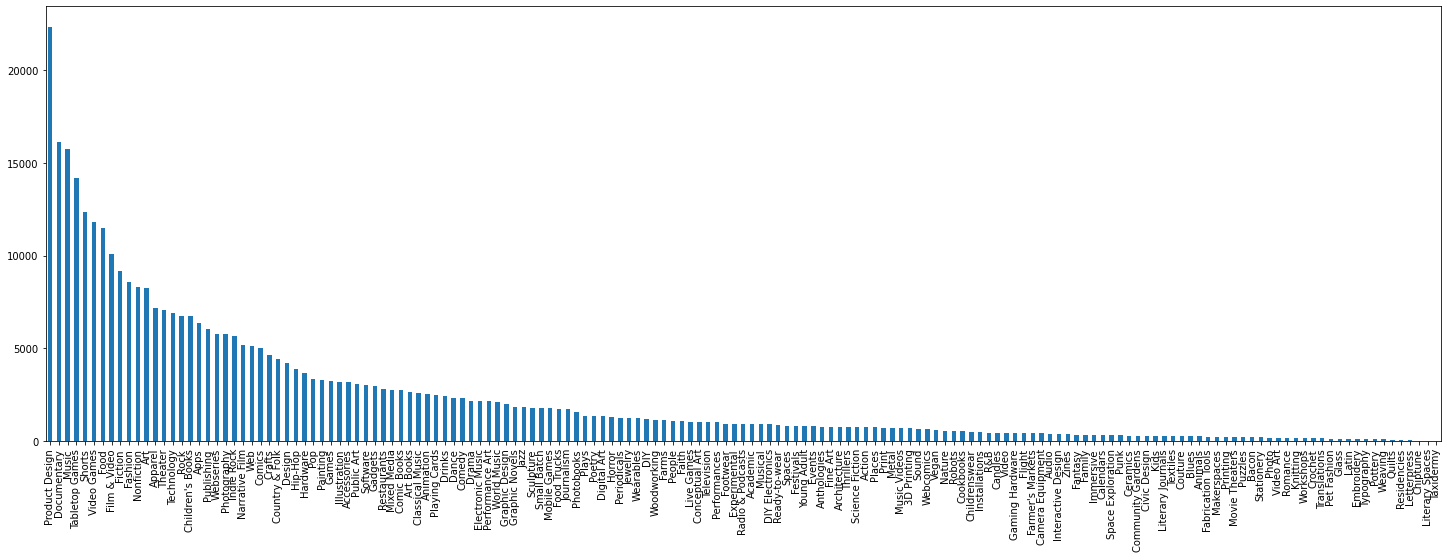

In [ ]:
k_cat.plot.bar(figsize=(25,8))

Le categorie sono molto poco bilanciate, le categorie più popolari hanno molte più campagne. Per quanto riguarda la categorie più generali, indicate dalla colonna main_category:

In [ ]:
k_maincat = kickstarter['main_category'].value_counts()
k_maincat

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

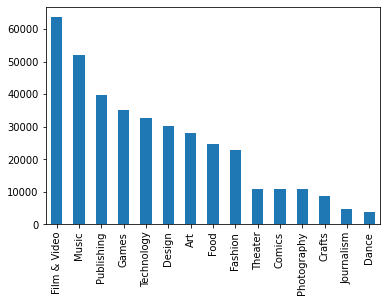

In [ ]:
k_maincat.plot.bar()

Nonostante "Product Design" sia la categoria specifica più popolare, la categoria principale più popolare è "Film & Video", seguita da "Music". "Design", categoria principale di "Product Design", è al sesto posto.

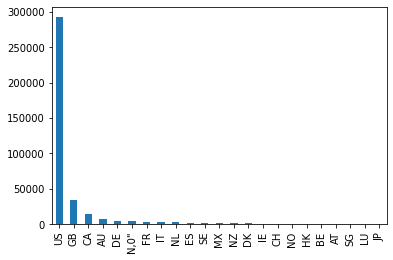

In [ ]:
kickstarter['country'].value_counts().plot.bar()

La stragrande maggior parte delle campagne viene dagli Stati Uniti, seguiti dalla Gran Bretagna.

Per studiare la distribuzione dei valori delle varie colonne, tentando di approssimare le PDF e CDF, si considerano solo le campagne che hanno ricevuto almeno un minimo di attenzione, basandosi sulla quantità minima di fondi ricevuti.

In [ ]:
kickstarter_cut = kickstarter[kickstarter['usd_pledged_real']>50000]

Analizziamo le CDF dell'obiettivo per ogni categoria principale, utilizzando la scala logaritmica data la grandezza dei dati.

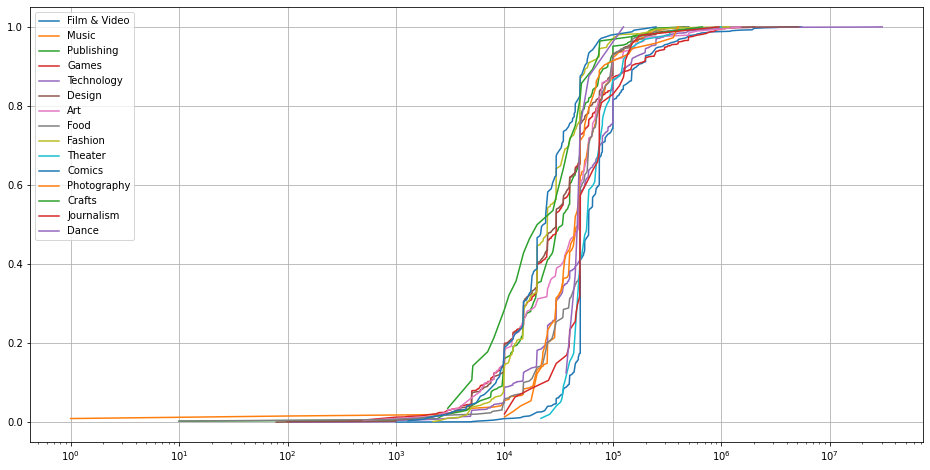

In [ ]:
main_categories = ['Film & Video', 'Music', 'Publishing', 'Games', 'Technology', 'Design', 'Art', 'Food', 'Fashion', 'Theater', 'Comics', 'Photography', 'Crafts', 'Journalism', 'Dance'];
plt.figure(figsize=(16,8))
for category in main_categories:
  col = kickstarter_cut[kickstarter_cut['main_category']==category]['usd_goal_real']
  cdf = col.value_counts(normalize=True).sort_index().cumsum()
  plt.plot(cdf.index, cdf.values)
plt.legend(main_categories)
plt.grid()
plt.xscale('log')
plt.show()

Tutte le curve hanno forme molto simili, varia la posizione nel grafico. Le categorie più spostate a destra sono quelle in cui si tende a chiedere più fondi, come "Film & Video" e "Theater".

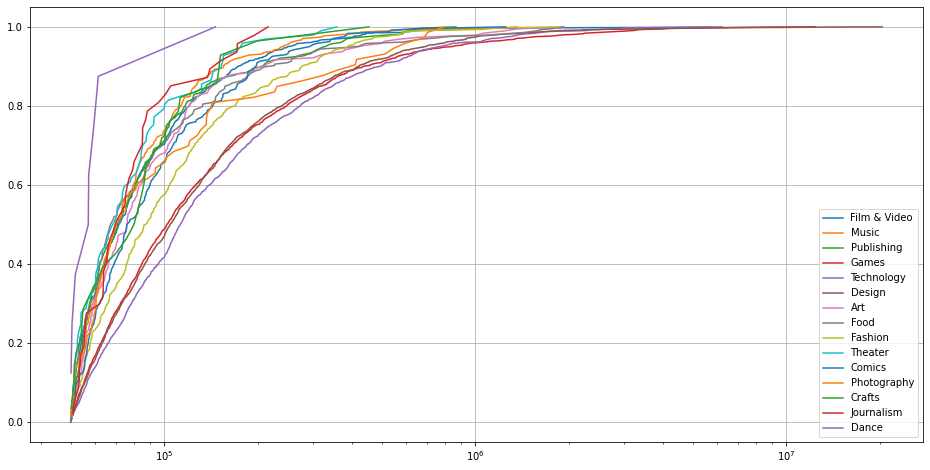

In [ ]:
main_categories = ['Film & Video', 'Music', 'Publishing', 'Games', 'Technology', 'Design', 'Art', 'Food', 'Fashion', 'Theater', 'Comics', 'Photography', 'Crafts', 'Journalism', 'Dance'];
plt.figure(figsize=(16,8))
for category in main_categories:
  col = kickstarter_cut[kickstarter_cut['main_category']==category]['usd_pledged_real']
  cdf = col.value_counts(normalize=True).sort_index().cumsum()
  plt.plot(cdf.index, cdf.values)
plt.legend(main_categories)
plt.grid()
plt.xscale('log')
plt.show()

Anche le CDF del numero di fondi ottenuti a fine campagna sono generalmente simili. La curva di "Technology" è quella generalmente più bassa, quindi è quella in cui si ricevono più fondi.

Spiccano certe categorie come "Dance", "Journalism", "Theater" e "Publishing" in cui la curva si ferma prima, implicando che hanno poche campagne con tanti fondi.

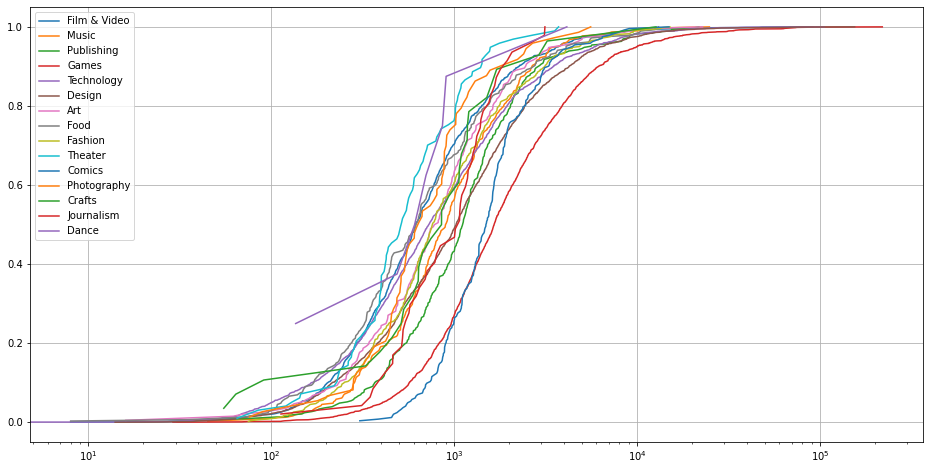

In [ ]:
main_categories = ['Film & Video', 'Music', 'Publishing', 'Games', 'Technology', 'Design', 'Art', 'Food', 'Fashion', 'Theater', 'Comics', 'Photography', 'Crafts', 'Journalism', 'Dance'];
plt.figure(figsize=(16,8))
for category in main_categories:
  col = kickstarter_cut[kickstarter_cut['main_category']==category]['backers']
  cdf = col.value_counts(normalize=True).sort_index().cumsum()
  plt.plot(cdf.index, cdf.values)
plt.legend(main_categories)
plt.grid()
plt.xscale('log')
plt.show()

Per quanto riguarda il numero di backers, tra le colonne a cui corrispondono curve che si fermano prima sembrano esserci sempre "Journalism", "Theater" e "Dance", a cui si aggiunge "Photography".
Quella di "Games" è la curva generalmente più in basso delle altre, stando ad indicare che è la categoria più popolare tra la gente disposta ad offrire.

Confrontiamo le stime delle Probability Density Function rispetto al numero di backers.

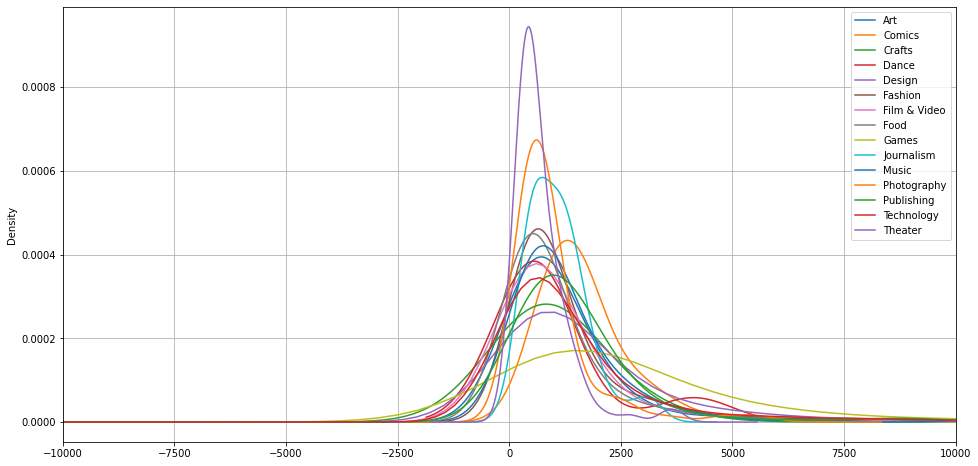

In [ ]:
plt.figure(figsize=(16,8))
kickstarter_cut.groupby('main_category')['backers'].plot.density()
plt.legend()
plt.grid()
plt.xlim(-10000, 10000)
plt.show()

Le PDF sembrano seguire un andamento gaussiano.

La categoria con la curva generalmente più in alto e con il picco più alto è "Design", implicando che le campagne di questa categoria hanno con alta probabilità un numero di backers che si aggira intorno al picco; quella con la curva generalmente più bassa e appiattita è "Games".

Una maggiore quantità di fondi non implica sempre un alto numero di sostenitori, e viceversa: nelle due top 10 per fondi e sostenitori appaiono in comune solo "Pebble Time" che "Exploding Kittens".

In [ ]:
kickstarter.sort_values(by='backers', ascending=False).head(10)

ID  ... uppercase_num
187652  1955357092  ...             2
75900   1386523707  ...             6
292244   557230947  ...             7
148585  1755266685  ...             5
182657  1929840910  ...             3
23404   1118803016  ...             5
157270  1799979574  ...             6
239175   286165030  ...             3
272924   458565935  ...             2
38291   1194278206  ...             6

[10 rows x 17 columns]

Uno dei motivi è sicuramente che certi prodotti hanno degli obiettivi di base più costosi: non a caso, nella top 10 per fondi appaiono diversi giochi indie, noti per avere un costo contenuto e molti giocatori preferiscono dare i fondi al Kickstarter come una sorta di pre-ordine del gioco.

Confrontiamo lo stato delle campagne per categoria.

In [ ]:
pd.crosstab(kickstarter['main_category'], kickstarter['state'], normalize='index')

state          canceled    failed      live  successful  suspended  undefined
main_category                                                                
Art            0.078926  0.501936  0.006891    0.408837   0.003410   0.000000
Comics         0.077826  0.373047  0.007025    0.539976   0.002126   0.000000
Crafts         0.095698  0.647406  0.008628    0.240095   0.008173   0.000000
Dance          0.043259  0.327760  0.004777    0.620488   0.003450   0.000265
Design         0.138078  0.492650  0.010143    0.350848   0.008214   0.000067
Fashion        0.116147  0.621581  0.010957    0.245135   0.006048   0.000131
Film & Video   0.090509  0.517481  0.005221    0.371518   0.001840   0.013431
Food           0.089871  0.649094  0.007479    0.247338   0.006219   0.000000
Games          0.176038  0.454231  0.008146    0.355312   0.006245   0.000028
Journalism     0.109989  0.659727  0.006519    0.212829   0.010936   0.000000
Music          0.063658  0.418968  0.005412    0.466062   0.002870   0.043029
Photography    0.091474  0.592263  0.004453    0.306615   0.005103   0.000093
Publishing     0.090335  0.580453  0.007499    0.308472   0.001655   0.011586
Technology     0.144770  0.632995  0.011575    0.197550   0.013019   0.000092
Theater        0.055713  0.339778  0.003757    0.598735   0.001924   0.000092

La categoria con una percentuale più alta di campagne fallite è "Journalism", mentre quella con una percentuale più alta di campagne con successo è sorprendentemente "Dance", nonostante ricevano generalmente meno fondi e abbiano pochi backers.

Vediamo in generale il numero di occorrenze per ogni stato della campagna, quindi quante campagne nel dataset hanno avuto successo o meno.

In [ ]:
k_state = kickstarter['state'].value_counts()
k_state

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

Seppur il numero di campagne fallite sia maggiore delle campagne terminate con successo, non c'è un'enorme differenza.

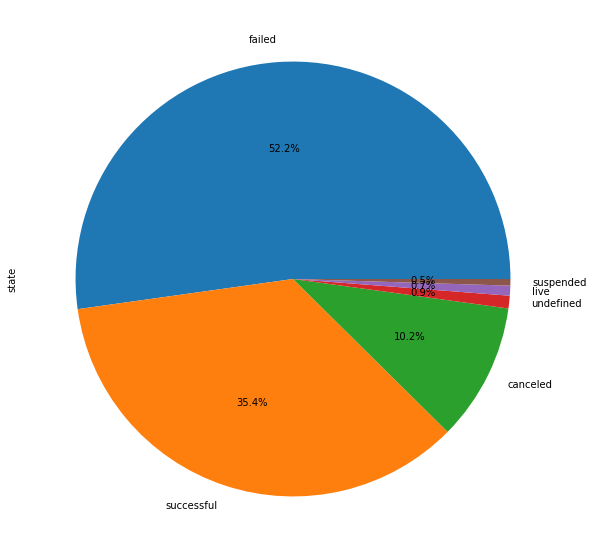

In [ ]:
k_state.plot(kind='pie', autopct='%1.1f%%', figsize=(10,10))

### Confronto tra anni

In [ ]:
kickstarter.sort_values(by='launched_year').head(10)

ID  ... uppercase_num
247913   330942060  ...            15
75397   1384087152  ...             6
273779   462917959  ...             4
2842    1014746686  ...             7
319002    69489148  ...             3
94579   1480763647  ...             9
48147   1245461087  ...             7
377716   995325523  ...             2
38188   1193712346  ...            13
18467   1093774966  ...             6

[10 rows x 17 columns]

Rimuoviamo i record con l'anno 1970, chiaramente errati.

In [ ]:
kickstarter = kickstarter[kickstarter['launched_year'] != 1970]

In [ ]:
k_state_year = kickstarter.groupby('launched_year')['state'].value_counts()
k_state_year

launched_year  state     
2009           failed          600
               successful      579
               canceled        150
2010           failed         4984
               successful     4593
               canceled        926
               suspended        16
2011           successful    12171
               failed        11878
               canceled       2144
               suspended        44
2012           failed        20588
               successful    17892
               canceled       2631
               suspended        52
               undefined         2
2013           failed        21686
               successful    19415
               canceled       3690
               suspended        58
               undefined         2
2014           failed        38199
               successful    21107
               canceled       7418
               undefined       751
               suspended       270
2015           failed        44301
               successful    

In [ ]:
pd.crosstab(kickstarter['launched_year'], kickstarter['state'], normalize='index')

state          canceled    failed      live  successful  suspended  undefined
launched_year                                                                
2009           0.112867  0.451467  0.000000    0.435666   0.000000   0.000000
2010           0.088031  0.473809  0.000000    0.436638   0.001521   0.000000
2011           0.081717  0.452719  0.000000    0.463887   0.001677   0.000000
2012           0.063914  0.500134  0.000000    0.434641   0.001263   0.000049
2013           0.082272  0.483512  0.000000    0.432878   0.001293   0.000045
2014           0.109499  0.563864  0.000000    0.311565   0.003986   0.011086
2015           0.115485  0.573105  0.000000    0.271294   0.009327   0.030789
2016           0.124493  0.533821  0.000035    0.328169   0.006016   0.007467
2017           0.110460  0.478103  0.051245    0.353678   0.006513   0.000000
2018           0.016129  0.000000  0.983871    0.000000   0.000000   0.000000

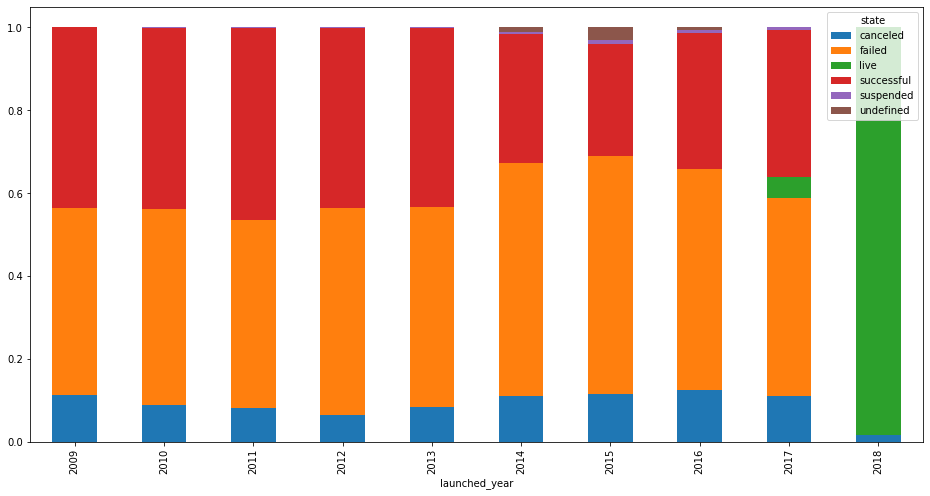

In [ ]:
pd.crosstab(kickstarter['launched_year'], kickstarter['state'], normalize='index').plot.bar(stacked=True, figsize=(16,8))

Il 2011 ha la percentuale maggiore di campagne terminate con successo, mentre il 2015 ha la percentuale maggiore di campagne fallite.

## 4.2 Statistica descrittiva

### 4.2.1 Medie

Calcoliamo le medie dei valori numerici per ogni categoria.

In [ ]:
kickstarter.groupby(by='main_category').mean().sort_values(by='backers', ascending=False)

ID     backers  ...  name_length  uppercase_num
main_category                            ...                            
Games          1.072129e+09  321.785615  ...    32.613937       5.205841
Design         1.078321e+09  241.307659  ...    39.262638       6.172536
Technology     1.071495e+09  164.466609  ...    37.630477       5.518653
Comics         1.063611e+09  134.771236  ...    32.941122       6.189019
Film & Video   1.074963e+09   66.017284  ...    30.570680       5.608197
Fashion        1.069690e+09   61.447800  ...    35.565524       5.996581
Publishing     1.077111e+09   55.967422  ...    36.442555       5.485015
Food           1.081894e+09   54.172466  ...    34.115072       5.096252
Music          1.075009e+09   52.169328  ...    36.481827       6.424543
Theater        1.068311e+09   47.061584  ...    36.887738       6.731580
Dance          1.075450e+09   42.801221  ...    36.048567       6.084395
Art            1.077782e+09   42.206593  ...    34.577884       5.357559
Photography    1.071581e+09   39.714074  ...    34.463401       5.014751
Journalism     1.076352e+09   38.294637  ...    33.991377       4.901157
Crafts         1.078527e+09   27.283687  ...    33.176865       4.449540

[15 rows x 9 columns]

Come previsto, la categoria con più backers in media è proprio "Games", seguita da "Design" e "Technology". 

Technology è un po' distaccata dalle prime due per quanto riguarda il numero di backers e molto distaccata per quanto riguarda l'obiettivo minimo, sicuramente perché molte campagne prevedono prodotti tecnologici costosi di fascia alta, che richiedono un obiettivo alto per la produzione e un costo elevato da parte di un sostenitore per riceverlo, quindi tende ad offrire meno gente con più soldi per singolo sostenitore.

### 4.2.2 Mode

In [ ]:
kickstarter['main_category'].mode()

0    Film & Video
dtype: object

In [ ]:
kickstarter['category'].mode()

0    Product Design
dtype: object

La categoria generale più popolare è "Film & Video", mentre quella specifica è "Product Design".

Vediamo ora le categorie più popolari per anno.

In [ ]:
kickstarter.groupby('launched_year')['main_category'].agg(pd.Series.mode)

launched_year
2009    Film & Video
2010    Film & Video
2011    Film & Video
2012    Film & Video
2013    Film & Video
2014    Film & Video
2015    Film & Video
2016      Technology
2017           Games
2018    [Art, Music]
Name: main_category, dtype: object

"Film & Video" è stata la più popolare per 7 anni di fila, dalla nascita di Kickstarter nel 2009 fino al 2015.

In effetti, Kickstarter è diventato più popolare per le campagne di altri media come musica e videogiochi e per la tecnologia solo in tempi relativamente recenti.

In [ ]:
kickstarter.groupby('launched_year')['category'].agg(pd.Series.mode)

launched_year
2009       Documentary
2010            Shorts
2011            Shorts
2012       Documentary
2013            Shorts
2014    Product Design
2015    Product Design
2016    Product Design
2017    Product Design
2018    Tabletop Games
Name: category, dtype: object

La categoria specifica "Product Design" è stata la più popolare per 4 anni di fila, dal 2014 al 2017.

In [ ]:
kickstarter['launched_year'].mode()

0    2015
dtype: int64

L'anno con più campagne è stato il 2015, che è anche l'anno con più campagne fallite.

### 4.2.3 Box plot

Vediamo i box plot degli obiettivi per ogni categoria.

Art                  AxesSubplot(0.1,0.736957;0.173913x0.163043)
Comics          AxesSubplot(0.308696,0.736957;0.173913x0.163043)
Crafts          AxesSubplot(0.517391,0.736957;0.173913x0.163043)
Dance           AxesSubplot(0.726087,0.736957;0.173913x0.163043)
Design               AxesSubplot(0.1,0.541304;0.173913x0.163043)
Fashion         AxesSubplot(0.308696,0.541304;0.173913x0.163043)
Film & Video    AxesSubplot(0.517391,0.541304;0.173913x0.163043)
Food            AxesSubplot(0.726087,0.541304;0.173913x0.163043)
Games                AxesSubplot(0.1,0.345652;0.173913x0.163043)
Journalism      AxesSubplot(0.308696,0.345652;0.173913x0.163043)
Music           AxesSubplot(0.517391,0.345652;0.173913x0.163043)
Photography     AxesSubplot(0.726087,0.345652;0.173913x0.163043)
Publishing               AxesSubplot(0.1,0.15;0.173913x0.163043)
Technology          AxesSubplot(0.308696,0.15;0.173913x0.163043)
Theater             AxesSubplot(0.517391,0.15;0.173913x0.163043)
dtype: object

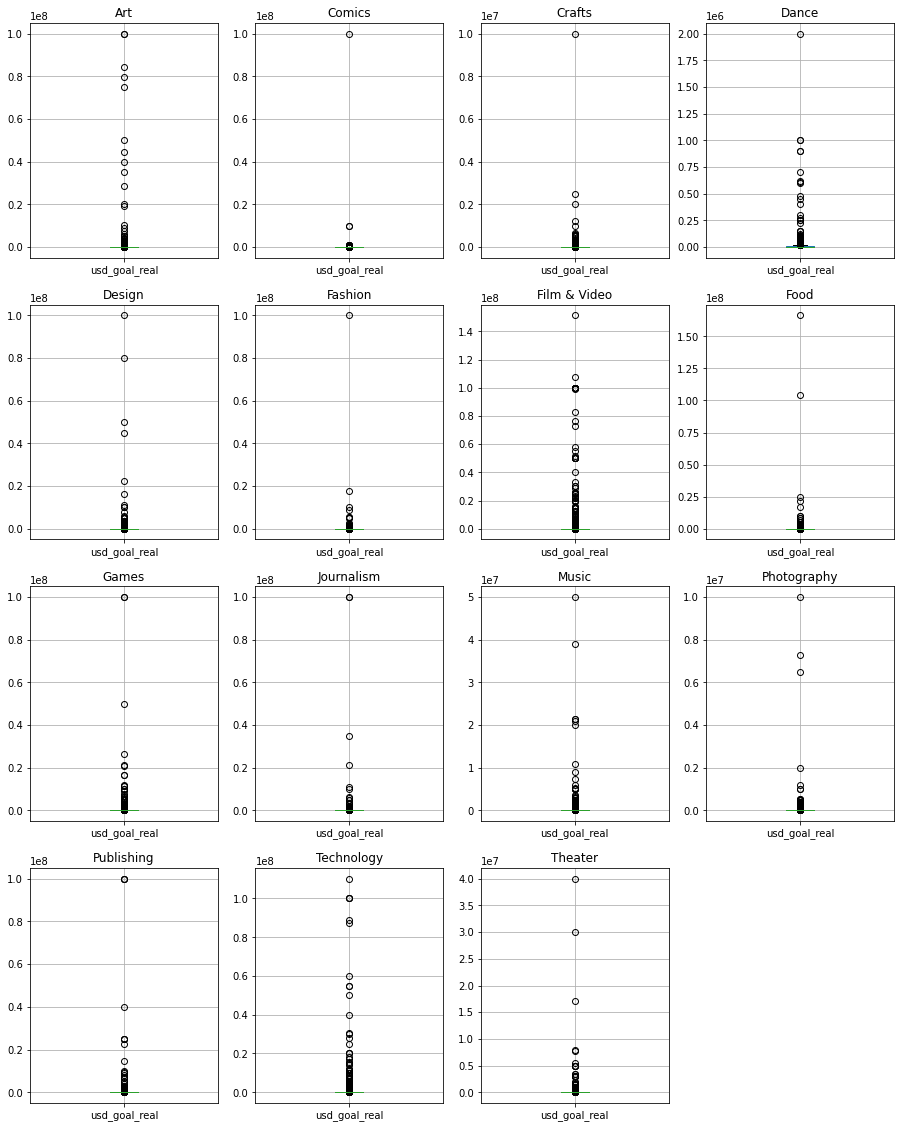

In [ ]:
kickstarter.groupby('main_category').boxplot(column=['usd_goal_real'], sharey=False, figsize=(15,20))

Gli outlier sono tantissimi per ogni categoria, il box stesso è appena visibile solo per la categoria "Dance". 

Le categorie generali sono **"granulose"**, ossia ogni categoria ha molti tipi diversi di prodotti con costi di produzione diversi. 

Per trovare più uniformità bisogna guardare i box plot delle categorie più specifiche. In alcune si riesce a riconoscere il box e ci sono relativamente pochi outlier.

In [ ]:
kickstarter.groupby('category').boxplot(column=['usd_goal_real'], sharey=False, figsize=(150,200))

3D Printing        AxesSubplot(0.1,0.851299;0.0519481x0.0487013)
Academic       AxesSubplot(0.162338,0.851299;0.0519481x0.0487...
Accessories    AxesSubplot(0.224675,0.851299;0.0519481x0.0487...
Action         AxesSubplot(0.287013,0.851299;0.0519481x0.0487...
Animals        AxesSubplot(0.349351,0.851299;0.0519481x0.0487...
                                     ...                        
Woodworking    AxesSubplot(0.785714,0.208442;0.0519481x0.0487...
Workshops      AxesSubplot(0.848052,0.208442;0.0519481x0.0487...
World Music            AxesSubplot(0.1,0.15;0.0519481x0.0487013)
Young Adult       AxesSubplot(0.162338,0.15;0.0519481x0.0487013)
Zines             AxesSubplot(0.224675,0.15;0.0519481x0.0487013)
Length: 159, dtype: object

La categoria specifica con il box plot più regolare è "Embroidery". Infatti, come si vedrà fra poco, ha l'indice di curtosi più basso tra tutte.

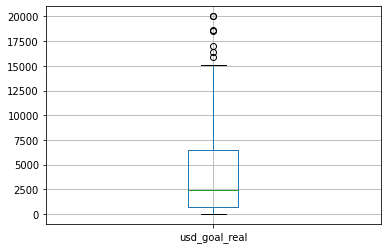

In [ ]:
kickstarter[kickstarter['category']=='Embroidery'].boxplot(column=['usd_goal_real'])

### 4.2.4 Indici di forma

Si analizzano gli indici di forma per categoria, data la granulosità dei dati come appurato nel paragrafo precedente.

In [ ]:
kickstarter.groupby('main_category').skew()

ID     backers  ...  name_length  uppercase_num
main_category                        ...                            
Art           -0.005830   56.012976  ...     0.186599       3.785508
Comics         0.007342   13.231469  ...     0.222982       3.100137
Crafts        -0.020765   53.592066  ...     0.268020       4.724929
Dance          0.000717   28.662734  ...     0.004395       3.384617
Design        -0.009852   50.095983  ...    -0.365760       3.385543
Fashion        0.010751   21.558158  ...    -0.020053       3.482244
Film & Video  -0.005454  102.064268  ...     0.450281       3.210355
Food          -0.014427   28.554389  ...     0.183838       4.178176
Games         -0.001018   44.883550  ...     0.160222       3.249961
Journalism    -0.006849    9.740003  ...     0.266849       4.082060
Music          0.000245   53.641815  ...     0.106742       3.474654
Photography    0.001742   17.462756  ...     0.218714       4.045508
Publishing    -0.009125   36.912476  ...     0.013847       3.986088
Technology     0.006749   41.090539  ...    -0.314357       3.796887
Theater        0.019462   14.366094  ...     0.011971       2.792588

[15 rows x 9 columns]

I valori per le feature originali del dataset sono molto alti. Le categorie più bilanciate sembrano essere "Journalism" e "Dance". Vediamo le categorie specifiche.

In [ ]:
kickstarter.groupby('category').skew().sort_values(by='backers').head(1)

ID   backers  ...  name_length  uppercase_num
category                      ...                            
Taxidermy -0.11245  1.335806  ...    -0.960361       1.787973

[1 rows x 9 columns]

In [ ]:
kickstarter.groupby('category').skew().sort_values(by='usd_pledged_real').head(1)

ID   backers  ...  name_length  uppercase_num
category                         ...                            
Residencies  0.164502  1.408252  ...     0.127666       2.388702

[1 rows x 9 columns]

In [ ]:
kickstarter.groupby('category').skew().sort_values(by='usd_goal_real').head(1)

ID   backers  ...  name_length  uppercase_num
category                        ...                            
Embroidery -0.123652  4.047236  ...     0.217251       3.807591

[1 rows x 9 columns]

Le distribuzioni più bilanciate sono quelle delle categorie "Taxidermy", "Residencies" ed "Embroidery", rispettivamente per quanto riguarda il numero di backers, l'ammontare finale e l'obiettivo.

Questo implica, ad esempio, che per quanto riguarda le campagne di "Embroidery" (ricamo) l'obiettivo richiesto non si discosta troppo dal valore centrale. In effetti, è una categoria molto specifica per cui difficilmente si chiede più di un certo ammontare per un progetto.

Vediamo i valori di curtosi, l'indice che quantifica la somiglianza di una distribuzione alla gaussiana.

In [ ]:
kickstarter.groupby('main_category').apply(pd.DataFrame.kurt)

ID       backers  ...  name_length  uppercase_num
main_category                          ...                            
Art           -1.201153   5039.823438  ...    -0.913898      20.772462
Comics        -1.191936    311.708933  ...    -0.856175      12.950761
Crafts        -1.197628   3936.421484  ...    -1.099772      36.587799
Dance         -1.218107   1289.574731  ...    -0.871278      17.503038
Design        -1.194172   4038.939215  ...    -1.083994      18.062804
Fashion       -1.191564    657.565176  ...    -1.215054      16.907742
Film & Video  -1.206081  14783.631745  ...    -0.595545      15.288585
Food          -1.195799   1142.322268  ...    -1.105006      27.465820
Games         -1.199949   3476.893712  ...    -1.164422      19.440307
Journalism    -1.176920    132.393399  ...    -0.934010      26.775163
Music         -1.197208   5382.673620  ...    -0.647459      16.998588
Photography   -1.205753    527.697555  ...    -0.874560      22.772526
Publishing    -1.199393   2029.248550  ...    -1.068678      24.495815
Technology    -1.183313   2956.832227  ...    -1.186612      24.338973
Theater       -1.204285    363.681792  ...    -0.758494      10.691346

[15 rows x 9 columns]

I valori per le feature originali sono tutti molto alti. Si trovano valori più bassi per le categorie specifiche.

In [ ]:
kickstarter.groupby('category').apply(pd.DataFrame.kurt).sort_values(by='backers').head(1)

ID   backers  ...  name_length  uppercase_num
category                       ...                            
Taxidermy -0.886378  0.484162  ...     -0.05937       3.377661

[1 rows x 9 columns]

In [ ]:
kickstarter.groupby('category').apply(pd.DataFrame.kurt).sort_values(by='usd_pledged_real').head(1)

ID   backers  ...  name_length  uppercase_num
category                         ...                            
Residencies -1.485251  2.771951  ...    -1.314208       8.110885

[1 rows x 9 columns]

In [ ]:
kickstarter.groupby('category').apply(pd.DataFrame.kurt).sort_values(by='usd_goal_real').head(1)

ID    backers  ...  name_length  uppercase_num
category                         ...                            
Embroidery -1.233505  18.268521  ...    -0.889075      22.697808

[1 rows x 9 columns]

Tutte le distribuzioni sono leptocurtiche. Quella che si avvicina di più alla normale è quella dei backers per la categoria "Taxidermy", seguita da quella degli obiettivi per la categoria "Embroidery".

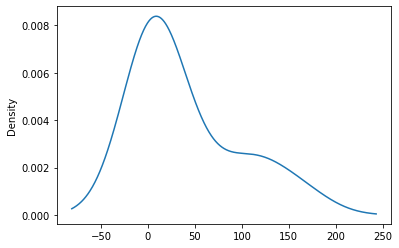

In [ ]:
kickstarter[kickstarter['category']=='Taxidermy']['backers'].plot.density()

Per quanto riguarda la pdf dei backers per "Taxidermy", probabilmente la motivazione è che si tratta di una categoria molto di nicchia in cui offrono più o meno le stesse persone.

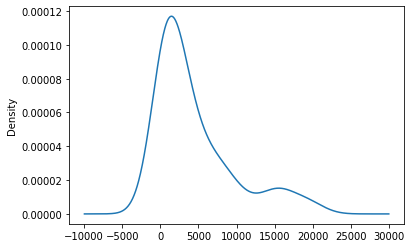

In [ ]:
kickstarter[kickstarter['category']=='Embroidery']['usd_goal_real'].plot.density()

L'approssimazione delle due PDF è quella di una gaussiana con delle gobbe a destra.

### 4.2.5 Correlazioni



Per valutare le correlazioni tra le colonne del dataset, si considerano solo quelle numeriche indipendenti.


In [ ]:
kickstarter_cut = kickstarter[['backers', 'usd_pledged_real', 'usd_goal_real', 'name_length', 'days_duration', 'contains_excl', 'uppercase_num']].copy()

In [ ]:
kickstarter_cut.corr(method='pearson')

backers  usd_pledged_real  ...  contains_excl  uppercase_num
backers           1.000000          0.752539  ...      -0.000228       0.015447
usd_pledged_real  0.752539          1.000000  ...      -0.004921       0.019349
usd_goal_real     0.004517          0.005596  ...      -0.001804      -0.000280
name_length       0.020532          0.028966  ...       0.160933       0.364196
days_duration    -0.000792          0.000946  ...       0.001636       0.005083
contains_excl    -0.000228         -0.004921  ...       1.000000       0.077820
uppercase_num     0.015447          0.019349  ...       0.077820       1.000000

[7 rows x 7 columns]

L'unica correlazione significativa è quella tra il numero di backers e la quantità totale in dollari di soldi depositati.

C'è una debole correlazione positiva tra "name_length" e "uppercase_num": ha senso, considerando che nomi più lunghi hanno con più probabilità più caratteri maiuscoli.

In [ ]:
kickstarter_cut.corr(method='spearman')

backers  usd_pledged_real  ...  contains_excl  uppercase_num
backers           1.000000          0.945812  ...       0.051707       0.171821
usd_pledged_real  0.945812          1.000000  ...       0.048158       0.182696
usd_goal_real     0.109384          0.180724  ...      -0.027289       0.054672
name_length       0.147515          0.156216  ...       0.160362       0.548113
days_duration    -0.000476          0.016587  ...       0.005505       0.025935
contains_excl     0.051707          0.048158  ...       1.000000       0.087712
uppercase_num     0.171821          0.182696  ...       0.087712       1.000000

[7 rows x 7 columns]

In [ ]:
kickstarter_cut.corr(method='kendall')

backers  usd_pledged_real  ...  contains_excl  uppercase_num
backers           1.000000          0.830495  ...       0.043014       0.123142
usd_pledged_real  0.830495          1.000000  ...       0.039670       0.129985
usd_goal_real     0.082507          0.145075  ...      -0.022464       0.038940
name_length       0.101163          0.106416  ...       0.132158       0.434246
days_duration    -0.000375          0.012321  ...       0.004841       0.019574
contains_excl     0.043014          0.039670  ...       1.000000       0.075093
uppercase_num     0.123142          0.129985  ...       0.075093       1.000000

[7 rows x 7 columns]

Tramite il coefficiente di Spearman le due correlazioni individuate sono associate a valori più alti, ma non se ne individuano altre significative.

Le stesse considerazioni valgono per il coefficiente di Kendall.

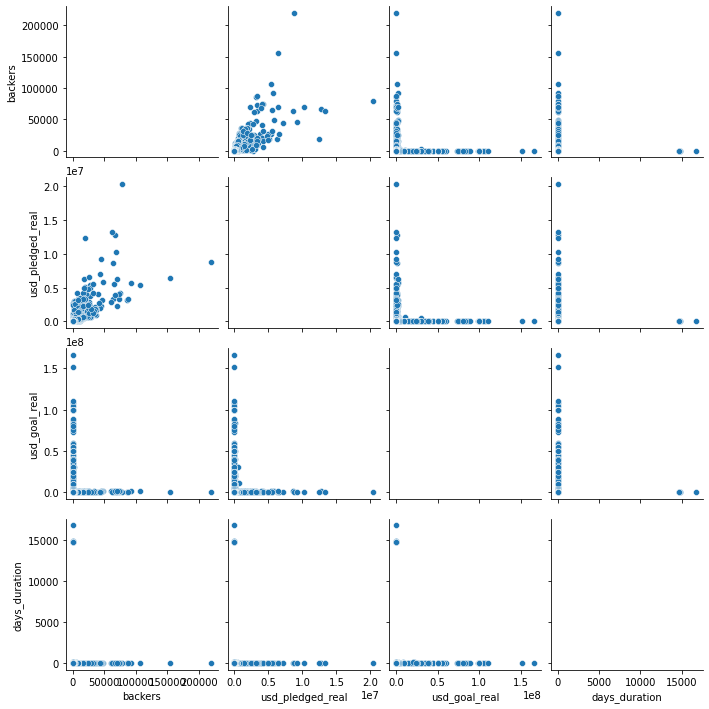

In [ ]:
sns.pairplot(kickstarter_cut)

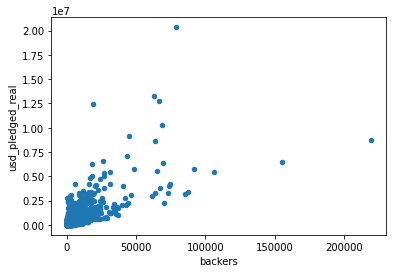

In [ ]:
kickstarter.plot.scatter(x='backers', y='usd_pledged_real')

Per quanto riguarda la suddivisione in categoria, apparentemente si trovano risultati simili.

In [ ]:
kickstarter.groupby('category').corr()

ID   backers  ...  name_length  uppercase_num
category                                          ...                            
3D Printing ID                1.000000 -0.028549  ...     0.025937      -0.021680
            backers          -0.028549  1.000000  ...     0.055710       0.041561
            usd_pledged_real -0.029192  0.885677  ...     0.101771       0.095022
            usd_goal_real    -0.007046  0.031194  ...    -0.014033       0.023747
            launched_year    -0.013020 -0.025915  ...     0.028590       0.048493
...                                ...       ...  ...          ...            ...
Zines       launched_year    -0.107801  0.006888  ...     0.004675      -0.012384
            days_duration     0.007717 -0.054770  ...    -0.006070       0.059564
            contains_!       -0.001833  0.008014  ...     0.301281       0.206709
            name_length       0.099786  0.157928  ...     1.000000       0.351367
            uppercase_num     0.057812  0.025284  ...     0.351367       1.000000

[1431 rows x 9 columns]

Per cercare correlazioni tra il numero di fondi finale e un'altra colonna che non sia quella dei backers, si escludono le righe con correlazione 1 con "backers" e "usd_pledged_real" stesso.

In [ ]:
k_corrbycat = kickstarter.groupby('category').corr()
k_corrbycat.sort_values(by='usd_pledged_real', ascending=False)[(k_corrbycat['usd_pledged_real']<1.0) & (k_corrbycat['backers']<1.0)].head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


ID   backers  ...  name_length  uppercase_num
category                                           ...                            
Chiptune        usd_goal_real -0.044522  0.714468  ...     0.213143       0.362629
Taxidermy       uppercase_num  0.181097  0.637798  ...     0.516336       1.000000
Video Art       usd_goal_real  0.161840  0.368975  ...    -0.081442      -0.027347
Weaving         uppercase_num  0.011477  0.573758  ...     0.221788       1.000000
                usd_goal_real -0.057971  0.552689  ...     0.107389       0.561232
Chiptune        uppercase_num  0.129899  0.467116  ...     0.398558       1.000000
Knitting        usd_goal_real  0.000395  0.274725  ...    -0.085788       0.037944
Embroidery      uppercase_num -0.096573  0.329009  ...     0.087056       1.000000
Classical Music usd_goal_real -0.025397  0.289333  ...    -0.003065       0.025476
Graphic Design  usd_goal_real  0.006517  0.246376  ...     0.072833       0.006890
Bacon           uppercase_num  0.065989  0.290733  ...     0.407773       1.000000
Sound           usd_goal_real  0.040962  0.189816  ...     0.003306       0.102994
Letterpress     usd_goal_real -0.151944  0.282399  ...     0.098296       0.201095
Makerspaces     contains_!     0.020932  0.318751  ...     0.188900       0.032327
Crochet         name_length   -0.096183  0.249430  ...     1.000000       0.250788
Jazz            usd_goal_real -0.009499  0.160486  ...    -0.034575       0.027745
Pottery         usd_goal_real -0.014022  0.173564  ...     0.095533       0.021803
Residencies     uppercase_num -0.041559  0.188502  ...     0.249104       1.000000
Glass           name_length    0.152861  0.146800  ...     1.000000       0.367918
Photobooks      usd_goal_real -0.030967  0.198744  ...     0.041767       0.015916

[20 rows x 9 columns]

Nelle categorie "Chiptune" e "Video Art" si ha una correlazione maggiore di 0.7 tra obiettivo e fondi finali.

Più sorprendentemente, nelle categorie "Taxidermy" e "Weaving" c'è anche una correlazione tra il numero di caratteri maiuscoli e i fondi finali.

In [ ]:
k_corrbycat = kickstarter.groupby('category').corr(method='spearman')
k_corrbycat.sort_values(by='usd_pledged_real', ascending=False)[(k_corrbycat['usd_pledged_real']<1.0) & (k_corrbycat['backers']<1.0)].head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


ID  ...  uppercase_num
category                                  ...               
Chiptune         usd_goal_real -0.007284  ...       0.087497
Anthologies      usd_goal_real  0.071188  ...       0.066015
Letterpress      usd_goal_real -0.154895  ...       0.163335
Webcomics        usd_goal_real -0.081306  ...       0.120635
Letterpress      name_length    0.186974  ...       0.698037
Indie Rock       usd_goal_real  0.005100  ...       0.084839
Literary Spaces  usd_goal_real  0.236553  ...       0.108925
Letterpress      uppercase_num  0.144387  ...       1.000000
Dance            usd_goal_real -0.007040  ...       0.063591
Classical Music  usd_goal_real  0.020672  ...       0.077575
Typography       usd_goal_real -0.207925  ...       0.160192
3D Printing      usd_goal_real  0.027593  ...       0.150320
Residencies      usd_goal_real  0.134286  ...      -0.075688
Country & Folk   usd_goal_real  0.017130  ...       0.055023
Knitting         usd_goal_real -0.097520  ...       0.144180
Camera Equipment usd_goal_real  0.017183  ...       0.120187
Bacon            usd_goal_real  0.037428  ...       0.241645
Photobooks       usd_goal_real  0.002217  ...       0.084006
Shorts           usd_goal_real -0.000219  ...       0.080072
Performances     usd_goal_real  0.014119  ...       0.028513

[20 rows x 9 columns]

In [ ]:
k_corrbycat = kickstarter.groupby('category').corr(method='kendall')
k_corrbycat.sort_values(by='usd_pledged_real', ascending=False)[(k_corrbycat['usd_pledged_real']<1.0) & (k_corrbycat['backers']<1.0)].head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


ID   backers  ...  contains_excl  uppercase_num
category                                           ...                              
Chiptune        usd_goal_real -0.008418  0.449158  ...       0.083110       0.069111
Anthologies     usd_goal_real  0.047601  0.353576  ...       0.001554       0.047003
Residencies     usd_goal_real  0.104226  0.253578  ...      -0.062693      -0.062872
Letterpress     usd_goal_real -0.078837  0.224138  ...       0.218230       0.112954
Dance           usd_goal_real -0.005038  0.245982  ...      -0.029946       0.044881
Indie Rock      usd_goal_real  0.003387  0.275066  ...      -0.002671       0.060653
Classical Music usd_goal_real  0.013853  0.224739  ...      -0.030157       0.055415
Webcomics       usd_goal_real -0.054864  0.343616  ...       0.069627       0.086557
Literary Spaces usd_goal_real  0.161159  0.274054  ...       0.190207       0.069107
Country & Folk  usd_goal_real  0.011781  0.220204  ...       0.012771       0.039407
Performances    usd_goal_real  0.008818  0.230763  ...      -0.028517       0.020002
Typography      usd_goal_real -0.142685  0.241232  ...      -0.144967       0.109517
Jazz            usd_goal_real -0.002083  0.188511  ...      -0.013543       0.047696
Theater         usd_goal_real  0.002253  0.189064  ...      -0.008081       0.034987
Letterpress     name_length    0.123291  0.285960  ...       0.051482       0.560612
                uppercase_num  0.107530  0.267689  ...       0.074133       1.000000
Shorts          usd_goal_real -0.000159  0.201154  ...      -0.006110       0.056666
Knitting        usd_goal_real -0.068524  0.236002  ...       0.052233       0.103665
3D Printing     usd_goal_real  0.020306  0.196049  ...      -0.045542       0.103782
Taxidermy       uppercase_num  0.041499  0.225711  ...      -0.423207       1.000000

[20 rows x 9 columns]

Sia con il coefficiente di Spearman che con quello di Kendall si è trovata la correlazione nella categoria Chiptune, ma nessun'altra rilevante.

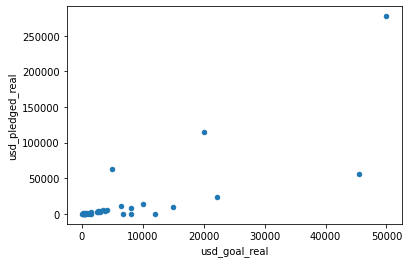

In [ ]:
kickstarter[kickstarter['category']=='Chiptune'].plot.scatter(x='usd_goal_real', y='usd_pledged_real')

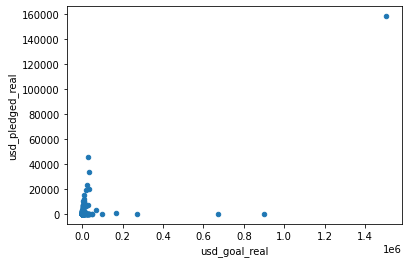

In [ ]:
kickstarter[kickstarter['category']=='Video Art'].plot.scatter(x='usd_goal_real', y='usd_pledged_real')

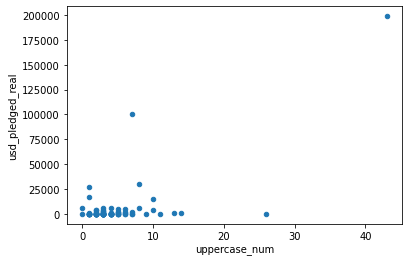

In [ ]:
kickstarter[kickstarter['category']=='Weaving'].plot.scatter(x='uppercase_num', y='usd_pledged_real')

## 4.3 Distribuzioni di probabilità

L'indice di curtosi aveva riportato che tutte le distribuzioni si allontanavano parecchio dalla gaussiana. In realtà, guardando i grafici delle PDF stimate si nota che le quantità di quasi tutte le categorie si distribuiscono attorno ad un picco all'origine.

Il motivo è sicuramente l'enorme quantità di outlier presente, già appurata dalla visualizzazione dei box plot.

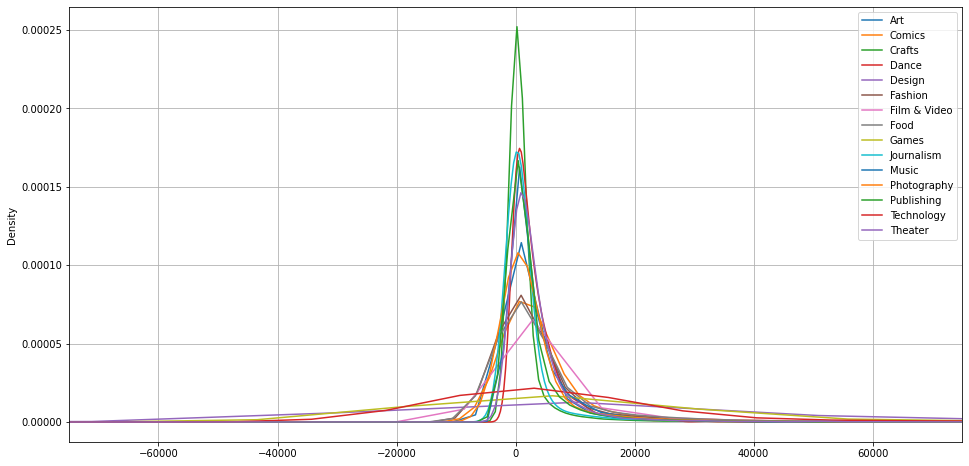

In [ ]:
plt.figure(figsize=(16,8))
kickstarter.groupby('main_category')['usd_pledged_real'].plot.density()
plt.legend()
plt.grid()
plt.xlim(-75000,75000)
plt.show()

Le quantità di fondi finali per ogni categoria attorno a [-75000, 75000] per alcune categorie hanno una distribuzione più appuntita, ricordando più la distribuzione di Laplace che la gaussiana.

In [ ]:
kickstarter.groupby('main_category').skew()

ID     backers  ...  name_length  uppercase_num
main_category                        ...                            
Art           -0.005830   56.012976  ...     0.186599       3.785508
Comics         0.007342   13.231469  ...     0.222982       3.100137
Crafts        -0.020765   53.592066  ...     0.268020       4.724929
Dance          0.000717   28.662734  ...     0.004395       3.384617
Design        -0.009852   50.095983  ...    -0.365760       3.385543
Fashion        0.010751   21.558158  ...    -0.020053       3.482244
Film & Video  -0.005454  102.064268  ...     0.450281       3.210355
Food          -0.014427   28.554389  ...     0.183838       4.178176
Games         -0.001018   44.883550  ...     0.160222       3.249961
Journalism    -0.006849    9.740003  ...     0.266849       4.082060
Music          0.000245   53.641815  ...     0.106742       3.474654
Photography    0.001742   17.462756  ...     0.218714       4.045508
Publishing    -0.009125   36.912476  ...     0.013847       3.986088
Technology     0.006749   41.090539  ...    -0.314357       3.796887
Theater        0.019462   14.366094  ...     0.011971       2.792588

[15 rows x 9 columns]

Le lunghezze dei nomi hanno un indice di asimmetria prossimo a zero.

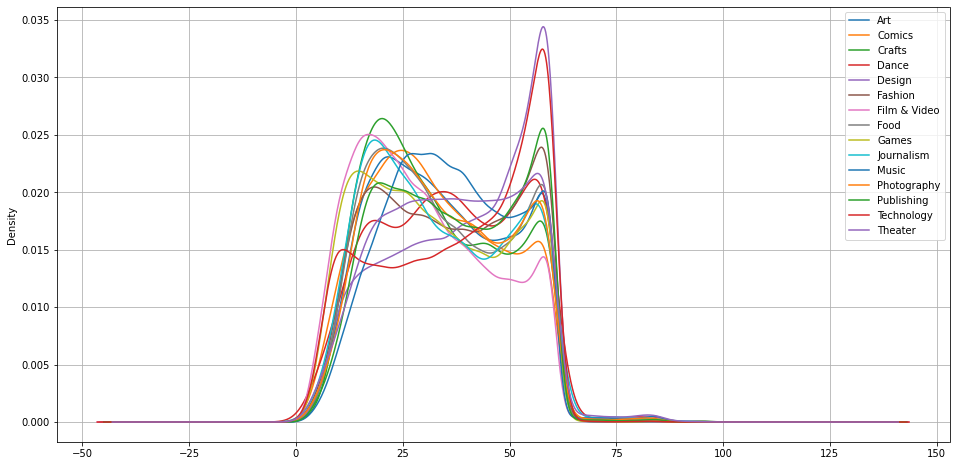

In [ ]:
plt.figure(figsize=(16,8))
kickstarter.groupby('main_category')['name_length'].plot.density()
plt.legend()
plt.grid()
plt.show()

Alcune distribuzioni sono più appiattite delle altre, somigliando un po' a quella uniforme, altre sembrano miscugli di gaussiane. Ci sono categorie come "Technology" e "Design" in cui si tende a dare nomi più lunghi, sui 60 caratteri, probabilmente per essere più descrittivi per prodotti specifici. Il massimo è 96.

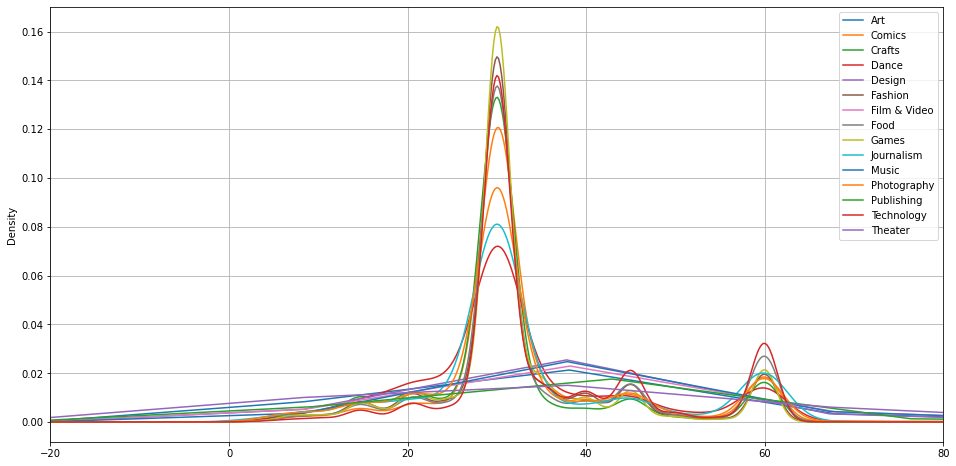

In [ ]:
plt.figure(figsize=(16,8))
kickstarter.groupby('main_category')['days_duration'].plot.density()
plt.legend()
plt.grid()
plt.xlim(-20,80)
plt.show()

Per la maggiorparte delle categorie, le distribuzioni delle durate delle campagne sono principalmente approssimabili a due gaussiane centrate in 30 e 60.

Per le rimanenti categorie, la forma delle curve ricorda più la distribuzione di Laplace.

In [ ]:
kickstarter_cut = kickstarter[kickstarter['usd_pledged_real']>1000]
kickstarter_cut = kickstarter[kickstarter['usd_pledged_real']<1070600]
kickstarter_cut.groupby('main_category').skew()

ID    backers  ...  name_length  uppercase_num
main_category                       ...                            
Art           -0.005856  28.594599  ...     0.186627       3.785364
Comics         0.007211  10.164767  ...     0.223027       3.099955
Crafts        -0.020765  53.592066  ...     0.268020       4.724929
Dance          0.000717  28.662734  ...     0.004395       3.384617
Design        -0.009856  14.517208  ...    -0.364714       3.388783
Fashion        0.010630  20.277262  ...    -0.019841       3.483504
Film & Video  -0.005384  26.760726  ...     0.450299       3.210797
Food          -0.014543  18.332817  ...     0.184047       4.178545
Games         -0.001221  10.122615  ...     0.159355       3.252997
Journalism    -0.006849   9.740003  ...     0.266849       4.082060
Music          0.000188  24.730523  ...     0.106816       3.475042
Photography    0.001742  17.462756  ...     0.218714       4.045508
Publishing    -0.009125  36.912476  ...     0.013847       3.986088
Technology     0.007157  11.124611  ...    -0.312343       3.801973
Theater        0.019462  14.366094  ...     0.011971       2.792588

[15 rows x 9 columns]

L'indice di asimmetria è diminuito un po' per le feature interessanti, ma è ancora parecchio alto.

In [ ]:
print(kickstarter['usd_pledged_real'].quantile(0.25))
print(kickstarter['usd_pledged_real'].quantile(0.75))

31.0
4050.0


In [ ]:
kickstarter_cut = kickstarter[kickstarter['usd_pledged_real']>31]
kickstarter_cut = kickstarter[kickstarter['usd_pledged_real']<4050]
kickstarter_cut.groupby('main_category').skew()

ID    backers  ...  name_length  uppercase_num
main_category                       ...                            
Art           -0.006507   3.191743  ...     0.226300       3.858701
Comics         0.002351   2.468730  ...     0.297056       3.257441
Crafts        -0.024503   4.071083  ...     0.313071       4.780584
Dance          0.015542   1.341439  ...     0.023053       3.504026
Design        -0.003840   3.253382  ...    -0.159253       3.709837
Fashion        0.006286   3.745433  ...     0.133580       3.646249
Film & Video  -0.006763   2.515394  ...     0.502897       3.473890
Food          -0.013242  19.039420  ...     0.291966       4.333859
Games         -0.002137   5.089277  ...     0.287159       3.475286
Journalism    -0.008237   4.246503  ...     0.309851       4.172160
Music         -0.002678   2.207639  ...     0.176983       3.604895
Photography    0.008933   2.847210  ...     0.281586       4.204048
Publishing    -0.004737   3.672494  ...     0.049932       4.143222
Technology     0.011394   5.829416  ...    -0.104672       4.130015
Theater        0.014435   1.351849  ...     0.044892       2.886639

[15 rows x 9 columns]

Limitandoci a campagne con un numero di fondi tra il primo e il terzo quartile si hanno valori più ragionevoli, ma dato il valore troppo basso del terzo quartile è un'analisi un po' superflua.

In [ ]:
print(kickstarter['usd_goal_real'].quantile(0.05))
print(kickstarter['usd_goal_real'].quantile(0.96))

400.0
100000.0


In [ ]:
kickstarter_cut = kickstarter[kickstarter['usd_goal_real']>400]
kickstarter_cut = kickstarter[kickstarter['usd_goal_real']<100000]
kickstarter_cut.groupby('main_category').skew()

ID    backers  ...  contains_excl  uppercase_num
main_category                       ...                              
Art           -0.004926  60.933756  ...       2.985493       3.771212
Comics         0.004552  13.223258  ...       2.836343       3.102050
Crafts        -0.019103  53.499532  ...       2.851387       4.702611
Dance         -0.000313   4.895481  ...       2.301499       3.381888
Design        -0.010065  61.373616  ...       2.970082       3.393751
Fashion        0.009398  22.029067  ...       3.177641       3.470340
Film & Video  -0.006892  13.967533  ...       4.130274       3.237780
Food          -0.012238  30.587833  ...       2.118756       4.163068
Games         -0.001487  86.659552  ...       2.833043       3.225521
Journalism    -0.004994   9.423760  ...       3.833443       4.082844
Music         -0.000401  21.522679  ...       1.697562       3.479826
Photography   -0.000198  14.462724  ...       4.864068       4.012077
Publishing    -0.009570  35.131165  ...       3.566159       3.989270
Technology     0.002393  29.738220  ...       3.131515       3.739395
Theater        0.019883  15.610721  ...       2.041060       2.781783

[15 rows x 9 columns]

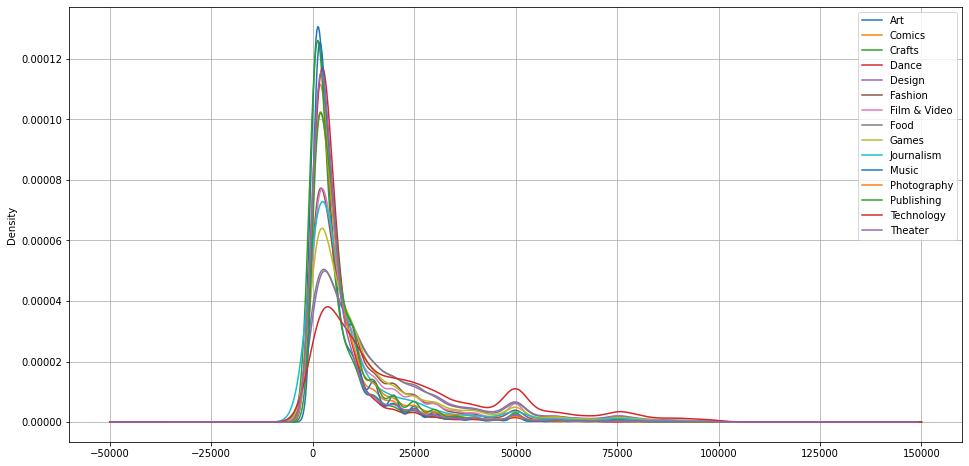

In [ ]:
plt.figure(figsize=(16,8))
kickstarter_cut.groupby('main_category')['usd_goal_real'].plot.density()
plt.legend()
plt.grid()
plt.show()

Per quanto riguarda l'obiettivo, si ottengono valori di asimmetria sufficiente bassi senza rimuovere troppi record. Il valore più basso è dato dalla categoria "Technology".

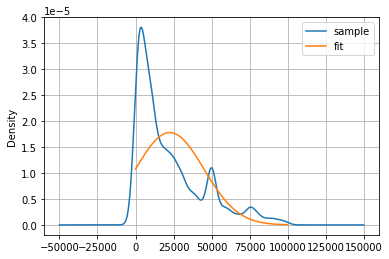

In [ ]:
sample = kickstarter_cut[kickstarter_cut['main_category']=='Technology']['usd_goal_real']
pd.Series(sample).plot.density()
g=norm(*norm.fit(sample))
x=np.linspace(sample.min(),sample.max(),100)
plt.plot(x,g.pdf(x))
plt.grid()
plt.legend(['sample','fit'])
plt.show()

La distribuzione è sbilanciata a sinistra, un buon fitting potrebbe essere dato dalla distribuzione gamma.

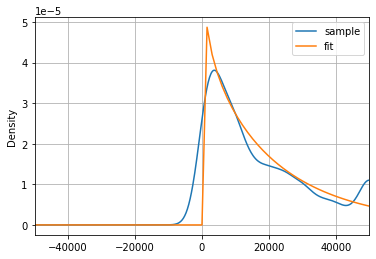

In [ ]:
sample = kickstarter_cut[kickstarter_cut['main_category']=='Technology']['usd_goal_real']
pd.Series(sample).plot.density()
g=gamma(*gamma.fit(sample))
x=np.linspace(-50000,sample.max(),100)
plt.plot(x,g.pdf(x))
plt.grid()
plt.xlim(-50000,50000)
plt.legend(['sample','fit'])
plt.show()

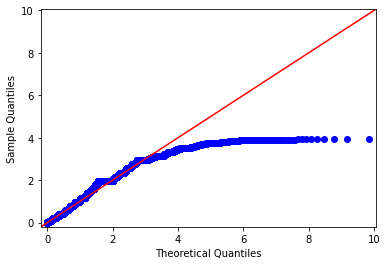

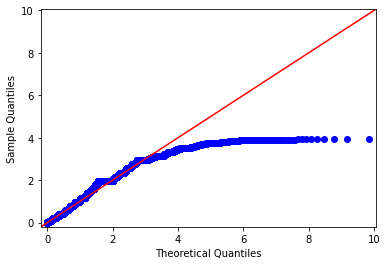

In [ ]:
qqplot(sample, dist=gamma, fit=True, line='45')

Stando al qqplot, fino a quasi il quarantesimo percentile c'è un buon fitting.

# 5. Previsioni con la regressione lineare

### 5.1 Previsione dei fondi finali

Come si è visto prima, la correlazione principale si ha tra il numero di backer e i fondi finali.

In [ ]:
kickstarter_cut.corr(method='pearson')

backers  usd_pledged_real  ...  contains_excl  uppercase_num
backers           1.000000          0.752539  ...      -0.000228       0.015447
usd_pledged_real  0.752539          1.000000  ...      -0.004921       0.019349
usd_goal_real     0.004517          0.005596  ...      -0.001804      -0.000280
name_length       0.020532          0.028966  ...       0.160933       0.364196
days_duration    -0.000792          0.000946  ...       0.001636       0.005083
contains_excl    -0.000228         -0.004921  ...       1.000000       0.077820
uppercase_num     0.015447          0.019349  ...       0.077820       1.000000

[7 rows x 7 columns]

In [ ]:
model = ols('usd_pledged_real ~ backers + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num', kickstarter).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                 8.251e+04
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        09:27:13   Log-Likelihood:            -4.7025e+06
No. Observations:              378650   AIC:                         9.405e+06
Df Residuals:                  378643   BIC:                         9.405e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3601.5647    348.153    -10.345      0.000   -4283.933   -2919.196
backers          75.4329      0.107    702.925      0.000      75.223      75.643
usd_goal_real     0.0002   8.44e-05      1.931      0.054   -2.49e-06       0.000
name_length      76.0724      6.629     11.475      0.000      63.079      89.066
days_duration    55.7520      7.612      7.324      0.000      40.832      70.672
contains_excl -2258.8629    340.951     -6.625      0.000   -2927.117   -1590.609
uppercase_num    59.4146     20.789      2.858      0.004      18.669     100.160
==============================================================================
Omnibus:                  1374657.748   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    3898464148915.019
Skew:                          75.046   Prob(JB):                         0.00
Kurtosis:                   15721.591   Cond. No.                     4.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Il regressore ottenuto presenta un $R^2$ non molto alto, ma i p-value sono abbastanza bassi. Proviamo a prevedere i fondi finali di una campagna recente, ad esempio questa: https://www.kickstarter.com/projects/13233511/human-punishment-the-beginning

Al momento della stesura di questo paragrafo, ha 2802 backers e 232342 dollari raccolti. L'obiettivo era 30249 dollari.

In [ ]:
model.predict({'backers':2801, 'usd_goal_real':30249, 'name_length':31, 'days_duration': 30, 'contains_excl': 0, 'uppercase_num': 4})

0    211959.477007
dtype: float64

Il valore predetto si discosta di 20000 dal valore attuale.

Per migliorare il modello si potrebbero trasformare le variabili categoriche in variabili dummy.

In [ ]:
kickstarter_mod = pd.get_dummies(kickstarter, columns=['main_category'], drop_first=True)
kickstarter_mod.head()

ID  ... main_category_Theater
0  1000002330  ...                     0
1  1000003930  ...                     0
2  1000004038  ...                     0
3  1000007540  ...                     0
4  1000011046  ...                     0

[5 rows x 30 columns]

In [ ]:
kickstarter_mod = kickstarter_mod.rename({'main_category_Film & Video': 'main_category_Film'}, axis=1)

In [ ]:
kickstarter_mod['country'] = kickstarter_mod['country'].replace({'N,0"':'NO'})
kickstarter_mod = pd.get_dummies(kickstarter_mod, columns=['country'], drop_first=True)
kickstarter_mod.columns

Index(['ID', 'name', 'category', 'currency', 'deadline', 'launched', 'state',
       'backers', 'usd_pledged_real', 'usd_goal_real', 'launched_year',
       'days_duration', 'name_length', 'contains_excl', 'uppercase_num',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion', 'main_category_Film',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AU', 'country_BE', 'country_CA',
       'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR',
       'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP',
       'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ',
       'country_SE', 'country_SG', 'country_US'],
      dtype='object')

In [ ]:
model = ols('usd_pledged_real ~ backers + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_CH + country_DE + country_DK + country_ES + country_FR + country_GB + country_HK + country_IE + country_IT + country_JP + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', kickstarter_mod).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                 1.213e+04
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:05:03   Log-Likelihood:            -4.7021e+06
No. Observations:              378657   AIC:                         9.404e+06
Df Residuals:                  378615   BIC:                         9.405e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1188.9248   1002.856      1.186      0.236    -776.643    3154.493
backers                      75.3919      0.108    699.787      0.000      75.181      75.603
usd_goal_real                 0.0001   8.43e-05      1.592      0.111    -3.1e-05       0.000
name_length                  59.2336      6.709      8.829      0.000      46.084      72.383
days_duration                 1.5051      1.475      1.020      0.308      -1.386       4.397
contains_excl             -1922.4333    343.828     -5.591      0.000   -2596.325   -1248.541
uppercase_num                72.5544     20.880      3.475      0.001      31.630     113.479
main_category_Comics      -3516.4239    677.195     -5.193      0.000   -4843.706   -2189.141
main_category_Crafts       -251.9868    730.535     -0.345      0.730   -1683.814    1179.841
main_category_Dance          69.9447   1037.845      0.067      0.946   -1964.201    2104.090
main_category_Design       5889.4150    498.267     11.820      0.000    4912.826    6866.004
main_category_Fashion       980.5428    533.423      1.838      0.066     -64.950    2026.036
main_category_Film         1218.3943    429.594      2.836      0.005     376.403    2060.385
main_category_Food         1124.3589    522.431      2.152      0.031     100.410    2148.308
main_category_Games       -3037.6297    480.061     -6.328      0.000   -3978.534   -2096.725
main_category_Journalism   -250.2839    938.052     -0.267      0.790   -2088.838    1588.271
main_category_Music        -351.5124    446.537     -0.787      0.431   -1226.712     523.687
main_category_Photography   513.6279    677.944      0.758      0.449    -815.123    1842.379
main_category_Publishing  -1093.0155    466.060     -2.345      0.019   -2006.480    -179.551
main_category_Technology   8557.5389    489.233     17.492      0.000    7598.657    9516.421
main_category_Theater       274.9765    675.717      0.407      0.684   -1049.409    1599.361
country_AU                -5534.1246   1138.112     -4.863      0.000   -7764.791   -3303.458
country_BE                -2315.0373   2576.279     -0.899      0.369   -7364.468    2734.393
country_CA                -5303.5739   1038.892     -5.105      0.000   -7339.772   -3267.376
country_CH                 3604.9325   2355.449      1.530      0.126   -1011.677    8221.542
country_DE                -3714.6632   1303.771     -2.849      0.004   -6270.016   -1159.310
country_DK                -4013.9084   2012.958     -1.994      0.046   -7959.246     -68.571
country_ES                -4736.2638   1553.858     -3.048      0.002   -7781.780   -1690.748
country_FR                -2931.8445   1435.114     -2.043      0.041   -5744.625    -119.064
country_GB                -3913.3469    970.317     -4.033      0.000   -58

Anche il numero di backer solitamente non è noto a priori, ma rimuovendolo dal modello si ha un regressore molto scadente.

In [ ]:
model = ols('usd_pledged_real ~ usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_CH + country_DE + country_DK + country_ES + country_FR + country_GB + country_HK + country_IE + country_IT + country_JP + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', kickstarter_mod).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     83.80
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:05:23   Log-Likelihood:            -4.8593e+06
No. Observations:              378657   AIC:                         9.719e+06
Df Residuals:                  378616   BIC:                         9.719e+06
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -2169.2040   1518.704     -1.428      0.153   -5145.819     807.411
usd_goal_real                 0.0004      0.000      2.959      0.003       0.000       0.001
name_length                 124.2775     10.159     12.233      0.000     104.365     144.190
days_duration                 0.8825      2.234      0.395      0.693      -3.497       5.262
contains_excl             -2565.4439    520.690     -4.927      0.000   -3585.980   -1544.908
uppercase_num               211.0998     31.620      6.676      0.000     149.126     273.073
main_category_Comics       3319.3885   1025.436      3.237      0.001    1309.565    5329.212
main_category_Crafts      -1006.6991   1106.319     -0.910      0.363   -3175.051    1161.653
main_category_Dance        -314.8933   1571.709     -0.200      0.841   -3395.396    2765.609
main_category_Design       2.082e+04    753.882     27.618      0.000    1.93e+04    2.23e+04
main_category_Fashion      2563.5006    807.806      3.173      0.002     980.224    4146.777
main_category_Film         3095.3731    650.563      4.758      0.000    1820.289    4370.457
main_category_Food         2078.8955    791.165      2.628      0.009     528.236    3629.555
main_category_Games        1.859e+04    725.494     25.624      0.000    1.72e+04       2e+04
main_category_Journalism   -242.7009   1420.583     -0.171      0.864   -3027.002    2541.600
main_category_Music          67.7235    676.234      0.100      0.920   -1257.674    1393.121
main_category_Photography   565.3898   1026.676      0.551      0.582   -1446.865    2577.645
main_category_Publishing   -213.8598    705.798     -0.303      0.762   -1597.202    1169.483
main_category_Technology   1.816e+04    740.601     24.515      0.000    1.67e+04    1.96e+04
main_category_Theater       226.1900   1023.303      0.221      0.825   -1779.454    2231.834
country_AU                -5540.6265   1723.553     -3.215      0.001   -8918.740   -2162.513
country_BE                -4748.0342   3901.505     -1.217      0.224   -1.24e+04    2898.799
country_CA                -4474.0121   1573.294     -2.844      0.004   -7557.621   -1390.403
country_CH                 3149.4522   3567.084      0.883      0.377   -3841.926    1.01e+04
country_DE                -3917.8515   1974.427     -1.984      0.047   -7787.669     -48.034
country_DK                -4722.0467   3048.416     -1.549      0.121   -1.07e+04    1252.758
country_ES                -7248.1511   2353.151     -3.080      0.002   -1.19e+04   -2636.044
country_FR                -1358.1390   2173.329     -0.625      0.532   -5617.799    2901.521
country_GB                -2446.8875   1469.441     -1.665      0.096   -5326.948     433.173
country_HK                -3387.8819   3906.525     -0.867      0.386    -1

Nonostante il numero di informazioni disponibili sulla campagna, non c'è abbastanza correlazione per poter prevedere adeguatamente i fondi finali senza il numero dei backer.

Si suppone che si disponga di una stima di questo valore, calcolato ad esempio facendo una sovrastima del valore attuale se la campagna è in corso oppure con dei sondaggi esterni a Kickstarter.

In qualunque caso, il valore di $R^2$ dopo l'introduzione delle variabili dummy è aumentato di appena 0.001, quindi non vale la pena di usarle perché si complica notevolmente il modello.

Dato che si vogliono prevedere i fondi finali per le campagne in corso, bisogna allenare il regressore con le informazioni sulle campagne terminate.

In [ ]:
kickstarter_ended = kickstarter[(kickstarter['state']=='failed') | (kickstarter['state']=='successful')]

In [ ]:
model = ols('usd_pledged_real ~ backers + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num', kickstarter_ended).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                 7.217e+04
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:10:31   Log-Likelihood:            -4.1396e+06
No. Observations:              331672   AIC:                         8.279e+06
Df Residuals:                  331665   BIC:                         8.279e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4080.5245    393.957    -10.358      0.000   -4852.668   -3308.381
backers          75.3358      0.115    657.267      0.000      75.111      75.560
usd_goal_real     0.0002   9.98e-05      2.025      0.043    6.45e-06       0.000
name_length      86.6131      7.527     11.508      0.000      71.861     101.365
days_duration    64.0830      8.705      7.362      0.000      47.022      81.144
contains_excl -2536.8522    385.863     -6.574      0.000   -3293.132   -1780.572
uppercase_num    61.1822     23.731      2.578      0.010      14.671     107.694
==============================================================================
Omnibus:                  1183262.647   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    2718433858702.640
Skew:                          71.195   Prob(JB):                         0.00
Kurtosis:                   14027.527   Cond. No.                     3.96e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.96e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I regressori ottenuti continuano ad essere deboli. Regressori più efficaci si possono trovare specializzandoli per categorie.

In [ ]:
kickstarter_cat = kickstarter_ended[kickstarter_ended['category']=='Video Games']
model = ols('usd_pledged_real ~ backers + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num', kickstarter_cat).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     9903.
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:10:46   Log-Likelihood:            -1.1615e+05
No. Observations:                9327   AIC:                         2.323e+05
Df Residuals:                    9320   BIC:                         2.324e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7389.7057   2369.116     -3.119      0.002    -1.2e+04   -2745.720
backers          55.8052      0.229    243.408      0.000      55.356      56.255
usd_goal_real     0.0013      0.001      2.243      0.025       0.000       0.003
name_length      34.1309     47.302      0.722      0.471     -58.591     126.852
days_duration    85.9036     58.822      1.460      0.144     -29.401     201.208
contains_excl -1749.0717   2592.742     -0.675      0.500   -6831.413    3333.269
uppercase_num    91.3308    195.478      0.467      0.640    -291.849     474.511
==============================================================================
Omnibus:                    18963.505   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        172781660.477
Skew:                          16.369   Prob(JB):                         0.00
Kurtosis:                     668.977   Cond. No.                     4.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Applichiamo la backwards elimination, cominciando dal rimuovere "uppercase_num" dal modello.

In [ ]:
model = ols('usd_pledged_real ~ backers + usd_goal_real + name_length + days_duration + contains_excl', kickstarter_cat).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 1.188e+04
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:13:25   Log-Likelihood:            -1.1615e+05
No. Observations:                9327   AIC:                         2.323e+05
Df Residuals:                    9321   BIC:                         2.324e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7304.5625   2361.998     -3.093      0.002   -1.19e+04   -2674.531
backers          55.8069      0.229    243.454      0.000      55.358      56.256
usd_goal_real     0.0013      0.001      2.241      0.025       0.000       0.003
name_length      46.0043     39.893      1.153      0.249     -32.196     124.204
days_duration    86.1093     58.818      1.464      0.143     -29.187     201.406
contains_excl -1752.1272   2592.625     -0.676      0.499   -6834.239    3329.985
==============================================================================
Omnibus:                    18962.798   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        172747980.478
Skew:                          16.368   Prob(JB):                         0.00
Kurtosis:                     668.912   Cond. No.                     4.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
model = ols('usd_pledged_real ~ backers + usd_goal_real + name_length + days_duration', kickstarter_cat).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 1.486e+04
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:14:05   Log-Likelihood:            -1.1615e+05
No. Observations:                9327   AIC:                         2.323e+05
Df Residuals:                    9322   BIC:                         2.323e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7253.0745   2360.700     -3.072      0.002   -1.19e+04   -2625.587
backers          55.8068      0.229    243.461      0.000      55.357      56.256
usd_goal_real     0.0013      0.001      2.246      0.025       0.000       0.003
name_length      40.2790     38.982      1.033      0.302     -36.135     116.693
days_duration    85.8106     58.815      1.459      0.145     -29.480     201.101
==============================================================================
Omnibus:                    18963.747   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        172789509.895
Skew:                          16.370   Prob(JB):                         0.00
Kurtosis:                     668.992   Cond. No.                     3.95e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
model = ols('usd_pledged_real ~ backers + usd_goal_real + days_duration', kickstarter_cat).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 1.981e+04
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:14:24   Log-Likelihood:            -1.1616e+05
No. Observations:                9328   AIC:                         2.323e+05
Df Residuals:                    9324   BIC:                         2.324e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6118.0610   2090.397     -2.927      0.003   -1.02e+04   -2020.427
backers          55.8050      0.229    243.472      0.000      55.356      56.254
usd_goal_real     0.0013      0.001      2.246      0.025       0.000       0.003
days_duration    86.0652     58.805      1.464      0.143     -29.205     201.335
==============================================================================
Omnibus:                    18964.930   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        172789636.741
Skew:                          16.368   Prob(JB):                         0.00
Kurtosis:                     668.957   Cond. No.                     3.49e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
model = ols('usd_pledged_real ~ backers + usd_goal_real', kickstarter_cat).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 2.971e+04
Date:                Mon, 01 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:14:42   Log-Likelihood:            -1.1617e+05
No. Observations:                9328   AIC:                         2.323e+05
Df Residuals:                    9325   BIC:                         2.324e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3210.6655    650.874     -4.933      0.000   -4486.521   -1934.810
backers          55.7990      0.229    243.470      0.000      55.350      56.248
usd_goal_real     0.0014      0.001      2.298      0.022       0.000       0.003
==============================================================================
Omnibus:                    18965.934   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        172692821.093
Skew:                          16.370   Prob(JB):                         0.00
Kurtosis:                     668.770   Cond. No.                     1.09e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Solo l'obiettivo e il numero di backers ha un'influenza significativa sul valore finale.

In [ ]:
kickstarter[(kickstarter['state']=='live') & (kickstarter['category']=='Video Games')].sort_values(by='backers', ascending=False).head()

ID  ... uppercase_num
267852   432841131  ...             2
168434  1856882778  ...             7
222431  2133169674  ...             6
341298   808421307  ...             5
348795   847043776  ...             2

[5 rows x 17 columns]

In [ ]:
model.predict({'backers':1509, 'usd_goal_real':55000.00})

0    81065.844846
dtype: float64

I fondi finali raccolti erano 88950.

Nelle categorie in cui la correlazione tra "usd_goal_real" e "usd_pledged_real" era significativa si ottiene un valore di $R^2$ molto alto.

In [ ]:
kickstarter_cat = kickstarter_ended[kickstarter_ended['category']=='Chiptune']
model_chiptune = ols('usd_pledged_real ~ backers + usd_goal_real + name_length + days_duration + contains_excl', kickstarter_cat).fit()
model_chiptune.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     1617.
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           1.50e-32
Time:                        10:16:24   Log-Likelihood:                -310.60
No. Observations:                  33   AIC:                             633.2
Df Residuals:                      27   BIC:                             642.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3345.2976   3041.017     -1.100      0.281   -9584.949    2894.353
backers          32.7390      0.606     53.982      0.000      31.495      33.983
usd_goal_real     0.7518      0.070     10.702      0.000       0.608       0.896
name_length     -19.0521     53.213     -0.358      0.723    -128.237      90.133
days_duration    54.9016     52.149      1.053      0.302     -52.099     161.902
contains_excl   623.5694   1420.883      0.439      0.664   -2291.841    3538.980
==============================================================================
Omnibus:                       11.141   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               10.423
Skew:                          -1.117   Prob(JB):                      0.00545
Kurtosis:                       4.608   Cond. No.                     7.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Le colonne "name_length" e "contains_excl" hanno un p-value molto alto.

In [ ]:
model_chiptune = ols('usd_pledged_real ~ backers + usd_goal_real + days_duration', kickstarter_cat).fit()
model_chiptune.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2868.
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           5.94e-36
Time:                        10:17:17   Log-Likelihood:                -310.75
No. Observations:                  33   AIC:                             629.5
Df Residuals:                      29   BIC:                             635.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3848.2221   1834.040     -2.098      0.045   -7599.255     -97.189
backers          32.7639      0.578     56.724      0.000      31.583      33.945
usd_goal_real     0.7474      0.068     11.067      0.000       0.609       0.885
days_duration    49.1881     48.640      1.011      0.320     -50.291     148.668
==============================================================================
Omnibus:                       13.885   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.910
Skew:                          -1.253   Prob(JB):                     0.000579
Kurtosis:                       5.135   Cond. No.                     4.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
model_chiptune = ols('usd_pledged_real ~ backers + usd_goal_real', kickstarter_cat).fit()
model_chiptune.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     4298.
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           1.32e-37
Time:                        10:17:38   Log-Likelihood:                -311.32
No. Observations:                  33   AIC:                             628.6
Df Residuals:                      30   BIC:                             633.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2116.7802    657.729     -3.218      0.003   -3460.042    -773.518
backers          32.7317      0.577     56.733      0.000      31.553      33.910
usd_goal_real     0.7471      0.068     11.059      0.000       0.609       0.885
==============================================================================
Omnibus:                       13.371   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.761
Skew:                          -1.255   Prob(JB):                      0.00103
Kurtosis:                       4.926   Cond. No.                     1.64e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Anche questa volta, rimuovere tutte le feature tranne "backers" e "usd_goal_real" non ha influenzato molto il valore di $R^2$. Proviamo il modello su due progetti più recenti: https://www.kickstarter.com/projects/1899688657/project-atma-i-fight-dragons-creates-an-epic-new-a

https://www.kickstarter.com/projects/amicomretrobooks/hessian-commodore-64-chiptune-game-soundtrack-on-vinyl

In [ ]:
model_chiptune.predict({'backers':3423, 'usd_goal_real':20000.00})

0    124865.315166
dtype: float64

In [ ]:
model_chiptune.predict({'backers':245, 'usd_goal_real':10315.60})

0    13609.016828
dtype: float64

I fondi effettivi raggiunti sono rispettivamente 115052 e 14894.51.

### 5.2 Previsione delle statistiche su Steam

Il seguente dataset su Kaggle contiene informazioni sui videogiochi che hanno avuto campagne terminate con successo su Kickstarter e sono poi usciti su Steam: https://www.kaggle.com/tonyplaysguitar/steam-spy-data-from-api-request

Tra le informazioni presenti ci sono anche il numero di possessori di ogni videogioco: si potrebbe prevedere utilizzando le informazioni della campagna.

In [ ]:
ksreleased = pd.read_csv('/content/drive/My Drive/KSreleased.csv')
ksreleased.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   appid   223 non-null    int64 
 1   ksid    223 non-null    int64 
 2   ksurl   223 non-null    object
dtypes: int64(2), object(1)
memory usage: 5.4+ KB


In [ ]:
steam = pd.read_csv('/content/drive/My Drive/SteamSpy.csv')
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17087 entries, 0 to 17086
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     17087 non-null  int64  
 1   average_2weeks            17087 non-null  int64  
 2   average_forever           17087 non-null  int64  
 3   developer                 16462 non-null  object 
 4   median_2weeks             17087 non-null  int64  
 5   median_forever            17087 non-null  int64  
 6   name                      17079 non-null  object 
 7   negative                  17087 non-null  int64  
 8   owners                    17087 non-null  int64  
 9   owners_variance           17087 non-null  int64  
 10  players_2weeks            17087 non-null  int64  
 11  players_2weeks_variance   17087 non-null  int64  
 12  players_forever           17087 non-null  int64  
 13  players_forever_variance  17087 non-null  int64  
 14  positi

In [ ]:
k_games = kickstarter_ended[kickstarter_ended['category']=='Video Games']

In [ ]:
k_games = k_games.rename({'ID': 'ksid'}, axis=1)

In [ ]:
k_games = pd.merge(k_games, ksreleased, on='ksid')

In [ ]:
k_games.head()

ksid  ...                                              ksurl
0  1006008989  ...  /projects/subterraneangames/war-for-the-overwo...
1  1014632933  ...  /projects/56637190/dungeonmans-the-heroic-adve...
2  1014993943  ...  /projects/reynoldsphobia/nevermind-biofeedback...
3  1021808822  ...  /projects/312751524/rhythm-destruction-a-rhyth...
4  1049522400  ...  /projects/inbetweengames/all-walls-must-fall-a...

[5 rows x 19 columns]

In [ ]:
k_games = k_games.dropna(subset=['appid'])

In [ ]:
k_games = pd.merge(k_games, steam, on='appid')

In [ ]:
k_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ksid                      221 non-null    int64         
 1   name_x                    221 non-null    object        
 2   category                  221 non-null    object        
 3   main_category             221 non-null    object        
 4   currency                  221 non-null    object        
 5   deadline                  221 non-null    datetime64[ns]
 6   launched                  221 non-null    datetime64[ns]
 7   state                     221 non-null    object        
 8   backers                   221 non-null    int64         
 9   country                   221 non-null    object        
 10  usd_pledged_real          221 non-null    float64       
 11  usd_goal_real             221 non-null    float64       
 12  launched_year         

In [ ]:
k_games = k_games.drop(['name_y', 'ksurl', 'average_2weeks', 'average_forever', 'developer', 'median_2weeks', 'median_forever', 'negative', 'owners_variance', 'players_2weeks_variance', 'publisher'], axis=1)

In [ ]:
k_games.dropna(subset=['owners'])
k_games.head()

ksid  ... userscore
0  1006008989  ...        79
1  1014632933  ...        90
2  1014993943  ...        71
3  1021808822  ...        68
4  1049522400  ...        96

[5 rows x 26 columns]

In [ ]:
k_games.corr()

ksid   backers  ...  score_rank  userscore
ksid                      1.000000  0.040780  ...   -0.060707  -0.087787
backers                   0.040780  1.000000  ...    0.041190   0.072279
usd_pledged_real          0.024395  0.956944  ...   -0.005929   0.037164
usd_goal_real             0.068167  0.693612  ...   -0.107489  -0.029405
launched_year            -0.041709 -0.053626  ...    0.104912   0.027013
days_duration            -0.047196 -0.046766  ...   -0.053140  -0.149898
name_length               0.008802 -0.137468  ...    0.045062   0.045531
contains_excl            -0.056616 -0.031132  ...   -0.022017   0.032943
uppercase_num             0.040713 -0.081147  ...   -0.106588  -0.027536
appid                     0.001306 -0.041605  ...    0.111247   0.015081
owners                    0.099011  0.147457  ...    0.282711   0.242270
players_2weeks            0.103762  0.097232  ...    0.275429   0.207917
players_forever           0.086327  0.149519  ...    0.288181   0.237748
players_forever_variance  0.074083  0.253489  ...    0.370292   0.318018
positive                  0.099792  0.161942  ...    0.324286   0.250723
price                    -0.052538  0.382478  ...    0.242938   0.204282
score_rank               -0.060707  0.041190  ...    1.000000   0.869845
userscore                -0.087787  0.072279  ...    0.869845   1.000000

[18 rows x 18 columns]

In generale, c'è scarsa correlazione tra le feature del dataset di Steam e quelle del dataset di Kickstarter. I valori più alti si hanno in corrispondenza del prezzo.

In [ ]:
model_steam = ols('owners ~ backers + usd_pledged_real + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num', k_games).fit()
model_steam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 owners   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.214
Date:                Mon, 01 Feb 2021   Prob (F-statistic):              0.296
Time:                        10:21:13   Log-Likelihood:                -3260.7
No. Observations:                 221   AIC:                             6537.
Df Residuals:                     213   BIC:                             6565.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          3.33e+05   2.29e+05      1.451      0.148   -1.19e+05    7.85e+05
backers             19.8450     13.921      1.426      0.155      -7.596      47.286
usd_pledged_real    -0.2987      0.327     -0.913      0.362      -0.944       0.346
usd_goal_real        0.1442      0.341      0.423      0.673      -0.528       0.816
name_length      -1585.3800   3332.562     -0.476      0.635   -8154.406    4983.646
days_duration     1321.5819   6309.601      0.209      0.834   -1.11e+04    1.38e+04
contains_excl    -1.106e+05   2.08e+05     -0.533      0.595    -5.2e+05    2.99e+05
uppercase_num    -1.231e+04   1.47e+04     -0.837      0.404   -4.13e+04    1.67e+04
==============================================================================
Omnibus:                      243.588   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8509.826
Skew:                           4.506   Prob(JB):                         0.00
Kurtosis:                      32.033   Cond. No.                     4.00e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Il valore di $R^2$ è bassissimo e i p-value associati alle feature molto alti. Non ci sono abbastanza informazioni per prevedere adeguatamente le vendite su Steam.

In [ ]:
model_steamprice = ols('price ~ backers + usd_pledged_real + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num', k_games).fit()
model_steamprice.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     6.708
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           3.45e-07
Time:                        10:21:49   Log-Likelihood:                -1798.4
No. Observations:                 221   AIC:                             3613.
Df Residuals:                     213   BIC:                             3640.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          847.1095    306.885      2.760      0.006     242.188    1452.031
backers              0.0116      0.019      0.624      0.533      -0.025       0.048
usd_pledged_real     0.0002      0.000      0.499      0.618      -0.001       0.001
usd_goal_real        0.0005      0.000      1.152      0.251      -0.000       0.001
name_length          6.2858      4.458      1.410      0.160      -2.502      15.073
days_duration        8.2568      8.441      0.978      0.329      -8.381      24.895
contains_excl      -78.8364    277.743     -0.284      0.777    -626.312     468.640
uppercase_num       -6.2023     19.679     -0.315      0.753     -44.993      32.588
==============================================================================
Omnibus:                        3.733   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                3.734
Skew:                           0.177   Prob(JB):                        0.155
Kurtosis:                       3.529   Cond. No.                     4.00e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Il modello per prevedere il prezzo del gioco su Steam è un po' migliore, ma comunque inaccettabile.

In realtà il dataset contiene dati di prezzi in valute diverse, quindi andrebbe corretto di conseguenza. Limitandosi a giochi con prezzi espressi in USD si ha un modello leggermente migliore:

In [ ]:
k_gamesusd = k_games[k_games['currency']=='USD']

In [ ]:
model_steamprice = ols('price ~ backers + usd_pledged_real + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num', k_gamesusd).fit()
model_steamprice.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     6.432
Date:                Mon, 01 Feb 2021   Prob (F-statistic):           8.81e-07
Time:                        10:22:22   Log-Likelihood:                -1561.5
No. Observations:                 192   AIC:                             3139.
Df Residuals:                     184   BIC:                             3165.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          720.0699    323.984      2.223      0.027      80.868    1359.272
backers              0.0024      0.019      0.127      0.899      -0.035       0.040
usd_pledged_real     0.0004      0.000      0.812      0.418      -0.001       0.001
usd_goal_real        0.0007      0.001      1.276      0.203      -0.000       0.002
name_length          6.3825      4.873      1.310      0.192      -3.232      15.997
days_duration       10.5276      8.814      1.194      0.234      -6.861      27.916
contains_excl      -64.6010    292.929     -0.221      0.826    -642.532     513.330
uppercase_num       -5.4269     20.976     -0.259      0.796     -46.811      35.957
==============================================================================
Omnibus:                        3.119   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.959
Skew:                           0.164   Prob(JB):                        0.228
Kurtosis:                       3.512   Cond. No.                     4.02e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
k_gamesgbp = k_games[k_games['currency']=='GBP']

In [ ]:
model_steamprice = ols('price ~ backers + usd_pledged_real + usd_goal_real + name_length + days_duration + uppercase_num + contains_excl', k_gamesgbp).fit()
model_steamprice.summary()

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     3.978
Date:                Mon, 01 Feb 2021   Prob (F-statistic):             0.0738
Time:                        10:22:44   Log-Likelihood:                -94.336
No. Observations:                  13   AIC:                             204.7
Df Residuals:                       5   BIC:                             209.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -343.9426   3223.929     -0.107      0.919   -8631.317    7943.432
backers              0.1098      0.124      0.884      0.417      -0.209       0.429
usd_pledged_real     0.0163      0.007      2.414      0.061      -0.001       0.034
usd_goal_real       -0.0222      0.008     -2.955      0.032      -0.041      -0.003
name_length          5.9238     16.070      0.369      0.728     -35.385      47.233
days_duration       68.0198     91.378      0.744      0.490    -166.875     302.915
uppercase_num     -189.1879    121.065     -1.563      0.179    -500.396     122.020
contains_excl     -451.6185    712.693     -0.634      0.554   -2283.655    1380.418
==============================================================================
Omnibus:                        1.236   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.539   Jarque-Bera (JB):                0.380
Skew:                           0.419   Prob(JB):                        0.827
Kurtosis:                       3.021   Cond. No.                     2.10e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Per i giochi in sterline si ha un $R^2$ molto elevato, ma non è un modello adatto perché ha appena 13 record.

In [ ]:
ks_steam = pd.merge(ksreleased, steam, on='appid')
ks_steam.sample()

appid       ksid  ... score_rank  userscore
69  359320  880009511  ...       28.0         68

[1 rows x 21 columns]

In [ ]:
kickstarter[kickstarter['ID']==880009511]

ID              name  ... days_duration name_length
355330  880009511  Elite: Dangerous  ...            60        16.0

[1 rows x 14 columns]

In [ ]:
model_steam.predict(kickstarter[kickstarter['ID']==880009511])

355330    376761.270387
dtype: float64

In [ ]:
model_steamprice.predict(kickstarter[kickstarter['ID']==880009511])

355330    3850.992134
dtype: float64

Sia il numero di possessori che il prezzo sono sovrastimati, ma il prezzo un po' meno.

# 6. Classificazione

## 6.1 Regressione logistica

### 6.1.1 Introduzione

Possiamo usare la regressione logistica per prevedere se una campagna fallirà o meno. 

In [ ]:
kickstarter_ended['state']=kickstarter_ended['state'].replace({'failed':0, 'successful':1})
kickstarter_mod['state']=kickstarter_mod['state'].replace({'failed':0, 'successful':1})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
kickstarter_ended['state'].value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

Le due classi sono abbastanza bilanciate.

In [ ]:
model_logit = logit('state ~ usd_pledged_real + usd_goal_real + launched_year + days_duration + name_length + uppercase_num + contains_excl', kickstarter_ended).fit()
model_logit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.005859
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:               331672
Model:                          Logit   Df Residuals:                   331664
Method:                           MLE   Df Model:                            7
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                  0.9913
Time:                        10:10:58   Log-Likelihood:                -1943.3
converged:                      False   LL-Null:                   -2.2373e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          159.4467     52.382      3.044      0.002      56.780     262.113
usd_pledged_real     0.1260      0.003     41.427      0.000       0.120       0.132
usd_goal_real       -0.1250      0.003    -41.379      0.000      -0.131      -0.119
launched_year       -0.0785      0.026     -3.021      0.003      -0.129      -0.028
days_duration       -0.0071      0.003     -2.207      0.027      -0.013      -0.001
name_length          0.0206      0.003      5.938      0.000       0.014       0.027
uppercase_num        0.0277      0.013      2.126      0.033       0.002       0.053
contains_excl       -0.0366      0.154     -0.237      0.813      -0.339       0.266
====================================================================================

Possibly complete quasi-separation: A fraction 0.95 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Il valore dello pseudo-$R^2$ è altissimo, ma il valore finale dei fondi è non noto nel problema di determinare se una campagna avrà successo o meno.

Rimuoviamolo dalla stima e introduciamo le variabili dummies per le categorie.

In [ ]:
kickstarter_mod = pd.get_dummies(kickstarter_ended, columns=['main_category'], drop_first=True)
kickstarter_mod = kickstarter_mod.rename({'main_category_Film & Video': 'main_category_Film'}, axis=1)

In [ ]:
kickstarter_mod['country'] = kickstarter_mod['country'].replace({'N,0"':'NO'})
kickstarter_mod = pd.get_dummies(kickstarter_mod, columns=['country'], drop_first=True)

In [ ]:
model_logit = logit('state ~ backers + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_CH + country_DE + country_DK + country_ES + country_FR + country_GB + country_HK + country_IE + country_IT + country_JP + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', kickstarter_mod).fit()
model_logit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.316506
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:               331672
Model:                          Logit   Df Residuals:                   331630
Method:                           MLE   Df Model:                           41
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.5308
Time:                        10:29:48   Log-Likelihood:            -1.0498e+05
converged:                       True   LL-Null:                   -2.2373e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2678      0.110      2.429      0.015       0.052       0.484
backers                       0.0549      0.000    229.710      0.000       0.054       0.055
usd_goal_real                -0.0002   1.27e-06   -180.416      0.000      -0.000      -0.000
name_length                   0.0053      0.000     13.986      0.000       0.005       0.006
days_duration                -0.0127      0.000    -29.663      0.000      -0.014      -0.012
contains_excl                 0.0851      0.019      4.578      0.000       0.049       0.122
uppercase_num                 0.0100      0.001      8.298      0.000       0.008       0.012
main_category_Comics         -0.5004      0.036    -13.852      0.000      -0.571      -0.430
main_category_Crafts         -0.6659      0.036    -18.246      0.000      -0.737      -0.594
main_category_Dance           0.7002      0.048     14.710      0.000       0.607       0.793
main_category_Design         -0.6730      0.029    -23.109      0.000      -0.730      -0.616
main_category_Fashion        -0.6033      0.028    -21.368      0.000      -0.659      -0.548
main_category_Film            0.2543      0.021     12.307      0.000       0.214       0.295
main_category_Food           -0.4575      0.029    -15.714      0.000      -0.515      -0.400
main_category_Games          -1.5415      0.031    -49.595      0.000      -1.602      -1.481
main_category_Journalism     -0.6320      0.053    -11.913      0.000      -0.736      -0.528
main_category_Music           0.1257      0.021      5.979      0.000       0.084       0.167
main_category_Photography    -0.3846      0.033    -11.555      0.000      -0.450      -0.319
main_category_Publishing     -0.5344      0.023    -23.072      0.000      -0.580      -0.489
main_category_Technology     -0.6133      0.032    -19.152      0.000      -0.676      -0.551
main_category_Theater         0.6982      0.032     22.033      0.000       0.636       0.760
country_AU                   -1.0397      0.116     -8.999      0.000      -1.266      -0.813
country_BE                   -0.7102      0.179     -3.969      0.000      -1.061      -0.359
country_CA                   -0.9250      0.112     -8.288      0.000      -1.144      -0.706
country_CH                   -0.0777      0.177     -0.438      0.661      -0.425       0.270
country_DE                   -1.0393      0.124     -8.362      0.000      -1.283      -0.796
country_DK                   -0.5535      0.147     -3.772      0.000      -0.841      -0.266
country_ES                   -1.1493      0.138     -8.312      0.000      -1.420      -0.878
country_FR                   -0.6132      0.127     -4.810      0.000      -0.863      -0.363
country_GB                   -0.7217      0.109     -6.610      0.000      -0.936      -0.508
country_HK                    0.0303      0.183      0.165      0.869      -0.329       0.390
country_IE                   -1.2445      0.1

Si ha uno pseudo-$R^2$ di 0.53, molto inferiore ma tutto sommato accettabile. Alcune delle variabili dummy associate agli stati hanno p-value maggiore di zero.

Verifichiamo la qualità di un regressore logistico che non sfrutta il numero di backers.

In [ ]:
model_logitB = logit('state ~ usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_CH + country_DE + country_DK + country_ES + country_FR + country_GB + country_HK + country_IE + country_IT + country_JP + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', kickstarter_mod).fit()
model_logitB.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.620376
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:               331672
Model:                          Logit   Df Residuals:                   331631
Method:                           MLE   Df Model:                           40
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                 0.08032
Time:                        11:13:19   Log-Likelihood:            -2.0576e+05
converged:                       True   LL-Null:                   -2.2373e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.6868      0.115     -5.966      0.000      -0.912      -0.461
usd_goal_real             -1.489e-05   2.12e-07    -70.402      0.000   -1.53e-05   -1.45e-05
name_length                   0.0134      0.000     51.892      0.000       0.013       0.014
days_duration                -0.0183      0.000    -59.022      0.000      -0.019      -0.018
contains_excl                 0.1220      0.013      9.456      0.000       0.097       0.147
uppercase_num                 0.0141      0.001     17.513      0.000       0.012       0.016
main_category_Comics          0.6170      0.025     25.104      0.000       0.569       0.665
main_category_Crafts         -0.8108      0.029    -28.063      0.000      -0.867      -0.754
main_category_Dance           0.8122      0.038     21.253      0.000       0.737       0.887
main_category_Design          0.0283      0.019      1.522      0.128      -0.008       0.065
main_category_Fashion        -0.6880      0.021    -33.338      0.000      -0.728      -0.648
main_category_Film            0.1033      0.016      6.562      0.000       0.072       0.134
main_category_Food           -0.5862      0.020    -28.977      0.000      -0.626      -0.547
main_category_Games           0.1545      0.018      8.594      0.000       0.119       0.190
main_category_Journalism     -0.8189      0.039    -20.898      0.000      -0.896      -0.742
main_category_Music           0.3073      0.016     19.035      0.000       0.276       0.339
main_category_Photography    -0.4176      0.025    -16.447      0.000      -0.467      -0.368
main_category_Publishing     -0.4264      0.017    -24.799      0.000      -0.460      -0.393
main_category_Technology     -0.6064      0.020    -30.372      0.000      -0.646      -0.567
main_category_Theater         0.7630      0.025     30.686      0.000       0.714       0.812
country_AU                    0.2947      0.117      2.517      0.012       0.065       0.524
country_BE                    0.3368      0.152      2.218      0.027       0.039       0.634
country_CA                    0.4034      0.115      3.494      0.000       0.177       0.630
country_CH                    0.4502      0.146      3.088      0.002       0.164       0.736
country_DE                    0.1862      0.121      1.545      0.122      -0.050       0.422
country_DK                    0.6911      0.134      5.159      0.000       0.429       0.954
country_ES                    0.1521      0.126      1.205      0.228      -0.095       0.400
country_FR                    0.6760      0.122      5.550      0.000       0.437       0.915
country_GB                    0.6380      0.114      5.576      0.000       0.414       0.862
country_HK                    0.9155      0.149      6.137      0.000       0.623       1.208
country_IE                    0.2923      0.143      2.041      0.041       0.012       0.573
country_IT                   -0.2110      0.1

Come per la regressione, rimuovendo il numero dei backers si ottiene un classificatore molto scadente. Anche se il centro di interesse saranno i classificatori che sfruttano il numero di backers, si valuteranno entrambe le tipologie.

### 6.1.2 Con numero di backer

Ritornando al modello precedente, si effettua la backwards elimination, partendo da "country_HK".

In [ ]:
model_logit = logit('state ~ backers + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_CH + country_DE + country_DK + country_ES + country_FR + country_GB + country_IE + country_IT + country_JP + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', kickstarter_mod).fit()
model_logit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.316506
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:               331672
Model:                          Logit   Df Residuals:                   331631
Method:                           MLE   Df Model:                           40
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.5308
Time:                        10:33:27   Log-Likelihood:            -1.0498e+05
converged:                       True   LL-Null:                   -2.2373e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2782      0.090      3.077      0.002       0.101       0.455
backers                       0.0549      0.000    229.727      0.000       0.054       0.055
usd_goal_real                -0.0002   1.27e-06   -180.423      0.000      -0.000      -0.000
name_length                   0.0054      0.000     13.987      0.000       0.005       0.006
days_duration                -0.0127      0.000    -29.663      0.000      -0.014      -0.012
contains_excl                 0.0851      0.019      4.578      0.000       0.049       0.122
uppercase_num                 0.0100      0.001      8.300      0.000       0.008       0.012
main_category_Comics         -0.5004      0.036    -13.852      0.000      -0.571      -0.430
main_category_Crafts         -0.6659      0.036    -18.246      0.000      -0.737      -0.594
main_category_Dance           0.7002      0.048     14.710      0.000       0.607       0.793
main_category_Design         -0.6728      0.029    -23.115      0.000      -0.730      -0.616
main_category_Fashion        -0.6033      0.028    -21.367      0.000      -0.659      -0.548
main_category_Film            0.2543      0.021     12.306      0.000       0.214       0.295
main_category_Food           -0.4575      0.029    -15.715      0.000      -0.515      -0.400
main_category_Games          -1.5416      0.031    -49.595      0.000      -1.602      -1.481
main_category_Journalism     -0.6321      0.053    -11.914      0.000      -0.736      -0.528
main_category_Music           0.1256      0.021      5.977      0.000       0.084       0.167
main_category_Photography    -0.3846      0.033    -11.557      0.000      -0.450      -0.319
main_category_Publishing     -0.5344      0.023    -23.074      0.000      -0.580      -0.489
main_category_Technology     -0.6133      0.032    -19.151      0.000      -0.676      -0.550
main_category_Theater         0.6981      0.032     22.033      0.000       0.636       0.760
country_AU                   -1.0501      0.097    -10.867      0.000      -1.240      -0.861
country_BE                   -0.7207      0.167     -4.306      0.000      -1.049      -0.393
country_CA                   -0.9354      0.092    -10.175      0.000      -1.116      -0.755
country_CH                   -0.0882      0.166     -0.532      0.594      -0.413       0.236
country_DE                   -1.0498      0.107     -9.819      0.000      -1.259      -0.840
country_DK                   -0.5640      0.132     -4.260      0.000      -0.823      -0.305
country_ES                   -1.1597      0.123     -9.435      0.000      -1.401      -0.919
country_FR                   -0.6236      0.111     -5.638      0.000      -0.840      -0.407
country_GB                   -0.7321      0.089     -8.227      0.000      -0.906      -0.558
country_IE                   -1.2549      0.161     -7.778      0.000      -1.571      -0.939
country_IT                   -1.1776      0.1

Il prossimo p-value più alto è quello di "country_CH".

In [ ]:
model_logit = logit('state ~ backers + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_DE + country_DK + country_ES + country_FR + country_GB + country_IE + country_IT + country_JP + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', kickstarter_mod).fit()
model_logit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.316506
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:               331672
Model:                          Logit   Df Residuals:                   331632
Method:                           MLE   Df Model:                           39
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.5308
Time:                        10:34:34   Log-Likelihood:            -1.0498e+05
converged:                       True   LL-Null:                   -2.2373e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2536      0.078      3.253      0.001       0.101       0.406
backers                       0.0549      0.000    229.731      0.000       0.054       0.055
usd_goal_real                -0.0002   1.27e-06   -180.425      0.000      -0.000      -0.000
name_length                   0.0054      0.000     13.989      0.000       0.005       0.006
days_duration                -0.0127      0.000    -29.665      0.000      -0.014      -0.012
contains_excl                 0.0851      0.019      4.578      0.000       0.049       0.122
uppercase_num                 0.0100      0.001      8.302      0.000       0.008       0.012
main_category_Comics         -0.5004      0.036    -13.852      0.000      -0.571      -0.430
main_category_Crafts         -0.6660      0.036    -18.249      0.000      -0.738      -0.595
main_category_Dance           0.7001      0.048     14.709      0.000       0.607       0.793
main_category_Design         -0.6728      0.029    -23.112      0.000      -0.730      -0.616
main_category_Fashion        -0.6034      0.028    -21.368      0.000      -0.659      -0.548
main_category_Film            0.2543      0.021     12.308      0.000       0.214       0.295
main_category_Food           -0.4575      0.029    -15.715      0.000      -0.515      -0.400
main_category_Games          -1.5415      0.031    -49.595      0.000      -1.602      -1.481
main_category_Journalism     -0.6320      0.053    -11.913      0.000      -0.736      -0.528
main_category_Music           0.1257      0.021      5.983      0.000       0.085       0.167
main_category_Photography    -0.3846      0.033    -11.556      0.000      -0.450      -0.319
main_category_Publishing     -0.5344      0.023    -23.073      0.000      -0.580      -0.489
main_category_Technology     -0.6134      0.032    -19.158      0.000      -0.676      -0.551
main_category_Theater         0.6982      0.032     22.033      0.000       0.636       0.760
country_AU                   -1.0256      0.085    -12.048      0.000      -1.192      -0.859
country_BE                   -0.6961      0.161     -4.324      0.000      -1.012      -0.381
country_CA                   -0.9109      0.080    -11.422      0.000      -1.067      -0.755
country_DE                   -1.0252      0.097    -10.610      0.000      -1.215      -0.836
country_DK                   -0.5395      0.124     -4.343      0.000      -0.783      -0.296
country_ES                   -1.1352      0.114     -9.950      0.000      -1.359      -0.912
country_FR                   -0.5991      0.101     -5.949      0.000      -0.796      -0.402
country_GB                   -0.7076      0.076     -9.269      0.000      -0.857      -0.558
country_IE                   -1.2304      0.155     -7.953      0.000      -1.534      -0.927
country_IT                   -1.1531      0.111    -10.364      0.000      -1.371      -0.935
country_JP                   -0.5042      0.6

Infine, si elimina "country_JP".

In [ ]:
model_logit = logit('state ~ backers + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_DE + country_DK + country_ES + country_FR + country_GB + country_IE + country_IT + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', kickstarter_mod).fit()
model_logit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.316507
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:               331672
Model:                          Logit   Df Residuals:                   331633
Method:                           MLE   Df Model:                           38
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.5308
Time:                        10:35:46   Log-Likelihood:            -1.0498e+05
converged:                       True   LL-Null:                   -2.2373e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2463      0.077      3.179      0.001       0.094       0.398
backers                       0.0549      0.000    229.730      0.000       0.054       0.055
usd_goal_real                -0.0002   1.27e-06   -180.424      0.000      -0.000      -0.000
name_length                   0.0054      0.000     13.990      0.000       0.005       0.006
days_duration                -0.0127      0.000    -29.663      0.000      -0.014      -0.012
contains_excl                 0.0851      0.019      4.580      0.000       0.049       0.122
uppercase_num                 0.0100      0.001      8.298      0.000       0.008       0.012
main_category_Comics         -0.5004      0.036    -13.851      0.000      -0.571      -0.430
main_category_Crafts         -0.6660      0.036    -18.248      0.000      -0.738      -0.594
main_category_Dance           0.7002      0.048     14.710      0.000       0.607       0.793
main_category_Design         -0.6727      0.029    -23.111      0.000      -0.730      -0.616
main_category_Fashion        -0.6035      0.028    -21.375      0.000      -0.659      -0.548
main_category_Film            0.2544      0.021     12.309      0.000       0.214       0.295
main_category_Food           -0.4575      0.029    -15.715      0.000      -0.515      -0.400
main_category_Games          -1.5417      0.031    -49.599      0.000      -1.603      -1.481
main_category_Journalism     -0.6320      0.053    -11.913      0.000      -0.736      -0.528
main_category_Music           0.1258      0.021      5.985      0.000       0.085       0.167
main_category_Photography    -0.3845      0.033    -11.555      0.000      -0.450      -0.319
main_category_Publishing     -0.5344      0.023    -23.073      0.000      -0.580      -0.489
main_category_Technology     -0.6135      0.032    -19.159      0.000      -0.676      -0.551
main_category_Theater         0.6982      0.032     22.033      0.000       0.636       0.760
country_AU                   -1.0183      0.085    -12.026      0.000      -1.184      -0.852
country_BE                   -0.6888      0.161     -4.285      0.000      -1.004      -0.374
country_CA                   -0.9036      0.079    -11.399      0.000      -1.059      -0.748
country_DE                   -1.0179      0.096    -10.578      0.000      -1.206      -0.829
country_DK                   -0.5321      0.124     -4.294      0.000      -0.775      -0.289
country_ES                   -1.1278      0.114     -9.915      0.000      -1.351      -0.905
country_FR                   -0.5917      0.100     -5.898      0.000      -0.788      -0.395
country_GB                   -0.7002      0.076     -9.234      0.000      -0.849      -0.552
country_IE                   -1.2231      0.154     -7.918      0.000      -1.526      -0.920
country_IT                   -1.1458      0.111    -10.330      0.000      -1.363      -0.928
country_LU                   -0.7145      0.4

Il valore dello pseudo-$R^2$ non è variato.

In [ ]:
(np.exp(model_logit.params)).sort_values(ascending=False)

main_category_Dance          2.014058
main_category_Theater        2.010054
main_category_Film           1.289629
Intercept                    1.279269
main_category_Music          1.134016
contains_excl                1.088839
backers                      1.056417
uppercase_num                1.010024
name_length                  1.005366
usd_goal_real                0.999771
days_duration                0.987398
main_category_Photography    0.680766
main_category_Food           0.632852
main_category_Comics         0.606318
country_DK                   0.587360
main_category_Publishing     0.586038
country_FR                   0.553368
main_category_Fashion        0.546870
main_category_Technology     0.541478
main_category_Journalism     0.531516
main_category_Crafts         0.513756
main_category_Design         0.510326
country_BE                   0.502183
country_GB                   0.496471
country_LU                   0.489443
country_US                   0.471561
country_NL  

I parametri ordinati ci dicono ad esempio che essere nella categoria "Dance" aumenta di molto gli odds di avere una campagna di successo.

In [ ]:
kickstarter_live = kickstarter[(kickstarter['state']=='live')]
kickstarter_live.head()

ID  ... uppercase_num
40   1000149007  ...             5
183  1000761521  ...             5
458  1002183790  ...             3
537  1002599057  ...             2
544  1002629894  ...             2

[5 rows x 17 columns]

In [ ]:
klivedummies = pd.get_dummies(kickstarter_live, columns=['main_category'], drop_first=True)
klivedummies = klivedummies.rename({'main_category_Film & Video': 'main_category_Film'}, axis=1)

In [ ]:
klivedummies['country'] = klivedummies['country'].replace({'N,0"':'NO'})
klivedummies = pd.get_dummies(klivedummies, columns=['country'], drop_first=True)

In [ ]:
np.random.seed(6400)
test_sample = klivedummies.sample()
test_sample

ID  ... country_US
194541  1990498833  ...          1

[1 rows x 50 columns]

In [ ]:
model_logit.predict(test_sample)

194541    0.029032
dtype: float64

In [ ]:
test_sample = klivedummies.sample()
test_sample

ID  ... country_US
356471  885782897  ...          0

[1 rows x 50 columns]

In [ ]:
model_logit.predict(test_sample)

356471    5.555286e-13
dtype: float64

Entrambe le predizioni, se arrotondate all'intero più vicino, sono corrette. Il classificatore tende ad essere più pessimista.

Proviamo a realizzare un classificatore specializzato in una categoria, ad esempio Technology.

In [ ]:
k_tech = kickstarter_ended[kickstarter_ended['category']=='Technology']
k_tech = pd.get_dummies(k_tech, columns=['country'], drop_first=True)

In [ ]:
model_logit_tech = logit('state ~ backers + usd_goal_real + name_length + launched_year + days_duration + contains_excl + uppercase_num + country_AU + country_BE + country_CA + country_CH + country_DE + country_DK + country_ES + country_FR + country_GB + country_HK + country_IE + country_IT + country_JP + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', k_tech).fit()
model_logit_tech.summary()

         Current function value: 0.236550
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:                 5726
Model:                          Logit   Df Residuals:                     5697
Method:                           MLE   Df Model:                           28
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.5614
Time:                        11:15:31   Log-Likelihood:                -1354.5
converged:                      False   LL-Null:                       -3087.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -30.1218     60.601     -0.497      0.619    -148.898      88.654
backers           0.0259      0.001     25.102      0.000       0.024       0.028
usd_goal_real -8.845e-05   4.08e-06    -21.680      0.000   -9.64e-05   -8.05e-05
name_length       0.0160      0.003      4.768      0.000       0.009       0.023
launched_year     0.0144      0.030      0.481      0.631      -0.044       0.073
days_duration    -0.0029      0.004     -0.701      0.483      -0.011       0.005
contains_excl    -0.0664      0.172     -0.387      0.699      -0.403       0.270
uppercase_num     0.0181      0.011      1.657      0.097      -0.003       0.039
country_AU       -1.0623      1.097     -0.969      0.333      -3.211       1.087
country_BE       -1.1108      1.865     -0.596      0.551      -4.765       2.544
country_CA       -1.1656      1.083     -1.076      0.282      -3.288       0.957
country_CH       -1.2522      1.375     -0.911      0.362      -3.946       1.442
country_DE       -0.7876      1.113     -0.707      0.479      -2.970       1.395
country_DK       -0.1528      1.603     -0.095      0.924      -3.295       2.990
country_ES       -0.9400      1.160     -0.810      0.418      -3.213       1.333
country_FR       -0.2765      1.125     -0.246      0.806      -2.481       1.928
country_GB       -1.0059      1.078     -0.934      0.351      -3.118       1.106
country_HK       -0.4960      1.290     -0.384      0.701      -3.025       2.033
country_IE       -0.4916      1.491     -0.330      0.742      -3.413       2.430
country_IT       -0.9849      1.164     -0.846      0.397      -3.266       1.296
country_JP      -20.6853   3.65e+04     -0.001      1.000   -7.15e+04    7.15e+04
country_LU      -25.3415   2.01e+04     -0.001      0.999   -3.94e+04    3.94e+04
country_MX       -2.6404      1.479     -1.785      0.074      -5.539       0.258
country_NL       -0.7219      1.145     -0.630      0.528      -2.966       1.522
country_NO      -17.1333   2578.094     -0.007      0.995   -5070.105    5035.839
country_NZ       -0.3917      1.164     -0.337      0.736      -2.673       1.889
country_SE       -0.6491      1.274     -0.509      0.611      -3.147       1.849
country_SG       -3.1751      2.347     -1.353      0.176      -7.775       1.425
country_US       -0.9936      1.067     -0.931      0.352      -3.085       1.098
=================================================================================

Possibly complete quasi-separation: A fraction 0.20 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Si ha uno pseudo-$R^2$ di 0.5614, un po' più alto di quello del classificatore generale. Si hanno molte variabili con p-value alto, si applica la backwards elimination.

In [ ]:
model_logit_tech = logit('state ~ backers + usd_goal_real + name_length + uppercase_num + country_AU + country_CA + country_DE + country_DK + country_ES + country_FR + country_GB + country_HK + country_IE + country_IT + country_NL + country_NZ + country_SE + country_US', k_tech).fit()
model_logit_tech.summary()

Optimization terminated successfully.
         Current function value: 0.237791
         Iterations 13


/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:                 5726
Model:                          Logit   Df Residuals:                     5707
Method:                           MLE   Df Model:                           18
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.5591
Time:                        10:46:56   Log-Likelihood:                -1361.6
converged:                       True   LL-Null:                       -3087.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.1193      0.493     -6.328      0.000      -4.086      -2.153
backers           0.0257      0.001     25.312      0.000       0.024       0.028
usd_goal_real -8.795e-05   4.07e-06    -21.595      0.000   -9.59e-05      -8e-05
name_length       0.0159      0.003      4.802      0.000       0.009       0.022
uppercase_num     0.0189      0.011      1.739      0.082      -0.002       0.040
country_AU        0.9405      0.543      1.731      0.084      -0.125       2.006
country_CA        0.8348      0.516      1.618      0.106      -0.176       1.846
country_DE        1.2265      0.577      2.126      0.033       0.096       2.357
country_DK        1.8799      1.279      1.469      0.142      -0.627       4.387
country_ES        1.0818      0.662      1.633      0.102      -0.216       2.380
country_FR        1.7204      0.598      2.876      0.004       0.548       2.893
country_GB        1.0045      0.503      1.999      0.046       0.020       1.990
country_HK        1.5373      0.869      1.770      0.077      -0.165       3.240
country_IE        1.5460      1.147      1.348      0.178      -0.701       3.793
country_IT        1.0126      0.670      1.512      0.131      -0.300       2.325
country_NL        1.2945      0.635      2.038      0.042       0.050       2.539
country_NZ        1.6083      0.669      2.405      0.016       0.298       2.919
country_SE        1.3730      0.846      1.623      0.105      -0.285       3.031
country_US        1.0002      0.478      2.090      0.037       0.062       1.938
=================================================================================

Possibly complete quasi-separation: A fraction 0.19 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Rimuovendo diverse variabili, lo pseudo-$R^2$ è sceso di poco.

In [ ]:
kickstarter_live = pd.get_dummies(kickstarter_live, columns=['main_category'], drop_first=True)
kickstarter_live = kickstarter_live.rename({'main_category_Film & Video': 'main_category_Film'}, axis=1)
kickstarter_live['country'] = kickstarter_live['country'].replace({'N,0"':'NO'})
kickstarter_live = pd.get_dummies(kickstarter_live, columns=['country'], drop_first=True)

In [ ]:
np.random.seed(1000)
sampletech = kickstarter_live[kickstarter_live['category']=='Technology'].sample()
sampletech

ID  ... country_US
223060  213635085  ...          1

[1 rows x 50 columns]

In [ ]:
model_logit_tech.predict(sampletech)

223060    1.0
dtype: float64

In [ ]:
model_logit.predict(sampletech)

223060    1.0
dtype: float64

Entrambi i classificatori, affermano correttamente che la campagna è terminata con successo.

Valutiamo gli errori del classificatore generico dividendo il dataset in training set e test set.

In [ ]:
np.random.seed(6400)
k_train, k_test = train_test_split(kickstarter_mod, test_size=0.25)
print(len(k_train))
print(len(k_test))

248756
82919


In [ ]:
model_logit_train = logit('state ~ backers + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_DE + country_DK + country_ES + country_FR + country_GB + country_IE + country_IT + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', k_train).fit()
model_logit_train.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.318930
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:               248754
Model:                          Logit   Df Residuals:                   248715
Method:                           MLE   Df Model:                           38
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.5271
Time:                        10:56:12   Log-Likelihood:                -79335.
converged:                       True   LL-Null:                   -1.6777e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2308      0.089      2.594      0.009       0.056       0.405
backers                       0.0538      0.000    198.936      0.000       0.053       0.054
usd_goal_real                -0.0002   1.44e-06   -157.344      0.000      -0.000      -0.000
name_length                   0.0055      0.000     12.528      0.000       0.005       0.006
days_duration                -0.0124      0.000    -25.298      0.000      -0.013      -0.011
contains_excl                 0.0998      0.021      4.678      0.000       0.058       0.142
uppercase_num                 0.0095      0.001      6.882      0.000       0.007       0.012
main_category_Comics         -0.4793      0.042    -11.522      0.000      -0.561      -0.398
main_category_Crafts         -0.6433      0.042    -15.381      0.000      -0.725      -0.561
main_category_Dance           0.7256      0.054     13.360      0.000       0.619       0.832
main_category_Design         -0.6388      0.033    -19.144      0.000      -0.704      -0.573
main_category_Fashion        -0.6064      0.033    -18.623      0.000      -0.670      -0.543
main_category_Film            0.2698      0.024     11.338      0.000       0.223       0.316
main_category_Food           -0.4505      0.034    -13.447      0.000      -0.516      -0.385
main_category_Games          -1.5327      0.036    -42.905      0.000      -1.603      -1.463
main_category_Journalism     -0.6371      0.061    -10.414      0.000      -0.757      -0.517
main_category_Music           0.1249      0.024      5.172      0.000       0.078       0.172
main_category_Photography    -0.3805      0.038     -9.921      0.000      -0.456      -0.305
main_category_Publishing     -0.5309      0.027    -19.906      0.000      -0.583      -0.479
main_category_Technology     -0.5777      0.037    -15.759      0.000      -0.650      -0.506
main_category_Theater         0.6936      0.036     19.004      0.000       0.622       0.765
country_AU                   -1.0500      0.097    -10.774      0.000      -1.241      -0.859
country_BE                   -0.6138      0.182     -3.381      0.001      -0.970      -0.258
country_CA                   -0.8761      0.091     -9.629      0.000      -1.054      -0.698
country_DE                   -1.0420      0.111     -9.381      0.000      -1.260      -0.824
country_DK                   -0.4806      0.141     -3.402      0.001      -0.757      -0.204
country_ES                   -1.0762      0.130     -8.289      0.000      -1.331      -0.822
country_FR                   -0.6223      0.115     -5.392      0.000      -0.849      -0.396
country_GB                   -0.6850      0.087     -7.867      0.000      -0.856      -0.514
country_IE                   -1.3106      0.182     -7.190      0.000      -1.668      -0.953
country_IT                   -1.1586      0.128     -9.057      0.000      -1.409      -0.908
country_LU                   -0.6907      0.5

In [ ]:
test_preds = model_logit_train.predict(k_test)
test_preds = test_preds.dropna().round().astype(int)
test_gt = k_test.dropna()['state']


/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [ ]:
accuracy_score(test_gt, test_preds)

0.9071733519862997

L'accuracy è molto alta, ma da sola ci dice poco della qualità effettiva del classificatore.

In [ ]:
cm_test = confusion_matrix(test_gt, test_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)

[[0.95716399 0.04283601]
 [0.16632407 0.83367593]]


In [ ]:
print(classification_report(test_gt, test_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     49351
           1       0.93      0.83      0.88     33567

    accuracy                           0.91     82918
   macro avg       0.91      0.90      0.90     82918
weighted avg       0.91      0.91      0.91     82918



Il classificatore è sorprendentemente molto buono, si hanno valori alti di precision e recall e la matrice di confusione è abbastanza bilanciata.

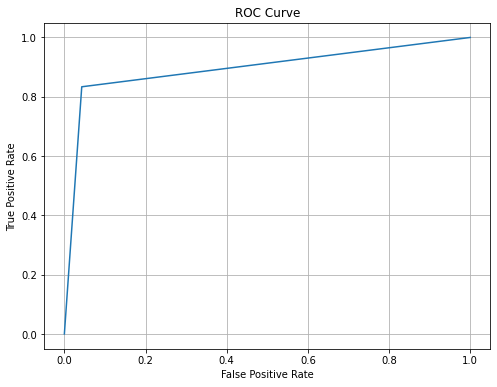

In [ ]:
fpr, tpr, thresholds = roc_curve(test_gt, test_preds)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

La curva ROC si avvicina a quella ideale.

Valutiamo ora classificatori specifici per la categoria "Technology".

In [ ]:
np.random.seed(6400)
tech_train, tech_test = train_test_split(k_tech, test_size=0.25)
print(len(tech_train))
print(len(tech_test))

4294
1432


In [ ]:
model_logit_techtrain = logit('state ~ backers + usd_goal_real + name_length + uppercase_num + country_AU + country_CA + country_DE + country_DK + country_ES + country_FR + country_GB + country_HK + country_IE + country_IT + country_NL + country_NZ + country_SE + country_US', tech_train).fit()
model_logit_techtrain.summary()

Optimization terminated successfully.
         Current function value: 0.228698
         Iterations 13


/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:                 4294
Model:                          Logit   Df Residuals:                     4275
Method:                           MLE   Df Model:                           18
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                  0.5731
Time:                        10:57:27   Log-Likelihood:                -982.03
converged:                       True   LL-Null:                       -2300.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.9649      0.516     -5.741      0.000      -3.977      -1.953
backers           0.0276      0.001     21.704      0.000       0.025       0.030
usd_goal_real    -0.0001   6.04e-06    -16.781      0.000      -0.000   -8.95e-05
name_length       0.0149      0.004      3.851      0.000       0.007       0.023
uppercase_num     0.0284      0.012      2.310      0.021       0.004       0.053
country_AU        0.9186      0.573      1.604      0.109      -0.204       2.041
country_CA        0.6720      0.549      1.224      0.221      -0.404       1.748
country_DE        0.5196      0.663      0.783      0.434      -0.781       1.820
country_DK        1.3475      1.565      0.861      0.389      -1.720       4.415
country_ES        1.0974      0.747      1.469      0.142      -0.367       2.562
country_FR        1.6644      0.640      2.600      0.009       0.410       2.919
country_GB        0.9526      0.527      1.806      0.071      -0.081       1.986
country_HK        1.6350      1.008      1.622      0.105      -0.340       3.610
country_IE        1.4286      1.177      1.214      0.225      -0.877       3.735
country_IT        0.8080      0.743      1.088      0.277      -0.648       2.264
country_NL        0.6102      0.784      0.778      0.436      -0.926       2.147
country_NZ        1.3322      0.783      1.701      0.089      -0.203       2.867
country_SE        1.3014      0.976      1.334      0.182      -0.611       3.214
country_US        0.8693      0.496      1.751      0.080      -0.104       1.842
=================================================================================

Possibly complete quasi-separation: A fraction 0.21 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [ ]:
tech_preds = model_logit_techtrain.predict(tech_test)
tech_preds = tech_preds.dropna().round().astype(int)
tech_gt = tech_test.dropna()['state']

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [ ]:
cm_test = confusion_matrix(tech_gt, tech_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print("False Positive Rate: {:0.2f}".format(fpr))
print("True Positive Rate: {:0.2f}".format(tpr))

[[0.97706422 0.02293578]
 [0.3245614  0.6754386 ]]
False Positive Rate: 0.02
True Positive Rate: 0.68


In [ ]:
print(classification_report(tech_gt, tech_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1090
           1       0.90      0.68      0.77       342

    accuracy                           0.91      1432
   macro avg       0.90      0.83      0.86      1432
weighted avg       0.90      0.91      0.90      1432



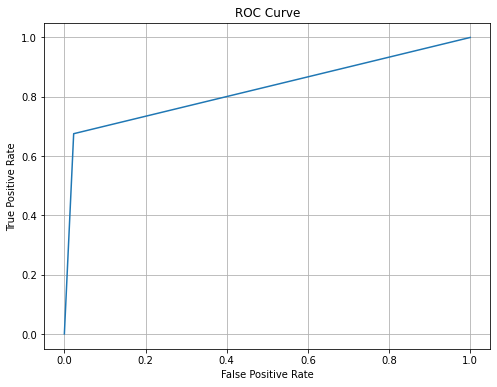

In [ ]:
fpr, tpr, thresholds = roc_curve(tech_gt, tech_preds)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Il classificatore specifico per la categoria "Technology" è generalmente un po' più debole di quello generale, con un True Positive Rate più basso, ossia più difficilmente trova correttamente le campagne andate a buon fine.

### 6.1.3 Senza numero di backer

Stimiamo ora l'errore di generalizzazione del classificatore che non sfrutta il numero di backers, dividendo sempre il dataset in training set e test set.

In [ ]:
np.random.seed(12345)
k_train, k_test = train_test_split(kickstarter_mod, test_size=0.25)
print(len(k_train))
print(len(k_test))

248756
82919


In [ ]:
model_logitB_train = logit('state ~ usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_CH + country_DE + country_DK + country_ES + country_FR + country_GB + country_HK + country_IE + country_IT + country_JP + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', k_train).fit()
model_logitB_train.summary()


/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.620553
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:               248753
Model:                          Logit   Df Residuals:                   248712
Method:                           MLE   Df Model:                           40
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                 0.08003
Time:                        11:16:23   Log-Likelihood:            -1.5436e+05
converged:                       True   LL-Null:                   -1.6779e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.6657      0.131     -5.064      0.000      -0.923      -0.408
usd_goal_real             -1.471e-05   2.44e-07    -60.303      0.000   -1.52e-05   -1.42e-05
name_length                   0.0136      0.000     45.605      0.000       0.013       0.014
days_duration                -0.0182      0.000    -51.008      0.000      -0.019      -0.018
contains_excl                 0.1179      0.015      7.914      0.000       0.089       0.147
uppercase_num                 0.0134      0.001     14.512      0.000       0.012       0.015
main_category_Comics          0.6287      0.028     22.195      0.000       0.573       0.684
main_category_Crafts         -0.8284      0.033    -24.813      0.000      -0.894      -0.763
main_category_Dance           0.7827      0.044     17.781      0.000       0.696       0.869
main_category_Design          0.0339      0.021      1.578      0.115      -0.008       0.076
main_category_Fashion        -0.6740      0.024    -28.289      0.000      -0.721      -0.627
main_category_Film            0.1054      0.018      5.793      0.000       0.070       0.141
main_category_Food           -0.5700      0.023    -24.420      0.000      -0.616      -0.524
main_category_Games           0.1537      0.021      7.393      0.000       0.113       0.194
main_category_Journalism     -0.8095      0.045    -17.938      0.000      -0.898      -0.721
main_category_Music           0.3195      0.019     17.123      0.000       0.283       0.356
main_category_Photography    -0.4446      0.029    -15.112      0.000      -0.502      -0.387
main_category_Publishing     -0.4207      0.020    -21.187      0.000      -0.460      -0.382
main_category_Technology     -0.6127      0.023    -26.526      0.000      -0.658      -0.567
main_category_Theater         0.7777      0.029     27.002      0.000       0.721       0.834
country_AU                    0.2805      0.134      2.098      0.036       0.018       0.543
country_BE                    0.2631      0.175      1.500      0.134      -0.081       0.607
country_CA                    0.3664      0.132      2.779      0.005       0.108       0.625
country_CH                    0.4287      0.166      2.575      0.010       0.102       0.755
country_DE                    0.1594      0.138      1.156      0.248      -0.111       0.429
country_DK                    0.6275      0.154      4.083      0.000       0.326       0.929
country_ES                    0.1485      0.144      1.028      0.304      -0.135       0.432
country_FR                    0.6646      0.139      4.772      0.000       0.392       0.938
country_GB                    0.6136      0.131      4.697      0.000       0.358       0.870
country_HK                    0.7870      0.171      4.590      0.000       0.451       1.123
country_IE                    0.2723      0.166      1.644      0.100      -0.052       0.597
country_IT                   -0.2791      0.1

In [ ]:
test_preds = model_logitB_train.predict(k_test)
test_preds = test_preds.dropna().round().astype(int)
test_gt = k_test.dropna()['state']

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [ ]:
accuracy_score(test_gt, test_preds)

0.6504178776878641

L'accuratezza è bassa, ma tutto sommato migliore delle aspettative che si avevano guardando i valori dello pseudo-$R^2$ e dei p-value.

In [ ]:
cm_test = confusion_matrix(test_gt, test_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print("False Positive Rate: {:0.2f}".format(fpr))
print("True Positive Rate: {:0.2f}".format(tpr))

[[0.8112757  0.1887243 ]
 [0.58684297 0.41315703]]
False Positive Rate: 0.19
True Positive Rate: 0.41


In [ ]:
print(classification_report(test_gt, test_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.67      0.81      0.73     49416
           1       0.60      0.41      0.49     33503

    accuracy                           0.65     82919
   macro avg       0.63      0.61      0.61     82919
weighted avg       0.64      0.65      0.64     82919



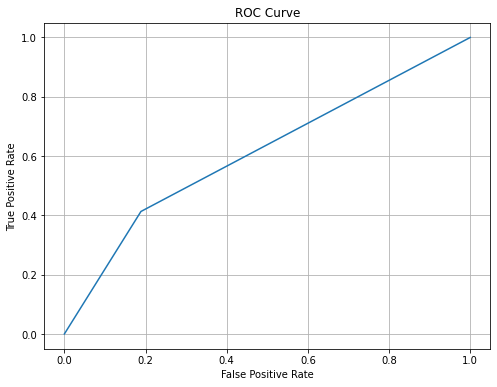

In [ ]:
fpr, tpr, thresholds = roc_curve(test_gt, test_preds)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
(np.exp(model_logitB_train.params)).sort_values(ascending=False)

country_HK                   2.196758
main_category_Dance          2.187264
main_category_Theater        2.176469
country_SG                   1.968330
country_LU                   1.964907
country_FR                   1.943766
country_US                   1.913060
main_category_Comics         1.875098
country_DK                   1.873014
country_GB                   1.847042
country_CH                   1.535278
country_SE                   1.465336
country_CA                   1.442476
country_NZ                   1.387407
main_category_Music          1.376405
country_NO                   1.342085
country_AU                   1.323842
country_IE                   1.312984
country_BE                   1.300953
country_DE                   1.172776
main_category_Games          1.166137
country_ES                   1.160047
country_NL                   1.149422
contains_excl                1.125185
main_category_Film           1.111198
main_category_Design         1.034489
name_length 

Il classificatore tende a trovare più facilmente le campagne fallite. 

Si suppone che fattori come un obiettivo troppo irrealistico o categorie un po' più di nicchia come "Crafts" implicano spesso una maggiore probabilità di fallimento, ma i fattori che aumentano le probabilità di successo sono più sfumati e molto variabili: ci sono campagne che possono essere molto fortunate e diventare virali per i contenuti della campagna in sé o fattori esterni a Kickstarter, come social network.

Valutiamo un classificatore specifico su "Technology" che non usa il numero di backers.

In [ ]:
model_logitB_techtrain = logit('state ~ usd_goal_real + name_length + uppercase_num + country_AU + country_CA + country_DE + country_DK + country_ES + country_FR + country_GB + country_HK + country_IE + country_IT + country_NL + country_NZ + country_SE + country_US', tech_train).fit()
model_logitB_techtrain.summary()

Optimization terminated successfully.
         Current function value: 0.490919
         Iterations 11


/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  state   No. Observations:                 4294
Model:                          Logit   Df Residuals:                     4276
Method:                           MLE   Df Model:                           17
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                 0.08359
Time:                        11:34:31   Log-Likelihood:                -2108.0
converged:                       True   LL-Null:                       -2300.3
Covariance Type:            nonrobust   LLR p-value:                 3.079e-71
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.6425      0.315     -8.401      0.000      -3.259      -2.026
usd_goal_real -9.663e-06   1.04e-06     -9.290      0.000   -1.17e-05   -7.62e-06
name_length       0.0284      0.003     11.061      0.000       0.023       0.033
uppercase_num     0.0107      0.008      1.357      0.175      -0.005       0.026
country_AU        0.2200      0.370      0.595      0.552      -0.505       0.945
country_CA        0.3896      0.336      1.159      0.247      -0.269       1.049
country_DE       -0.0031      0.412     -0.007      0.994      -0.811       0.805
country_DK        1.5403      0.727      2.119      0.034       0.115       2.965
country_ES        0.2854      0.495      0.576      0.565      -0.685       1.256
country_FR        0.9349      0.392      2.384      0.017       0.166       1.704
country_GB        0.5502      0.324      1.697      0.090      -0.085       1.186
country_HK        1.7747      0.789      2.250      0.024       0.229       3.320
country_IE        0.4724      0.864      0.547      0.585      -1.221       2.166
country_IT       -0.2345      0.506     -0.463      0.643      -1.226       0.757
country_NL       -0.2589      0.502     -0.516      0.606      -1.243       0.725
country_NZ        0.0225      0.578      0.039      0.969      -1.110       1.155
country_SE        1.5393      0.611      2.518      0.012       0.341       2.737
country_US        0.6915      0.299      2.310      0.021       0.105       1.278
=================================================================================
"""

In [ ]:
tech_preds = model_logitB_techtrain.predict(tech_test)
tech_preds = tech_preds.dropna().round().astype(int)
tech_gt = tech_test.dropna()['state']

In [ ]:
cm_test = confusion_matrix(tech_gt, tech_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print("False Positive Rate: {:0.2f}".format(fpr))
print("True Positive Rate: {:0.2f}".format(tpr))

[[0.99541284 0.00458716]
 [0.98830409 0.01169591]]
False Positive Rate: 0.00
True Positive Rate: 0.01


In [ ]:
print(classification_report(tech_gt, tech_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1090
           1       0.44      0.01      0.02       342

    accuracy                           0.76      1432
   macro avg       0.60      0.50      0.44      1432
weighted avg       0.69      0.76      0.66      1432



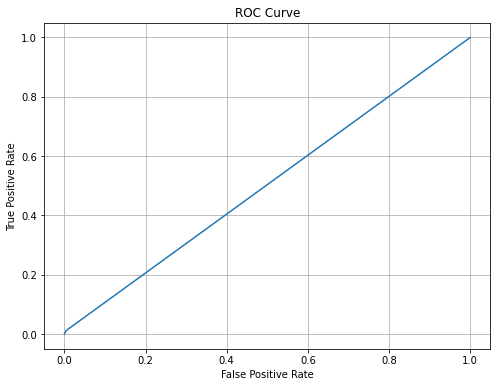

In [ ]:
fpr, tpr, thresholds = roc_curve(tech_gt, tech_preds)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Il classificatore è molto scadente: si suppone che il classificatore generale che non usa il numero di backers sfrutti molto le variabili dummies per categoria e che l'obiettivo nella categoria "Technology" è un buon indicatore solo per trovare campagne fallite.

## 6.2 Naive Bayes

Il classificatore Naive Bayes si basa sull'interpretazione bayesiana di probabilità e della probabilità condizionata. Per semplificare il calcolo, suppone l'indipendenza dei predittori.

### 6.2.1 Con numero di backer

In [ ]:
np.random.seed(5400)
k_train, k_test = train_test_split(kickstarter_mod.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'usd_pledged_real', 'name', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'usd_pledged_real', 'name', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

248754
82918


In [ ]:
k_train.columns

Index(['ID', 'name', 'category', 'currency', 'deadline', 'launched', 'state',
       'backers', 'usd_pledged_real', 'usd_goal_real', 'launched_year',
       'days_duration', 'name_length', 'contains_excl', 'uppercase_num',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion', 'main_category_Film',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AU', 'country_BE', 'country_CA',
       'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR',
       'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP',
       'country_LU', 'country_MX', 'country_N,0"', 'country_NL', 'country_NO',
       'country_NZ', 'country_SE', 'country_SG', 'country_US'],
      dtype='object')

In [ ]:
modelNB = GaussianNB(priors=[0.5,0.5])
modelNB.fit(k_train_vars, k_train['state'])

GaussianNB(priors=[0.5, 0.5], var_smoothing=1e-09)

In [ ]:
modelNB.score(k_train_vars, k_train['state'])

0.4736285647667977

L'accuracy del classificatore sul test set è molto bassa.

In [ ]:
gauss_preds = modelNB.predict(k_test_vars)
gauss_gt = k_test.dropna()['state']
cm_test = confusion_matrix(gauss_gt, gauss_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(gauss_gt, gauss_preds, zero_division=0))

[[0.11759837 0.88240163]
 [0.00146773 0.99853227]]
              precision    recall  f1-score   support

           0       0.99      0.12      0.21     49533
           1       0.43      1.00      0.60     33385

    accuracy                           0.47     82918
   macro avg       0.71      0.56      0.41     82918
weighted avg       0.77      0.47      0.37     82918



La matrice di confusione è molto sbilanciata. Il classificatore tende ad essere troppo ottimista, con un TPR molto alto.

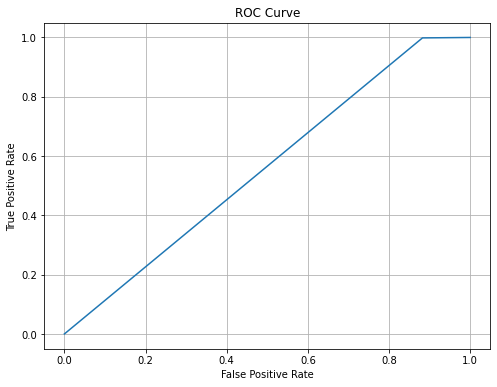

In [ ]:
fpr, tpr, thresholds = roc_curve(gauss_gt, gauss_preds)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

La curva ROC è molto simile alla curva di un classificatore pessimo. Proviamo a modificare le probabilità a priori.

In [ ]:
modelNB = GaussianNB(priors=[0.8,0.2])
modelNB.fit(k_train_vars, k_train['state'])

GaussianNB(priors=[0.8, 0.2], var_smoothing=1e-09)

In [ ]:
modelNB.score(k_test_vars, k_test['state'])

0.7482452543476688

In [ ]:
gauss_preds = modelNB.predict(k_test_vars)
gauss_gt = k_test.dropna()['state']
cm_test = confusion_matrix(gauss_gt, gauss_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(gauss_gt, gauss_preds, zero_division=0))

[[0.97942786 0.02057214]
 [0.59475812 0.40524188]]
              precision    recall  f1-score   support

           0       0.71      0.98      0.82     49533
           1       0.93      0.41      0.56     33385

    accuracy                           0.75     82918
   macro avg       0.82      0.69      0.69     82918
weighted avg       0.80      0.75      0.72     82918



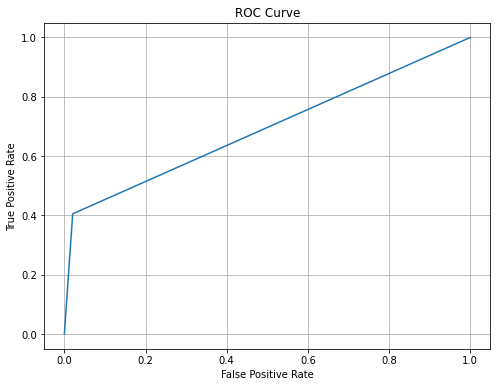

In [ ]:
fpr, tpr, thresholds = roc_curve(gauss_gt, gauss_preds)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Pesando di più la prima probabilità a priori rispetto alla seconda si ottengono risultati leggermente migliori, ma sempre scadenti rispetto alla classificazione con regressione logistica.

### 6.2.2 Senza numero di backer

Valutiamo un classificatore che non sfrutta il numero di backer.

In [ ]:
np.random.seed(5400)
k_train, k_test = train_test_split(kickstarter_mod.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'backers', 'usd_pledged_real', 'name', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'backers', 'usd_pledged_real', 'name', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

248754
82918


In [ ]:
modelNB2 = GaussianNB(priors=[0.4,0.6])
modelNB2.fit(k_train_vars, k_train['state'])

GaussianNB(priors=[0.4, 0.6], var_smoothing=1e-09)

In [ ]:
gauss_preds = modelNB2.predict(k_test_vars)
gauss_gt = k_test.dropna()['state']
cm_test = confusion_matrix(gauss_gt, gauss_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(gauss_gt, gauss_preds, zero_division=0))

[[0.05985908 0.94014092]
 [0.00952524 0.99047476]]
              precision    recall  f1-score   support

           0       0.90      0.06      0.11     49533
           1       0.42      0.99      0.59     33385

    accuracy                           0.43     82918
   macro avg       0.66      0.53      0.35     82918
weighted avg       0.71      0.43      0.30     82918



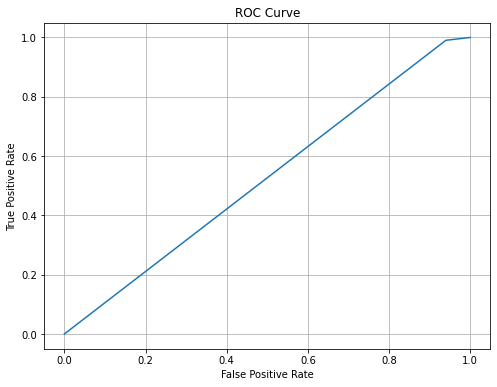

In [ ]:
fpr, tpr, thresholds = roc_curve(gauss_gt, gauss_preds)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Il classificatore è molto scadente, anche provando diversi valori di probabilità a priori.

## 6.3 Alberi decisionali

Nei classificatori con alberi decisionali, ogni nodo interno dell'albero contiene un test su un attributo che stabilisce quale sottoalbero deve essere visitato.

Dato un record, viene percorso l'albero effettuando i test sui suoi attrributi fino ad arrivare ad una foglia che rappresenta l'etichetta di una classe.

Gli alberi decisionali sono molto potenti, ma in caso di alberi troppo profondi possono portare ad overfitting. Valutiamo alberi a varie profondità.

### 6.3.1 Con numero di backer

In [ ]:
np.random.seed(4312)
k_train, k_test = train_test_split(kickstarter_mod.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

248754
82918


In [ ]:
modelTree = tree.DecisionTreeClassifier(max_depth=3)
modelTree.fit(k_train_vars,k_train['state'])

predictedTree = modelTree.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[44324  5234]
 [ 2598 30762]]
Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     49558
           1       0.85      0.92      0.89     33360

    accuracy                           0.91     82918
   macro avg       0.90      0.91      0.90     82918
weighted avg       0.91      0.91      0.91     82918



Con un albero con profondità di appena 3 si ottiene un ottimo classificatore.

In [ ]:
modelTree = tree.DecisionTreeClassifier(max_depth=6)
modelTree.fit(k_train_vars,k_train['state'])

predictedTree = modelTree.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[45837  3721]
 [ 2535 30825]]
Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     49558
           1       0.89      0.92      0.91     33360

    accuracy                           0.92     82918
   macro avg       0.92      0.92      0.92     82918
weighted avg       0.93      0.92      0.92     82918



In [ ]:
modelTree = tree.DecisionTreeClassifier(max_depth=12)
modelTree.fit(k_train_vars,k_train['state'])

predictedTree = modelTree.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[46183  3375]
 [ 2717 30643]]
Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     49558
           1       0.90      0.92      0.91     33360

    accuracy                           0.93     82918
   macro avg       0.92      0.93      0.92     82918
weighted avg       0.93      0.93      0.93     82918



Con diversi aumenti di profondità non si ottiene un aumento significativo della qualità, quindi si preferisce l'albero ad altezza 3 per evitare pure overfitting.

In [ ]:
texttree=tree.export_text(modelTree,feature_names=list(k_test_vars.columns))
print(texttree)

|--- backers <= 17.50
|   |--- usd_goal_real <= 800.88
|   |   |--- backers <= 5.50
|   |   |   |--- class: 0
|   |   |--- backers >  5.50
|   |   |   |--- class: 1
|   |--- usd_goal_real >  800.88
|   |   |--- backers <= 10.50
|   |   |   |--- class: 0
|   |   |--- backers >  10.50
|   |   |   |--- class: 0
|--- backers >  17.50
|   |--- usd_goal_real <= 8399.50
|   |   |--- backers <= 33.50
|   |   |   |--- class: 1
|   |   |--- backers >  33.50
|   |   |   |--- class: 1
|   |--- usd_goal_real >  8399.50
|   |   |--- backers <= 79.50
|   |   |   |--- class: 0
|   |   |--- backers >  79.50
|   |   |   |--- class: 1



L'albero di profondità 3 fa solo uso delle feature "backers" e "usd_goal_real". Semplifichiamo il modello rimuovendo le altre.

In [ ]:
np.random.seed(4312)
k_train, k_test = train_test_split(kickstarter_mod.dropna(), test_size=0.25)
k_train_vars = k_train[['backers', 'usd_goal_real']]
k_test_vars = k_test[['backers', 'usd_goal_real']]
print(len(k_train))
print(len(k_test))

248754
82918


In [ ]:
modelTree = tree.DecisionTreeClassifier(max_depth=3)
modelTree.fit(k_train_vars,k_train['state'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

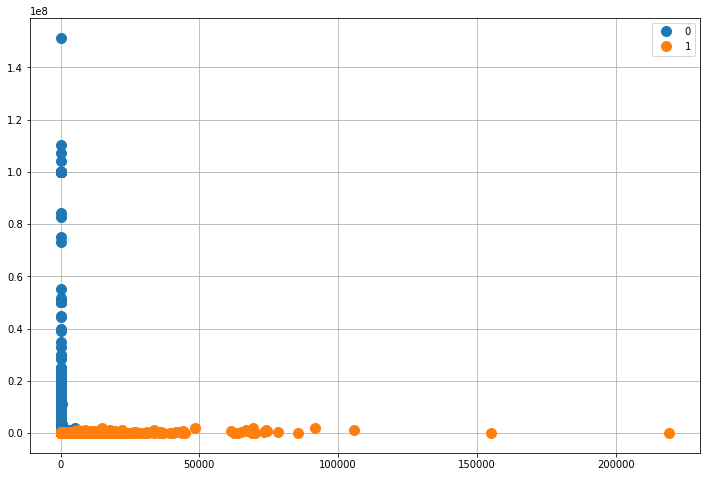

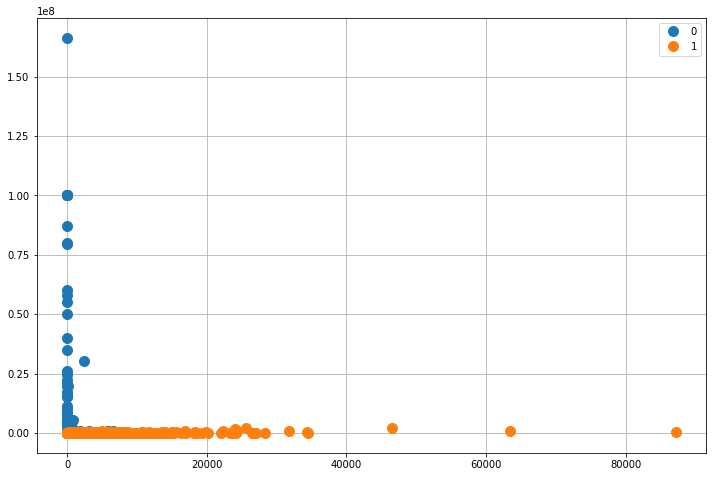

In [ ]:
def plot2d(data, marker='o'):
    classes = sorted(data.state.unique())
    for c in classes:
        plt.plot(data[data['state']==c].backers.values,
                 data[data['state']==c].usd_goal_real.values, '.', label=c, marker=marker, markersize=10)

plt.figure(figsize=(12,8))
plot2d(k_train)
plt.grid()
plt.legend()

plt.figure(figsize=(12,8))
plot2d(k_test)
plt.grid()
plt.legend()
plt.show()

Banalmente, il classificatore si basa molto sul numero di backers: se è sufficientemente grande, classifica la campagna come terminata con successo.

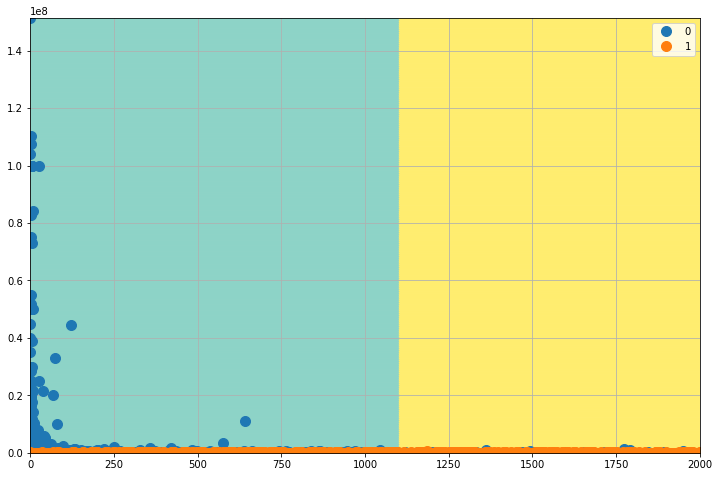

In [ ]:
def plot_decision_tree_boundary(data, tree):
    #plottiamo i dati
    plot2d(data)
    #campioniamo 200 punti in maniera uniforme su entrambi gli assi
    X = np.linspace(data.backers.min(), data.backers.max(),200)
    Y = np.linspace(data.usd_goal_real.min(), data.usd_goal_real.max(),200)
    
    #costruiamo una griglia di coppie 2D di punti
    X,Y = np.meshgrid(X,Y)
    
    #classifichiamo tutti i punti
    Z = tree.predict(np.c_[X.ravel(), Y.ravel()]) # c_ concatena gli array lungo la seconda dimensione
    
    #recuperiamo i nomi delle classi e mettiamole in un dizionario
    class_dict = {c:i for i,c in enumerate(tree.classes_)}
    
    #trasformiamo gli id in classi
    Z=np.array(list(map(lambda x: class_dict[x],Z)))
    
    #modifichiamo la shape di Z per farla diventare una griglia   
    Z = np.array(Z).reshape(X.shape)
    
    #utiliziamo pcolormesh per visualizzare le aree
    plt.pcolormesh(X, Y, Z, antialiased=True, cmap='Set3')

plt.figure(figsize=(12,8))
plot_decision_tree_boundary(k_train,modelTree)
plt.grid()
plt.legend()
plt.xlim(0, 2000)
plt.show()

Proviamo a realizzare un classificatore basato su alberi decisionali per una categoria specifica, questa volta "Video Games".

In [ ]:
k_games = kickstarter_ended[kickstarter_ended['category']=='Video Games']
k_games['country'] = k_games['country'].replace({'N,0"':'NO'})
k_games = pd.get_dummies(k_games, columns=['country'], drop_first=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
np.random.seed(4312)
k_train, k_test = train_test_split(k_games.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'usd_pledged_real', 'main_category', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'usd_pledged_real', 'main_category', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

6995
2332


In [ ]:
modelTree = tree.DecisionTreeClassifier(max_depth=3)
modelTree.fit(k_train_vars,k_train['state'])

predictedTree = modelTree.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[1664   41]
 [ 178  449]]
Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1705
           1       0.92      0.72      0.80       627

    accuracy                           0.91      2332
   macro avg       0.91      0.85      0.87      2332
weighted avg       0.91      0.91      0.90      2332



In [ ]:
modelTree = tree.DecisionTreeClassifier(max_depth=6)
modelTree.fit(k_train_vars,k_train['state'])

predictedTree = modelTree.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[1653   52]
 [ 109  518]]
Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1705
           1       0.91      0.83      0.87       627

    accuracy                           0.93      2332
   macro avg       0.92      0.90      0.91      2332
weighted avg       0.93      0.93      0.93      2332



In [ ]:
modelTree = tree.DecisionTreeClassifier(max_depth=15)
modelTree.fit(k_train_vars,k_train['state'])

predictedTree = modelTree.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[1596  109]
 [ 106  521]]
Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1705
           1       0.83      0.83      0.83       627

    accuracy                           0.91      2332
   macro avg       0.88      0.88      0.88      2332
weighted avg       0.91      0.91      0.91      2332



In questo caso, una profondità più alta porta ad un accuratezza inferiore. Si preferiscono sempre alberi di profondità 3.

In [ ]:
texttree=tree.export_text(modelTree,feature_names=list(k_test_vars.columns))
print(texttree)

|--- backers <= 106.50
|   |--- usd_goal_real <= 1699.60
|   |   |--- backers <= 16.50
|   |   |   |--- class: 0
|   |   |--- backers >  16.50
|   |   |   |--- class: 1
|   |--- usd_goal_real >  1699.60
|   |   |--- backers <= 33.50
|   |   |   |--- class: 0
|   |   |--- backers >  33.50
|   |   |   |--- class: 0
|--- backers >  106.50
|   |--- usd_goal_real <= 12815.63
|   |   |--- backers <= 151.50
|   |   |   |--- class: 1
|   |   |--- backers >  151.50
|   |   |   |--- class: 1
|   |--- usd_goal_real >  12815.63
|   |   |--- backers <= 856.50
|   |   |   |--- class: 0
|   |   |--- backers >  856.50
|   |   |   |--- class: 1



Anche con il classificatore specifico valgono le stesse considerazioni: non si ha un aumento significativo della qualità all'aumentare della profondità e le uniche feature utilizzate per i controlli sono "backers" e "usd_goal_real".

In [ ]:
np.random.seed(4312)
k_train, k_test = train_test_split(k_games.dropna(), test_size=0.25)
k_train_vars = k_train[['backers', 'usd_goal_real']]
k_test_vars = k_test[['backers', 'usd_goal_real']]
print(len(k_train))
print(len(k_test))

6995
2332


In [ ]:
modelTree = tree.DecisionTreeClassifier(max_depth=15)
modelTree.fit(k_train_vars,k_train['state'])

predictedTree = modelTree.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[1624   81]
 [ 101  526]]
Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1705
           1       0.87      0.84      0.85       627

    accuracy                           0.92      2332
   macro avg       0.90      0.90      0.90      2332
weighted avg       0.92      0.92      0.92      2332



### 6.3.2 Senza numero di backer

Valutiamo ora degli alberi decisionali che non sfruttano il numero di backer.

In [ ]:
np.random.seed(5642)
k_train, k_test = train_test_split(kickstarter_mod.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

248754
82918


In [ ]:
modelTreeB = tree.DecisionTreeClassifier(max_depth=3)
modelTreeB.fit(k_train_vars,k_train['state'])

predictedTree = modelTreeB.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[39443  9803]
 [21295 12377]]
Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.65      0.80      0.72     49246
           1       0.56      0.37      0.44     33672

    accuracy                           0.62     82918
   macro avg       0.60      0.58      0.58     82918
weighted avg       0.61      0.62      0.61     82918



In [ ]:
modelTreeB = tree.DecisionTreeClassifier(max_depth=7)
modelTreeB.fit(k_train_vars,k_train['state'])

predictedTree = modelTreeB.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[39120 10126]
 [18530 15142]]
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.68      0.79      0.73     49246
           1       0.60      0.45      0.51     33672

    accuracy                           0.65     82918
   macro avg       0.64      0.62      0.62     82918
weighted avg       0.65      0.65      0.64     82918



In [ ]:
modelTreeB = tree.DecisionTreeClassifier(max_depth=15)
modelTreeB.fit(k_train_vars,k_train['state'])

predictedTree = modelTreeB.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[37745 11501]
 [16959 16713]]
Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.69      0.77      0.73     49246
           1       0.59      0.50      0.54     33672

    accuracy                           0.66     82918
   macro avg       0.64      0.63      0.63     82918
weighted avg       0.65      0.66      0.65     82918



In [ ]:
texttree=tree.export_text(modelTreeB,feature_names=list(k_test_vars.columns))
print(texttree)

|--- usd_goal_real <= 15031.00
|   |--- uppercase_num <= 3.50
|   |   |--- launched_year <= 2013.50
|   |   |   |--- usd_goal_real <= 4265.66
|   |   |   |   |--- days_duration <= 28.50
|   |   |   |   |   |--- main_category_Theater <= 0.50
|   |   |   |   |   |   |--- main_category_Fashion <= 0.50
|   |   |   |   |   |   |   |--- usd_goal_real <= 141.00
|   |   |   |   |   |   |   |   |--- launched_year <= 2012.50
|   |   |   |   |   |   |   |   |   |--- name_length <= 39.50
|   |   |   |   |   |   |   |   |   |   |--- name_length <= 15.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- name_length >  15.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- name_length >  39.50
|   |   |   |   |   |   |   |   |   |   |--- days_duration <= 11.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- days_duration >  11

Con un albero di profondità 15, chiaramente molto grande e complicato, si ha un'accuratezza leggermente superiore del classificatore corrispondente con regressione logistica, riuscendo a trovare un po' più spesso campagne terminate con successo (TPR 0.5), anche se continua ad essere più efficace nel trovare campagne fallite.

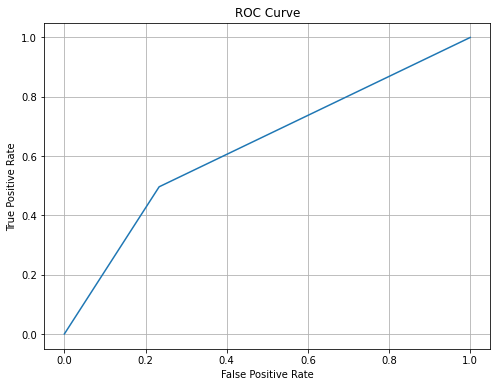

In [ ]:
fpr, tpr, thresholds = roc_curve(k_test['state'], predictedTree)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## 6.4 Foreste di alberi casuali

Le foreste di alberi casuali consistono in molti alberi di profondità limitata dove le soglie per lo splitting vengono scelte a caso.

### 6.4.1 Con numero di backer

In [ ]:
np.random.seed(4314)
k_train, k_test = train_test_split(kickstarter_mod.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'usd_pledged_real','category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

248754
82918


In [ ]:
modelRF = RandomForestClassifier(max_depth=3, n_estimators=100)
modelRF.fit(k_train_vars,k_train['state'])
predictedRTree = modelRF.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

[[46189  3506]
 [ 9517 23706]]
Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     49695
           1       0.87      0.71      0.78     33223

    accuracy                           0.84     82918
   macro avg       0.85      0.82      0.83     82918
weighted avg       0.85      0.84      0.84     82918



In [ ]:
modelRF = RandomForestClassifier(max_depth=7, n_estimators=100)
modelRF.fit(k_train_vars,k_train['state'])
predictedRTree = modelRF.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

[[44469  5226]
 [ 3456 29767]]
Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     49695
           1       0.85      0.90      0.87     33223

    accuracy                           0.90     82918
   macro avg       0.89      0.90      0.89     82918
weighted avg       0.90      0.90      0.90     82918



Aumentando la profondità a 7 aumenta abbastanza la precisione. Vediamo come cambia il classificatore aumentando il numero di alberi piuttosto che la profondità dei singoli.

In [ ]:
modelRF = RandomForestClassifier(max_depth=3, n_estimators=500)
modelRF.fit(k_train_vars,k_train['state'])
predictedRTree = modelRF.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

[[45709  3986]
 [ 8581 24642]]
Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     49695
           1       0.86      0.74      0.80     33223

    accuracy                           0.85     82918
   macro avg       0.85      0.83      0.84     82918
weighted avg       0.85      0.85      0.85     82918



Aumentare di molto il numero di alberi ha aumentato di poco la qualità del classificatore. Si preferisce quindi aumentare principalmente la profondità.

Vediamo un classificatore specifico per la categoria "Film & Video".

In [ ]:
k_film = kickstarter_ended[kickstarter_ended['category']=='Film & Video']
k_film['country'] = k_film['country'].replace({'N,0"':'NO'})
k_film = pd.get_dummies(k_film, columns=['country'], drop_first=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
np.random.seed(5431)
k_train, k_test = train_test_split(k_film.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'usd_pledged_real', 'main_category', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'usd_pledged_real', 'main_category', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

6468
2156


In [ ]:
modelRF = RandomForestClassifier(max_depth=3, n_estimators=100)
modelRF.fit(k_train_vars,k_train['state'])
predictedRTree = modelRF.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

[[1327   42]
 [ 225  562]]
Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1369
           1       0.93      0.71      0.81       787

    accuracy                           0.88      2156
   macro avg       0.89      0.84      0.86      2156
weighted avg       0.88      0.88      0.87      2156



Si ottengono buoni risultati anche con un classificatore specifico per la categoria Film & Video.

### 6.4.2 Senza numero di backer

Vediamo ora classificatori generali che non usano il numero di backer.

In [ ]:
np.random.seed(6521)
k_train, k_test = train_test_split(kickstarter_mod.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real','category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

248754
82918


In [ ]:
modelRFB = RandomForestClassifier(max_depth=3, n_estimators=100)
modelRFB.fit(k_train_vars,k_train['state'])
predictedRTree = modelRFB.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

[[48754   787]
 [31330  2047]]
Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.61      0.98      0.75     49541
           1       0.72      0.06      0.11     33377

    accuracy                           0.61     82918
   macro avg       0.67      0.52      0.43     82918
weighted avg       0.65      0.61      0.49     82918



In [ ]:
modelRFB = RandomForestClassifier(max_depth=4, n_estimators=500)
modelRFB.fit(k_train_vars,k_train['state'])
predictedRTree = modelRFB.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

[[47424  2117]
 [28672  4705]]
Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.62      0.96      0.75     49541
           1       0.69      0.14      0.23     33377

    accuracy                           0.63     82918
   macro avg       0.66      0.55      0.49     82918
weighted avg       0.65      0.63      0.55     82918



Alberi random poco profondi, anche numerosi, riescono difficilmente a trovare campagne terminate con successo.

In [ ]:
modelRFB = RandomForestClassifier(max_depth=10, n_estimators=200)
modelRFB.fit(k_train_vars,k_train['state'])
predictedRTree = modelRFB.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

[[42950  6591]
 [21167 12210]]
Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.67      0.87      0.76     49541
           1       0.65      0.37      0.47     33377

    accuracy                           0.67     82918
   macro avg       0.66      0.62      0.61     82918
weighted avg       0.66      0.67      0.64     82918



In [ ]:
modelRFB = RandomForestClassifier(max_depth=15, n_estimators=300)
modelRFB.fit(k_train_vars,k_train['state'])
predictedRTree = modelRFB.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

[[41052  8489]
 [18327 15050]]
Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.69      0.83      0.75     49541
           1       0.64      0.45      0.53     33377

    accuracy                           0.68     82918
   macro avg       0.67      0.64      0.64     82918
weighted avg       0.67      0.68      0.66     82918



Anche qui necessita di profondità molto alte per avere un TPR accettabile, ma chiaramente a grande rischio overfitting.

In [ ]:
print("Accuracy sul training set: %0.2f" % modelRFB.score(k_train_vars, k_train['state']))
print("Accuracy sul test set: %0.2f" %  modelRFB.score(k_test_vars, k_test['state']))

Accuracy sul training set: 0.71
Accuracy sul test set: 0.68


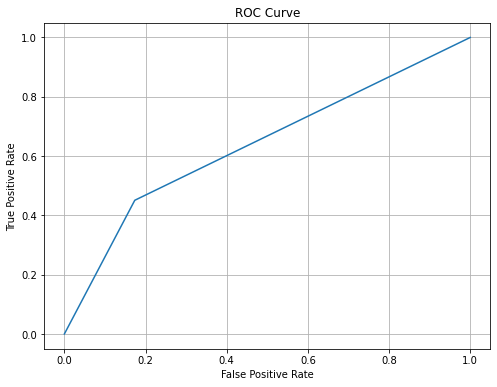

In [ ]:
fpr, tpr, thresholds = roc_curve(k_test['state'], predictedRTree)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In qualunque caso, questo è il classificatore che non sfrutta il numero di backers migliore ottenuto fino ad ora, con un'accuratezza del 71% sul training set e del 68% sul test set.

## 6.5 Standardizzazione dei dati

Le tecniche di classificazione basate su distanze come SVM e K-nn sono molto sensibili alla scala delle singole feature, quindi si preferisce standardizzare il dataset tramite lo Standard Scaler di scikit-learn, che usa lo z-scoring.

In [ ]:
kickstarter_mod_nonscale = kickstarter_mod.copy()
kickstarter_ended_nonscale = kickstarter_ended.copy()

In [ ]:
kickstarter_mod = kickstarter_mod_nonscale.copy()
kickstarter_ended = kickstarter_ended_nonscale.copy()

In [ ]:
kickstarter_mod.columns

Index(['ID', 'name', 'category', 'currency', 'deadline', 'launched', 'state',
       'backers', 'usd_pledged_real', 'usd_goal_real', 'launched_year',
       'days_duration', 'name_length', 'contains_excl', 'uppercase_num',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion', 'main_category_Film',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AU', 'country_BE', 'country_CA',
       'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR',
       'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP',
       'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ',
       'country_SE', 'country_SG', 'country_US'],
      dtype='object')

In [ ]:
scaler = StandardScaler()
kickstarter_mod[['backers', 'usd_pledged_real', 'usd_goal_real', 'name_length', 'days_duration', 'contains_excl', 'uppercase_num', 'main_category_Comics', 'main_category_Crafts', 'main_category_Dance', 'main_category_Design', 'main_category_Fashion', 'main_category_Film', 'main_category_Food', 'main_category_Games', 'main_category_Journalism', 'main_category_Music', 'main_category_Photography', 'main_category_Publishing', 'main_category_Technology', 'main_category_Theater', 'country_AU', 'country_BE', 'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US']] = scaler.fit_transform(kickstarter_mod[['backers', 'usd_pledged_real', 'usd_goal_real', 'name_length', 'days_duration', 'contains_excl', 'uppercase_num', 'main_category_Comics', 'main_category_Crafts', 'main_category_Dance', 'main_category_Design', 'main_category_Fashion', 'main_category_Film', 'main_category_Food', 'main_category_Games', 'main_category_Journalism', 'main_category_Music', 'main_category_Photography', 'main_category_Publishing', 'main_category_Technology', 'main_category_Theater', 'country_AU', 'country_BE', 'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US']])

## 6.6 Support Vector Machine

Una Support Vector Machine è un classificatore binario, che consiste nel calcolare una funzione di decisione i quali parametri massimizzano il margine, definito come la distanza minima tra il decision boundary e uno qualsiasi dei campioni.

Un classificatore SVM è caratterizzato da una funzione kernel applicata sul record. Questa funzione potrebbe mappare i dati in una dimensione superiore, così da avere una separazione più efficace ma più rischio di overfitting.

Il problema dietro SVM è di ottimizzazione non lineare, molto costoso computazionalmente.

In [ ]:
kickstarter_mod = kickstarter_mod.dropna()
k_vars = kickstarter_mod.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_varsB = kickstarter_mod.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)

### 6.6.1 SVM con kernel lineare

Iniziamo dal provare classificatori SVM con kernel lineare, utilizzando la classe LinearSVC che contiene un'implementazione più efficiente rispetto a SVC con parametro di kernel 'linear'.

#### 6.6.1.1 Con numero di backer

In [ ]:
model_linearsvm = LinearSVC(random_state=0, tol=1e-5, dual=False, max_iter=40000)
model_linearsvm.fit(k_vars, kickstarter_mod['state']) 

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=40000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [ ]:
print("Accuracy sul training set: %0.2f" % model_linearsvm.score(k_vars, kickstarter_mod['state']))

Accuracy sul training set: 0.87


Il modello con SVM lineare ha un'accuratezza sul training set abbastanza alta.

Per verificarne meglio la qualità, si suddivide il dataset in training set e test set.

In [ ]:
np.random.seed(4400)
k_train, k_test = train_test_split(kickstarter_mod, test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

248754
82918


In [ ]:
model_linearsvm_train = LinearSVC(random_state=0, tol=1e-5, dual=False, max_iter=40000)
model_linearsvm_train.fit(k_train_vars, k_train['state']) 

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=40000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [ ]:
linearsvm_preds = model_linearsvm_train.predict(k_test_vars)
linearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(linearsvm_gt, linearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(linearsvm_gt, linearsvm_preds, zero_division=0))

[[0.95150397 0.04849603]
 [0.27731667 0.72268333]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     49303
           1       0.91      0.72      0.81     33615

    accuracy                           0.86     82918
   macro avg       0.87      0.84      0.85     82918
weighted avg       0.87      0.86      0.86     82918



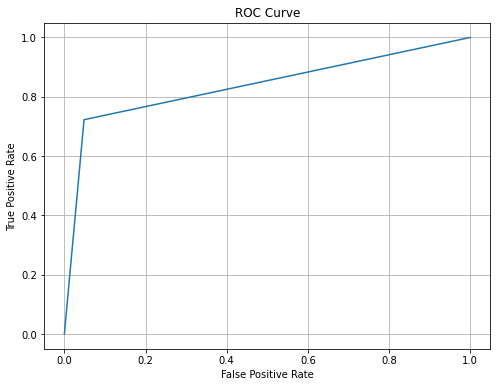

In [ ]:
fpr, tpr, thresholds = roc_curve(linearsvm_gt, linearsvm_preds)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Il classificatore è buono circa quanto quello con regressione logistica.

Proviamo a testare un classificatore specifico per la categoria "Technology".

In [ ]:
np.random.seed(2400)
k_tech = kickstarter_ended[kickstarter_ended['category']=='Technology']
k_tech = pd.get_dummies(k_tech, columns=['country'], drop_first=True)
tech_train, tech_test = train_test_split(k_tech, test_size=0.25)
tech_train_vars = tech_train.drop(labels=['ID', 'name', 'usd_pledged_real', 'main_category', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
tech_test_vars = tech_test.drop(labels=['ID', 'name', 'usd_pledged_real', 'main_category', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(tech_train))
print(len(tech_test))

4294
1432


In [ ]:
model_techlinearsvm_train = LinearSVC(random_state=0, tol=1e-5, dual=False, max_iter=40000)
model_techlinearsvm_train.fit(tech_train_vars, tech_train['state']) 

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=40000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [ ]:
techlinearsvm_preds = model_techlinearsvm_train.predict(tech_test_vars)
techlinearsvm_gt = tech_test.dropna()['state']
cm_test = confusion_matrix(techlinearsvm_gt, techlinearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(techlinearsvm_gt, techlinearsvm_preds, zero_division=0))

[[0.9864743  0.0135257 ]
 [0.35294118 0.64705882]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.94      1109
           1       0.93      0.65      0.76       323

    accuracy                           0.91      1432
   macro avg       0.92      0.82      0.85      1432
weighted avg       0.91      0.91      0.90      1432



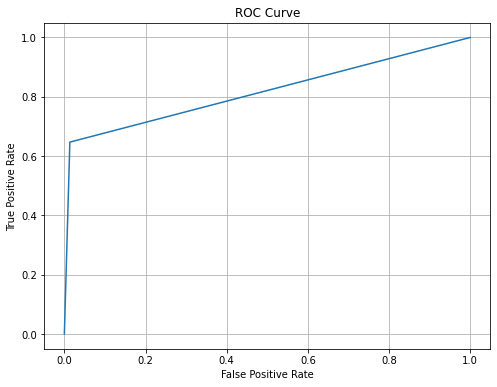

In [ ]:
fpr, tpr, thresholds = roc_curve(techlinearsvm_gt, techlinearsvm_preds)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Il classificatore per la categoria specifica "Technology" è un po' più scadente di quello generale.

#### 6.6.1.2 Senza numero di backer

Verifichiamo un classificatore basato su SVM lineare che non sfrutta il numero di backer.

In [ ]:
np.random.seed(5421)
k_train, k_test = train_test_split(kickstarter_mod, test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

248754
82918


In [ ]:
modelB_linearsvm_train = LinearSVC(random_state=0, tol=1e-5, dual=False, max_iter=40000)
modelB_linearsvm_train.fit(k_train_vars, k_train['state']) 

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=40000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [ ]:
linearsvm_preds = modelB_linearsvm_train.predict(k_test_vars)
linearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(linearsvm_gt, linearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
acc = accuracy_score(linearsvm_gt, linearsvm_preds)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(linearsvm_gt, linearsvm_preds, zero_division=0))

[[0.81843474 0.18156526]
 [0.60898667 0.39101333]]
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.67      0.82      0.73     49602
           1       0.59      0.39      0.47     33316

    accuracy                           0.65     82918
   macro avg       0.63      0.60      0.60     82918
weighted avg       0.64      0.65      0.63     82918



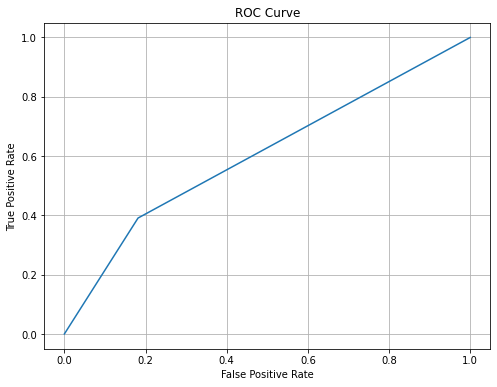

In [ ]:
fpr, tpr, thresholds = roc_curve(linearsvm_gt, linearsvm_preds)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

L'accuratezza è diminuita di poco rispetto al classificatore basato su foreste di alberi random, con un TPR un po' inferiore.

### 6.6.2 SVM con kernel non lineare

Un classificatore SVM non lineare si può ottenere tramite il metodo SVC(), passando il kernel desiderato come parametro. L'algoritmo utilizzato è molto meno efficiente di LinearSVC() e scala più che linearmente rispetto al numero di record, quindi è indispensabile ridurne il numero.

#### 6.6.2.1 Con numero di backer

In [ ]:
np.random.seed(6400)
k_cut = kickstarter_mod.sample(30000)
k_vars = k_cut.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 312719 to 96313
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         30000 non-null  int64         
 1   name                       30000 non-null  object        
 2   category                   30000 non-null  object        
 3   currency                   30000 non-null  object        
 4   deadline                   30000 non-null  datetime64[ns]
 5   launched                   30000 non-null  datetime64[ns]
 6   state                      30000 non-null  int64         
 7   backers                    30000 non-null  float64       
 8   usd_pledged_real           30000 non-null  float64       
 9   usd_goal_real              30000 non-null  float64       
 10  launched_year              30000 non-null  int64         
 11  days_duration              30000 non-null  float64       
 12 

In [ ]:
np.random.seed(1400)
k_train, k_test = train_test_split(k_cut.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

22500
7500


Verifichiamo inizialmente la qualità con un kernel rbf.

In [ ]:
model_nonlinearsvm_train = SVC(kernel='rbf', gamma=0.0001)
model_nonlinearsvm_train.fit(k_train_vars, k_train['state'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
nonlinearsvm_preds = model_nonlinearsvm_train.predict(k_test_vars)
nonlinearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(nonlinearsvm_gt, nonlinearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(nonlinearsvm_gt, nonlinearsvm_preds, zero_division=0))

[[0.93123336 0.06876664]
 [0.12733957 0.87266043]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      4508
           1       0.89      0.87      0.88      2992

    accuracy                           0.91      7500
   macro avg       0.91      0.90      0.90      7500
weighted avg       0.91      0.91      0.91      7500



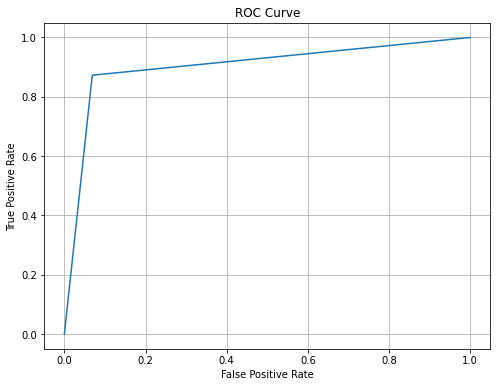

In [ ]:
fpr, tpr, thresholds = roc_curve(nonlinearsvm_gt, nonlinearsvm_preds)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr)
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Il classificatore SVM con kernel rbf è un po' migliore di quello lineare.

#### 6.6.2.2 Senza numero di backer

SVM con kernel non lineari dovrebbe risultare in separazioni più efficaci, potenzialmente potrebbe dare buoni risultati per un classificatore che non sfrutta il numero di backers, verifichiamo.

In [ ]:
np.random.seed(6531)
k_train, k_test = train_test_split(k_cut.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

22500
7500


In [ ]:
modelB_nonlinearsvm_train = SVC(kernel='rbf', gamma=0.0001)
modelB_nonlinearsvm_train.fit(k_train_vars, k_train['state'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
nonlinearsvm_preds = modelB_nonlinearsvm_train.predict(k_test_vars)
nonlinearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(nonlinearsvm_gt, nonlinearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
acc = accuracy_score(nonlinearsvm_gt, nonlinearsvm_preds)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(nonlinearsvm_gt, nonlinearsvm_preds, zero_division=0))

[[0.97333035 0.02666965]
 [0.93548387 0.06451613]]
Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.60      0.97      0.75      4462
           1       0.62      0.06      0.12      3038

    accuracy                           0.61      7500
   macro avg       0.61      0.52      0.43      7500
weighted avg       0.61      0.61      0.49      7500



L'accuratezza è scesa di poco, ma il TPR è diminuita di parecchio, questo classificatore è estremamente pessimista e quindi inadeguato.

In [ ]:
modelB_nonlinearsvm_train = SVC(kernel='rbf', gamma=0.05)
modelB_nonlinearsvm_train.fit(k_train_vars, k_train['state'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
nonlinearsvm_preds = modelB_nonlinearsvm_train.predict(k_test_vars)
nonlinearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(nonlinearsvm_gt, nonlinearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
acc = accuracy_score(nonlinearsvm_gt, nonlinearsvm_preds)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(nonlinearsvm_gt, nonlinearsvm_preds, zero_division=0))

[[0.84087853 0.15912147]
 [0.66589862 0.33410138]]
Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.65      0.84      0.73      4462
           1       0.59      0.33      0.43      3038

    accuracy                           0.64      7500
   macro avg       0.62      0.59      0.58      7500
weighted avg       0.62      0.64      0.61      7500



In [ ]:
modelB_nonlinearsvm_train = SVC(kernel='rbf', gamma=0.5)
modelB_nonlinearsvm_train.fit(k_train_vars, k_train['state'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
nonlinearsvm_preds = modelB_nonlinearsvm_train.predict(k_test_vars)
nonlinearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(nonlinearsvm_gt, nonlinearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
acc = accuracy_score(nonlinearsvm_gt, nonlinearsvm_preds)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(nonlinearsvm_gt, nonlinearsvm_preds, zero_division=0))

[[0.79448678 0.20551322]
 [0.63495721 0.36504279]]
Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.65      0.79      0.71      4462
           1       0.55      0.37      0.44      3038

    accuracy                           0.62      7500
   macro avg       0.60      0.58      0.58      7500
weighted avg       0.61      0.62      0.60      7500



In [ ]:
modelB_nonlinearsvm_train = SVC(kernel='rbf', gamma=2)
modelB_nonlinearsvm_train.fit(k_train_vars, k_train['state'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
nonlinearsvm_preds = modelB_nonlinearsvm_train.predict(k_test_vars)
nonlinearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(nonlinearsvm_gt, nonlinearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
acc = accuracy_score(nonlinearsvm_gt, nonlinearsvm_preds)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(nonlinearsvm_gt, nonlinearsvm_preds, zero_division=0))

[[0.80927835 0.19072165]
 [0.66655695 0.33344305]]
Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.64      0.81      0.72      4462
           1       0.54      0.33      0.41      3038

    accuracy                           0.62      7500
   macro avg       0.59      0.57      0.56      7500
weighted avg       0.60      0.62      0.59      7500



In [ ]:
modelB_nonlinearsvm_train = SVC(kernel='rbf', gamma=1)
modelB_nonlinearsvm_train.fit(k_train_vars, k_train['state'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
nonlinearsvm_preds = modelB_nonlinearsvm_train.predict(k_test_vars)
nonlinearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(nonlinearsvm_gt, nonlinearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
acc = accuracy_score(nonlinearsvm_gt, nonlinearsvm_preds)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(nonlinearsvm_gt, nonlinearsvm_preds, zero_division=0))

[[0.79403855 0.20596145]
 [0.63857801 0.36142199]]
Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.65      0.79      0.71      4462
           1       0.54      0.36      0.43      3038

    accuracy                           0.62      7500
   macro avg       0.60      0.58      0.57      7500
weighted avg       0.60      0.62      0.60      7500



Classificatori con valori di gamma troppo bassi sono scadenti perché probabilmente tendono a fare overfitting, mentre valori più alti di 0.5 tendono ad abbassare il TPR.

Valutiamo un kernel polinomiale.

In [ ]:
modelB_nonlinearsvm_train = SVC(kernel='poly')
modelB_nonlinearsvm_train.fit(k_train_vars, k_train['state'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
nonlinearsvm_preds = modelB_nonlinearsvm_train.predict(k_test_vars)
nonlinearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(nonlinearsvm_gt, nonlinearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
acc = accuracy_score(nonlinearsvm_gt, nonlinearsvm_preds)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(nonlinearsvm_gt, nonlinearsvm_preds, zero_division=0))

[[1. 0.]
 [1. 0.]]
Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.59      1.00      0.75      4462
           1       0.00      0.00      0.00      3038

    accuracy                           0.59      7500
   macro avg       0.30      0.50      0.37      7500
weighted avg       0.35      0.59      0.44      7500



Si hanno risultati molto scadenti con un kernel polinomiale.

In conclusione, la scelta ideale sembrerebbe un kernel lineare, che è anche più efficiente computazionalmente.

## 6.7 K-Nearest neighbors

### 6.7.1 Introduzione

Il classificatore k-nn è basato sulla vicinanza spaziale tra record e dipende dal parametro k: infatti, si prendono le k tuple più vicine ad una certa X tupla da classificare e si assegna ad X la classe più ricorrente (quindi solitamente k è dispari).

In [ ]:
np.random.seed(6534)
k_train, k_test = train_test_split(kickstarter_mod.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

248754
82918


In [ ]:
model_knn_1 = KNN(n_neighbors=1)
model_knn_1.fit(k_train_vars, k_train['state'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
print("Accuracy sul training set: %0.2f" % model_knn_1.score(k_train_vars, k_train['state']))
print("Accuracy sul test set: %0.2f" %  model_knn_1.score(k_test_vars, k_test['state']))

Accuracy sul training set: 1.00
Accuracy sul test set: 0.89


L'accuracy sul training set è perfetta, mentre sul test set è buona. Un 1-nn ha un decision boundary molto elaborato che può portare ad overfitting.

Migliore accuracy di test: 0.92
Migliore k: 15.00


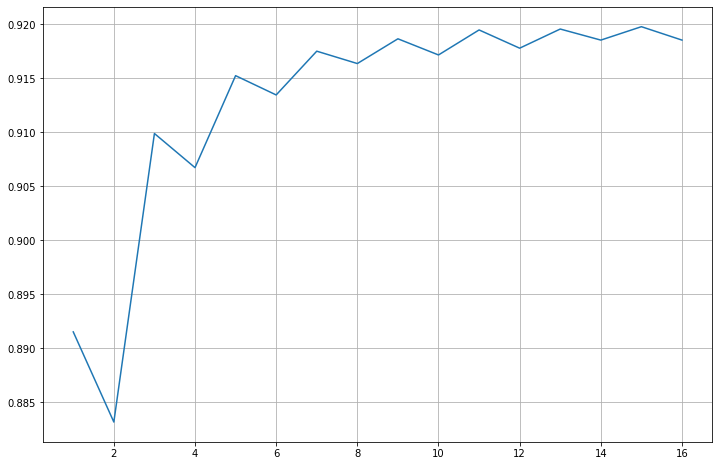

In [ ]:
test_accuracies = []
k_values = range(1, 17) 
for k in k_values:
    knn = KNN(n_neighbors=k)
    knn.fit(k_train_vars, k_train['state'])
    test_accuracies.append(knn.score(k_test_vars, k_test['state']))

best_index = np.argmax(test_accuracies)
best_k = k_values[best_index]
best_accuracy = test_accuracies[best_index]
print("Migliore accuracy di test: %0.2f" % best_accuracy)
print("Migliore k: %0.2f" % best_k)
    
plt.figure(figsize=(12,8))
plt.plot(k_values,test_accuracies)
plt.grid()
plt.show()

Il miglior valore di k sul test set si ha per k = 15, ma questa non è un'analisi adatta perché in fase di training è presente solo il training set e questo valore potrebbe essere adatto solo per questo specifico test set.

### 6.7.2 Multiediting

Dato che il training set utilizzato è molto grande, il tempo di computazione del classificatore potrebbe essere molto grande. Riduciamo il training set utilizzando il multiediting.

In [ ]:
def multiedit(data, target, s=5, T=3):
    #L'algoritmo ha due parametri: s e T. Noi scegliamo
    #s=5 (5 split) e T=3 (termina dopo tre iterazione senza errori di classificazione)
    #come parametri di default
    
    #otteniamo una lista di tutti gli indici dei dati
    all_indices = np.array(range(len(data)))
    #finished indica quando abbiamo finito
    finished = False
    #teniamo traccia delle iterazioni passate dall'ultima volta che abbiamo scartato un campione
    iterations_since_last_change = 0
    knn = KNN(n_neighbors=1)
    while not finished:
        #indica se abbiamo modificato il set in questa iterazione
        edited = False
        
        #suddividiamo gli indici in 3 split casuali
        #per far si che gli split siano casuali, prima effettuiamo una permutazione degli indici
        split_indices = np.array_split(np.random.permutation(all_indices),s)
    
        #questa lista conterrà tutti gli indici degli elementi che sono stati classificati male
        #e vanno rimossi
        mark_for_removal = []

        #per ogni split
        for i in range(s):
            #calcoliamo gli indici degli elementi di training e test
            j = (i+1)%s
            idx_test = split_indices[i]
            idx_train = split_indices[j]
            
            #alleniamo il classificatore 1-NN usando gli elementi di training
            knn.fit(data[idx_train],target[idx_train])
            
            #classifichiamo gli elementi di test
            predictions = knn.predict(data[idx_test])
            
            #contrassegnamo per la rimozione tutti gli elementi che sono stati classificati male
            mark_for_removal.extend(idx_test[np.where(predictions!=target[idx_test])])
            
            #se abbiamo classificato male qualche campione, impostiamo edited a True
            if all(predictions!=target[idx_test]):
                edited = True
                
        #rimuoviamo gli indici che avevamo contrassegnato per la rimozione
        all_indices = np.setdiff1d(all_indices, mark_for_removal)
        
        #se non abbiamo modificato il set
        if not edited:
            #incrementiamo il numero di iterazioni dall'ultimo cambiamento
            iterations_since_last_change+=1
            
        #condizione di terminazione
        if iterations_since_last_change>=T:
            finished=True
    
    #restituiamo il nuovo set
    return data[all_indices], target[all_indices]

In [ ]:
multiedited_data, multiedited_target = multiedit(k_train_vars.values, \
                                                 k_train['state'].values)

data_multiedited = pd.DataFrame()
i = 0
for col_name in k_train_vars.columns:
  data_multiedited[col_name] = multiedited_data[:,i]
  i = i + 1
data_multiedited['state'] = multiedited_target

In [ ]:
knn = KNN(n_neighbors=1)
knn_multiedited = KNN(n_neighbors=1)
knn.fit(k_train_vars, k_train['state'])
knn_multiedited.fit(data_multiedited.drop('state',axis=1), data_multiedited.state)

print("Accuracy di test per 1-NN su training set originale: %0.2f" % \
    knn.score(k_test_vars, k_test['state']))
print("Accuracy di test per 1-NN su training set multieditato: %0.2f" % \
    knn_multiedited.score(k_test_vars, k_test['state']))

Accuracy di test per 1-NN su training set originale: 0.89
Accuracy di test per 1-NN su training set multieditato: 0.92


In [ ]:
k_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248754 entries, 44527 to 189578
Data columns (total 51 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         248754 non-null  int64         
 1   name                       248754 non-null  object        
 2   category                   248754 non-null  object        
 3   currency                   248754 non-null  object        
 4   deadline                   248754 non-null  datetime64[ns]
 5   launched                   248754 non-null  datetime64[ns]
 6   state                      248754 non-null  int64         
 7   backers                    248754 non-null  int64         
 8   usd_pledged_real           248754 non-null  float64       
 9   usd_goal_real              248754 non-null  float64       
 10  launched_year              248754 non-null  int64         
 11  days_duration              248754 non-null  int6

In [ ]:
data_multiedited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210778 entries, 0 to 210777
Data columns (total 44 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   backers                    210778 non-null  float64
 1   usd_goal_real              210778 non-null  float64
 2   launched_year              210778 non-null  float64
 3   days_duration              210778 non-null  float64
 4   name_length                210778 non-null  float64
 5   contains_excl              210778 non-null  float64
 6   uppercase_num              210778 non-null  float64
 7   main_category_Comics       210778 non-null  float64
 8   main_category_Crafts       210778 non-null  float64
 9   main_category_Dance        210778 non-null  float64
 10  main_category_Design       210778 non-null  float64
 11  main_category_Fashion      210778 non-null  float64
 12  main_category_Film         210778 non-null  float64
 13  main_category_Food         21

Sono stati rimossi 38000 record, che sono pochi in proporzione alla quantità totale, ma l'accuracy è migliorata.

In [ ]:
from sklearn.model_selection import GridSearchCV
#definiamo la griglia di parametri.
param_grid = [ {'n_neighbors':range(1,23)}]
#definiamo l'oggetto Grid Search
gs = GridSearchCV(KNN(), param_grid)
#avviamo la ricerca.
gs.fit(data_multiedited.drop('state',axis=1), data_multiedited.state)
best_knn = gs.best_estimator_
print("Migliore valore di K trovato utilizzando solo il training set: %d" % best_knn.n_neighbors)

Migliore valore di K trovato utilizzando solo il training set: 1


L'1-nn sembra il migliore sul training set multieditato.

### 6.7.3 Senza il numero di backer

Le esecuzioni con il dataset intero richiedono parecchio tempo, date tutte le distanze che deve calcolare l'algoritmo, quindi si utilizza il dataset ridotto.

In [ ]:
np.random.seed(42316)
k_train, k_test = train_test_split(k_cut.dropna(), test_size=0.25)
k_train_vars = k_train.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'backers', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
print(len(k_train))
print(len(k_test))

22500
7500


In [ ]:
multiedited_data, multiedited_target = multiedit(k_train_vars.values, \
                                                 k_train['state'].values)

data_multiedited = pd.DataFrame()
i = 0
for col_name in k_train_vars.columns:
  data_multiedited[col_name] = multiedited_data[:,i]
  i = i + 1
data_multiedited['state'] = multiedited_target


In [ ]:
#definiamo la griglia di parametri.
param_grid = [ {'n_neighbors':range(1,23)}]
#definiamo l'oggetto Grid Search
gs = GridSearchCV(KNN(), param_grid)
#avviamo la ricerca.
gs.fit(data_multiedited.drop('state',axis=1), data_multiedited.state)
best_knn = gs.best_estimator_
print("Migliore valore di K trovato utilizzando solo il training set: %d" % best_knn.n_neighbors)

Migliore valore di K trovato utilizzando solo il training set: 1


In [ ]:
print("Accuracy sul training set: %0.2f" % best_knn.score(k_train_vars, k_train['state']))
print("Accuracy sul test set: %0.2f" %  best_knn.score(k_test_vars, k_test['state']))

Accuracy sul training set: 0.67
Accuracy sul test set: 0.62


In [ ]:
predictedBestKNN = best_knn.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedBestKNN)
cm = confusion_matrix(k_test['state'], predictedBestKNN)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedBestKNN,zero_division=0))

[[3517 1001]
 [1819 1163]]
Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.66      0.78      0.71      4518
           1       0.54      0.39      0.45      2982

    accuracy                           0.62      7500
   macro avg       0.60      0.58      0.58      7500
weighted avg       0.61      0.62      0.61      7500



Sia l'accuratezza sul training set che sul test set sono inferiori a quelle del classificatore con foreste di alberi casuali; un altro grande punto a sfavore è che si tratta di un algoritmo computazionalmente più costoso.

## 6.8 Confronto tra classificatori

Per effettuare un confronto, si prende lo stesso sample (ridotto, dato che k-nn e SVM non lineare sono molto lenti con tanti record), si divide in training set e test set e viene utilizzato per allenare e testare i vari classificatori.

In [ ]:
kickstarter_ended['state']=kickstarter_ended['state'].replace({'failed':0, 'successful':1})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
kickstarter_mod = pd.get_dummies(kickstarter_ended, columns=['main_category'], drop_first=True)
kickstarter_mod = kickstarter_mod.rename({'main_category_Film & Video': 'main_category_Film'}, axis=1)
kickstarter_mod['country'] = kickstarter_mod['country'].replace({'N,0"':'NO'})
kickstarter_mod = pd.get_dummies(kickstarter_mod, columns=['country'], drop_first=True).dropna()

In [ ]:
kickstarter_mod_nonscale = kickstarter_mod.copy()
scaler = StandardScaler()
kickstarter_mod[['backers', 'usd_pledged_real', 'usd_goal_real', 'name_length', 'days_duration', 'contains_excl', 'uppercase_num', 'main_category_Comics', 'main_category_Crafts', 'main_category_Dance', 'main_category_Design', 'main_category_Fashion', 'main_category_Film', 'main_category_Food', 'main_category_Games', 'main_category_Journalism', 'main_category_Music', 'main_category_Photography', 'main_category_Publishing', 'main_category_Technology', 'main_category_Theater', 'country_AU', 'country_BE', 'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US']] = scaler.fit_transform(kickstarter_mod[['backers', 'usd_pledged_real', 'usd_goal_real', 'name_length', 'days_duration', 'contains_excl', 'uppercase_num', 'main_category_Comics', 'main_category_Crafts', 'main_category_Dance', 'main_category_Design', 'main_category_Fashion', 'main_category_Film', 'main_category_Food', 'main_category_Games', 'main_category_Journalism', 'main_category_Music', 'main_category_Photography', 'main_category_Publishing', 'main_category_Technology', 'main_category_Theater', 'country_AU', 'country_BE', 'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR', 'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP', 'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US']])

In [ ]:
np.random.seed(6400)
k_reduced = kickstarter_mod.sample(30000)
k_train, k_test = train_test_split(k_reduced, test_size=0.25)
print(len(k_train))
print(len(k_test))

22500
7500


### 6.8.1 Classificatori con numero di backer

In [ ]:
k_train_vars = k_train.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)

In [ ]:
f1_scores = pd.Series()
accuracy_scores = pd.Series()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Regressione logistica:

In [ ]:
model_logit_train = logit('state ~ backers + usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_DE + country_DK + country_ES + country_FR + country_GB + country_IE + country_IT + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', k_train).fit()
test_preds = model_logit_train.predict(k_test)
test_preds = test_preds.dropna().round().astype(int)
test_gt = k_test.dropna()['state']
cm_test = confusion_matrix(test_gt, test_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
f1_scores['LogisticRegression'] = f1_score(test_gt, test_preds)
accuracy_scores['LogisticRegression'] = accuracy_score(test_gt, test_preds)
print(cm_test)
print(classification_report(test_gt, test_preds, zero_division=0))

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.291609
         Iterations 13
[[0.95555556 0.04444444]
 [0.15333333 0.84666667]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      4500
           1       0.93      0.85      0.89      3000

    accuracy                           0.91      7500
   macro avg       0.92      0.90      0.91      7500
weighted avg       0.91      0.91      0.91      7500



Naive Bayes:

In [ ]:
modelNB = GaussianNB(priors=[0.8,0.2])
modelNB.fit(k_train_vars, k_train['state'])
gauss_preds = modelNB.predict(k_test_vars)
gauss_gt = k_test.dropna()['state']
cm_test = confusion_matrix(gauss_gt, gauss_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
f1_scores['NaiveBayes'] = f1_score(gauss_gt, gauss_preds)
accuracy_scores['NaiveBayes'] = accuracy_score(gauss_gt, gauss_preds)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(gauss_gt, gauss_preds, zero_division=0))

[[0.12511111 0.87488889]
 [0.052      0.948     ]]
              precision    recall  f1-score   support

           0       0.78      0.13      0.22      4500
           1       0.42      0.95      0.58      3000

    accuracy                           0.45      7500
   macro avg       0.60      0.54      0.40      7500
weighted avg       0.64      0.45      0.36      7500



Albero decisionale:

In [ ]:
modelTree = tree.DecisionTreeClassifier(max_depth=3)
modelTree.fit(k_train_vars,k_train['state'])

predictedTree = modelTree.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
f1_scores['DecisionTree'] = f1_score(k_test['state'], predictedTree)
accuracy_scores['DecisionTree'] = accuracy_score(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[4164  336]
 [2501  499]]
Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.62      0.93      0.75      4500
           1       0.60      0.17      0.26      3000

    accuracy                           0.62      7500
   macro avg       0.61      0.55      0.50      7500
weighted avg       0.61      0.62      0.55      7500



Foresta di alberi casuali:

In [ ]:
modelRF = RandomForestClassifier(max_depth=7, n_estimators=300)
modelRF.fit(k_train_vars,k_train['state'])
predictedRTree = modelRF.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
f1_scores['RandomForest'] = f1_score(k_test['state'], predictedRTree)
accuracy_scores['RandomForest'] = accuracy_score(k_test['state'], predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

[[4071  429]
 [2172  828]]
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.65      0.90      0.76      4500
           1       0.66      0.28      0.39      3000

    accuracy                           0.65      7500
   macro avg       0.66      0.59      0.57      7500
weighted avg       0.65      0.65      0.61      7500



SVM lineare:

In [ ]:
model_linearsvm_train = LinearSVC(random_state=0, tol=1e-5, dual=False, max_iter=40000)
model_linearsvm_train.fit(k_train_vars, k_train['state']) 
linearsvm_preds = model_linearsvm_train.predict(k_test_vars)
linearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(linearsvm_gt, linearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
f1_scores['LinearSVM'] = f1_score(linearsvm_gt, linearsvm_preds)
accuracy_scores['LinearSVM'] = accuracy_score(linearsvm_gt, linearsvm_preds)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(linearsvm_gt, linearsvm_preds, zero_division=0))

[[0.95644444 0.04355556]
 [0.28733333 0.71266667]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4500
           1       0.92      0.71      0.80      3000

    accuracy                           0.86      7500
   macro avg       0.87      0.83      0.85      7500
weighted avg       0.87      0.86      0.85      7500



SVM con kernel rbf:

In [ ]:
model_nonlinearsvm_train = SVC(kernel='rbf', gamma=0.0001)
model_nonlinearsvm_train.fit(k_train_vars, k_train['state'])
nonlinearsvm_preds = model_nonlinearsvm_train.predict(k_test_vars)
nonlinearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(nonlinearsvm_gt, nonlinearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
f1_scores['NonLinearSVM'] = f1_score(nonlinearsvm_gt, nonlinearsvm_preds)
accuracy_scores['NonLinearSVM'] = accuracy_score(nonlinearsvm_gt, nonlinearsvm_preds)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(nonlinearsvm_gt, nonlinearsvm_preds, zero_division=0))

[[0.95533333 0.04466667]
 [0.88       0.12      ]]
              precision    recall  f1-score   support

           0       0.62      0.96      0.75      4500
           1       0.64      0.12      0.20      3000

    accuracy                           0.62      7500
   macro avg       0.63      0.54      0.48      7500
weighted avg       0.63      0.62      0.53      7500



1-nn:

In [ ]:
model_knn_1 = KNN(n_neighbors=1)
model_knn_1.fit(k_train_vars, k_train['state'])
knn_preds = model_knn_1.predict(k_test_vars)
knn_gt = k_test.dropna()['state']
cm_test = confusion_matrix(knn_gt, knn_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
f1_scores['1nn'] = f1_score(knn_gt, knn_preds)
accuracy_scores['1nn'] = accuracy_score(knn_gt, knn_preds)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(knn_gt, knn_preds, zero_division=0))

[[0.70088889 0.29911111]
 [0.48933333 0.51066667]]
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      4500
           1       0.53      0.51      0.52      3000

    accuracy                           0.62      7500
   macro avg       0.61      0.61      0.61      7500
weighted avg       0.62      0.62      0.62      7500



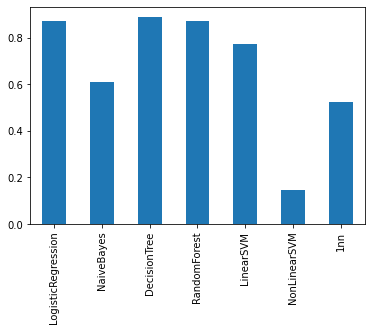

In [ ]:
f1_scores.plot.bar()

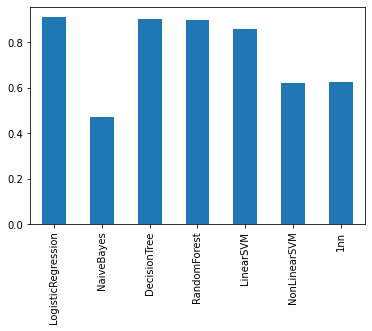

In [ ]:
accuracy_scores.plot.bar()

I classificatori SVM con kernel rbf e 1-nn, oltre ad essere costosi nella costruzione, hanno ottenuto f1-score bassi con questo training set e test set.

I classificatori basati su regressione logistica, alberi decisionali e foreste di alberi random sono comparabili. Il migliore è il singolo albero decisionale.

### 6.8.2 Classificatori senza numero di backer

In [ ]:
k_train_vars = k_train.drop(labels=['ID', 'backers', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)
k_test_vars = k_test.drop(labels=['ID', 'backers', 'name', 'usd_pledged_real', 'category', 'currency', 'deadline', 'launched', 'state'], axis=1)

In [ ]:
f1_scoresB = pd.Series()
accuracy_scoresB = pd.Series()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Regressione logistica:

In [ ]:
model_logitB_train = logit('state ~ usd_goal_real + name_length + days_duration + contains_excl + uppercase_num + main_category_Comics + main_category_Crafts + main_category_Dance + main_category_Design + main_category_Fashion + main_category_Film + main_category_Food + main_category_Games + main_category_Journalism + main_category_Music + main_category_Photography + main_category_Publishing + main_category_Technology + main_category_Theater + country_AU + country_BE + country_CA + country_CH + country_DE + country_DK + country_ES + country_FR + country_GB + country_HK + country_IE + country_IT + country_JP + country_LU + country_MX + country_NL + country_NO + country_NZ + country_SE + country_SG + country_US', k_train).fit()
test_preds = model_logitB_train.predict(k_test)
test_preds = test_preds.dropna().round().astype(int)
test_gt = k_test.dropna()['state']
cm_test = confusion_matrix(test_gt, test_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
f1_scoresB['LogisticRegression'] = f1_score(test_gt, test_preds)
accuracy_scoresB['LogisticRegression'] = accuracy_score(test_gt, test_preds)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(test_gt, test_preds, zero_division=0))

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.620077
         Iterations: 35
[[0.81711111 0.18288889]
 [0.59       0.41      ]]
              precision    recall  f1-score   support

           0       0.68      0.82      0.74      4500
           1       0.60      0.41      0.49      3000

    accuracy                           0.65      7500
   macro avg       0.64      0.61      0.61      7500
weighted avg       0.64      0.65      0.64      7500



/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Naive Bayes:

In [ ]:
modelNB2 = GaussianNB(priors=[0.4,0.6])
modelNB2.fit(k_train_vars, k_train['state'])
gauss_preds = modelNB2.predict(k_test_vars)
gauss_gt = k_test.dropna()['state']
cm_test = confusion_matrix(gauss_gt, gauss_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
f1_scoresB['NaiveBayes'] = f1_score(gauss_gt, gauss_preds)
accuracy_scoresB['NaiveBayes'] = accuracy_score(gauss_gt, gauss_preds)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(gauss_gt, gauss_preds, zero_division=0))

[[0.11511111 0.88488889]
 [0.04733333 0.95266667]]
              precision    recall  f1-score   support

           0       0.78      0.12      0.20      4500
           1       0.42      0.95      0.58      3000

    accuracy                           0.45      7500
   macro avg       0.60      0.53      0.39      7500
weighted avg       0.64      0.45      0.35      7500



Albero decisionale:

In [ ]:
modelTreeB = tree.DecisionTreeClassifier(max_depth=15)
modelTreeB.fit(k_train_vars,k_train['state'])

predictedTree = modelTreeB.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedTree)
cm = confusion_matrix(k_test['state'], predictedTree)
f1_scoresB['DecisionTree'] = f1_score(k_test['state'], predictedTree)
accuracy_scoresB['DecisionTree'] = accuracy_score(k_test['state'], predictedTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedTree,zero_division=0))

[[3216 1284]
 [1581 1419]]
Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      4500
           1       0.52      0.47      0.50      3000

    accuracy                           0.62      7500
   macro avg       0.60      0.59      0.59      7500
weighted avg       0.61      0.62      0.61      7500



Foresta di alberi casuali:

In [ ]:
modelRFB = RandomForestClassifier(max_depth=15, n_estimators=300)
modelRFB.fit(k_train_vars,k_train['state'])
predictedRTree = modelRFB.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
f1_scoresB['RandomForest'] = f1_score(k_test['state'], predictedRTree)
accuracy_scoresB['RandomForest'] = accuracy_score(k_test['state'], predictedRTree)
print(cm)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

[[3707  793]
 [1695 1305]]
Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      4500
           1       0.62      0.43      0.51      3000

    accuracy                           0.67      7500
   macro avg       0.65      0.63      0.63      7500
weighted avg       0.66      0.67      0.65      7500



SVM lineare:

In [ ]:
modelB_linearsvm_train = LinearSVC(random_state=0, tol=1e-5, dual=False, max_iter=40000)
modelB_linearsvm_train.fit(k_train_vars, k_train['state']) 
linearsvm_preds = modelB_linearsvm_train.predict(k_test_vars)
linearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(linearsvm_gt, linearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
f1_scoresB['LinearSVM'] = f1_score(linearsvm_gt, linearsvm_preds)
accuracy_scoresB['LinearSVM'] = accuracy_score(linearsvm_gt, linearsvm_preds)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
acc = accuracy_score(linearsvm_gt, linearsvm_preds)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(linearsvm_gt, linearsvm_preds, zero_division=0))

[[0.828      0.172     ]
 [0.61066667 0.38933333]]
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.67      0.83      0.74      4500
           1       0.60      0.39      0.47      3000

    accuracy                           0.65      7500
   macro avg       0.64      0.61      0.61      7500
weighted avg       0.64      0.65      0.63      7500



SVM con kernel rbf (gamma = 1):

In [ ]:
modelB_nonlinearsvm_train = SVC(kernel='rbf', gamma=1)
modelB_nonlinearsvm_train.fit(k_train_vars, k_train['state'])
nonlinearsvm_preds = modelB_nonlinearsvm_train.predict(k_test_vars)
nonlinearsvm_gt = k_test.dropna()['state']
cm_test = confusion_matrix(nonlinearsvm_gt, nonlinearsvm_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
f1_scoresB['NonLinearSVM'] = f1_score(nonlinearsvm_gt, nonlinearsvm_preds)
accuracy_scoresB['NonLinearSVM'] = accuracy_score(nonlinearsvm_gt, nonlinearsvm_preds)
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(nonlinearsvm_gt, nonlinearsvm_preds, zero_division=0))

[[0.79755556 0.20244444]
 [0.631      0.369     ]]
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      4500
           1       0.55      0.37      0.44      3000

    accuracy                           0.63      7500
   macro avg       0.60      0.58      0.58      7500
weighted avg       0.61      0.63      0.61      7500



1-nn:

In [ ]:
knn = KNN(n_neighbors=1)
knn.fit(k_train_vars, k_train['state'])
predictedBestKNN = knn.predict(k_test_vars)
cm = confusion_matrix(k_test['state'], predictedBestKNN)
f1_scoresB['1nn'] = f1_score(k_test['state'], predictedBestKNN)
accuracy_scoresB['1nn'] = accuracy_score(k_test['state'], predictedBestKNN)
print(cm)
print(classification_report(k_test['state'],predictedBestKNN,zero_division=0))

[[2862 1638]
 [1572 1428]]
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      4500
           1       0.47      0.48      0.47      3000

    accuracy                           0.57      7500
   macro avg       0.56      0.56      0.56      7500
weighted avg       0.57      0.57      0.57      7500



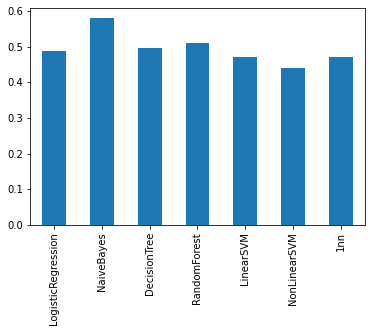

In [ ]:
f1_scoresB.plot.bar()

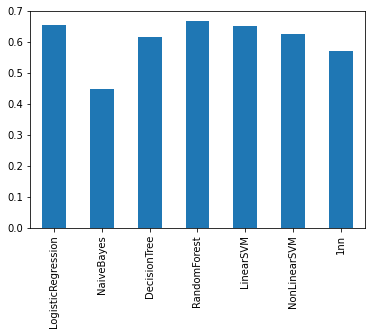

In [ ]:
accuracy_scoresB.plot.bar()

Il classificatore con l'f1-score migliore con gli stessi training set e test set è quello basato su Bayes Naive, seguito da quello basato su foresta di alberi casuali.

Il classificatore con l'accuratezza migliore è invece quello basato su foresta di alberi casuali, mentre quello basato su Bayes Naive ha un'accuratezza molto bassa, tendendo a classificare molte campagne come terminate con successo.

### 6.8.3 Confronto tra i due tipi di classificatori

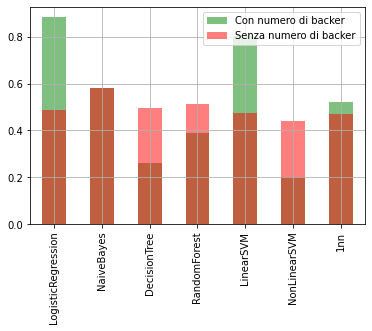

In [ ]:
f1_scores.plot.bar(color='green', alpha=0.5)
f1_scoresB.plot.bar(color='red', alpha=0.5)
plt.legend(['Con numero di backer','Senza numero di backer'])
plt.grid()
plt.show()

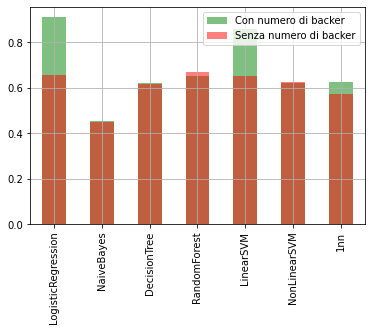

In [ ]:
accuracy_scores.plot.bar(color='green', alpha=0.5)
accuracy_scoresB.plot.bar(color='red', alpha=0.5)
plt.legend(['Con numero di backer','Senza numero di backer'])
plt.grid()
plt.show()

In generale, l'informazione sul numero di backer rende i classificatori migliori.

I due classificatori basati su Bayes Naive sono invece comparabili, probabilmente perché assumono l'indipendenza delle variabili e la correlazione tra numero di backer e stato della campagna è ignorata.

### 6.8.4 AdaBoost

Se si dovesse necessariamente usare un modello senza numero di backer o una stima, si può usare AdaBoostClassifier() della libreria scikit-learn per cercare di migliorare i classificatori.

Bayes Naive prima del boosting:

In [ ]:
modelNB2 = GaussianNB(priors=[0.4,0.6])
modelNB2.fit(k_train_vars, k_train['state'])
gauss_preds = modelNB2.predict(k_test_vars)
gauss_gt = k_test.dropna()['state']
cm_test = confusion_matrix(gauss_gt, gauss_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(f1_score(gauss_gt, gauss_preds))
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(gauss_gt, gauss_preds, zero_division=0))

0.5829634326780807
[[0.17827548 0.82172452]
 [0.09126853 0.90873147]]
              precision    recall  f1-score   support

           0       0.74      0.18      0.29      4465
           1       0.43      0.91      0.58      3035

    accuracy                           0.47      7500
   macro avg       0.59      0.54      0.44      7500
weighted avg       0.62      0.47      0.41      7500



Bayes Naive dopo il boosting:

In [ ]:
abc = AdaBoostClassifier(n_estimators=4, base_estimator=modelNB2, learning_rate=0.01, random_state=123)
abc.fit(k_train_vars, k_train['state'])
gauss_preds = abc.predict(k_test_vars)
gauss_gt = k_test.dropna()['state']
cm_test = confusion_matrix(gauss_gt, gauss_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(f1_score(gauss_gt, gauss_preds))
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(gauss_gt, gauss_preds, zero_division=0))

0.5907027027027028
[[0.21993281 0.78006719]
 [0.09983526 0.90016474]]
              precision    recall  f1-score   support

           0       0.76      0.22      0.34      4465
           1       0.44      0.90      0.59      3035

    accuracy                           0.50      7500
   macro avg       0.60      0.56      0.47      7500
weighted avg       0.63      0.50      0.44      7500



Il classificatore non ha ottenuto un miglioramento significativo ed è diminuito di poco il TPR.

Proviamo adesso ad effettuare il boosting del classificatore basato su foreste di alberi casuali, il secondo in classifica nel confronto effettuato prima.

Foresta di alberi casuali prima del boosting:

In [ ]:
modelRFB = RandomForestClassifier(max_depth=15, n_estimators=300)
modelRFB.fit(k_train_vars,k_train['state'])
predictedRTree = modelRFB.predict(k_test_vars)
acc = accuracy_score(k_test['state'], predictedRTree)
cm = confusion_matrix(k_test['state'], predictedRTree)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(f1_score(k_test['state'], predictedRTree))
print(cm_test)
print("Accuracy: {:0.2f}".format(acc))
print(classification_report(k_test['state'],predictedRTree,zero_division=0))

0.5225014611338399
[[0.83090705 0.16909295]
 [0.55485997 0.44514003]]
Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.69      0.83      0.75      4465
           1       0.64      0.44      0.52      3035

    accuracy                           0.67      7500
   macro avg       0.66      0.64      0.64      7500
weighted avg       0.67      0.67      0.66      7500



Foresta di alberi casuali dopo il boosting:

In [ ]:
abc = AdaBoostClassifier(n_estimators=4, base_estimator=modelRFB, learning_rate=0.01, random_state=123)
abc.fit(k_train_vars, k_train['state'])
rfb_preds = abc.predict(k_test_vars)
rfb_gt = k_test.dropna()['state']
cm_test = confusion_matrix(rfb_gt, rfb_preds)
cm_test = cm_test/cm_test.sum(1).reshape(-1,1)
print(f1_score(rfb_gt, rfb_preds))
print(cm_test)
_, fpr, _, tpr = cm_test.ravel()
print(classification_report(rfb_gt, rfb_preds, zero_division=0))

0.5255786811904299
[[0.83090705 0.16909295]
 [0.55485997 0.44514003]]
              precision    recall  f1-score   support

           0       0.69      0.83      0.75      4465
           1       0.64      0.45      0.53      3035

    accuracy                           0.67      7500
   macro avg       0.66      0.64      0.64      7500
weighted avg       0.67      0.67      0.66      7500



Anche per questo classificatore c'è stato un miglioramento poco significativo.

# 7. Riduzione della dimensionalità

Con la Principal Component Analysis, lo spazio delle feature viene trasformato in un altro spazio dove i vettori di base sono ordinati per varianza non crescente e le feature sono decorrelate tra loro.

La PCA è molto sensibile alla scala: le feature con range grandi e quindi tanta varianza ottengono più peso di quelle con bassa varianza. Risulta indispensabile normalizzare i dati prima.

In [ ]:
kickstarter_num = kickstarter_ended[['backers', 'usd_pledged_real', 'usd_goal_real', 'name_length', 'days_duration', 'contains_excl', 'uppercase_num']].dropna().copy()

In [ ]:
scaler = StandardScaler()
kickstarter_num = scaler.fit_transform(kickstarter_num)

In [ ]:
pca = PCA(n_components=5)
pca.fit(kickstarter_num)
kickstarterT = pca.transform(kickstarter_num)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum()[-1])

[0.25122918 0.20417932 0.14589867 0.1396644  0.13454197]
0.8755135580772139


L'87% della varianza viene mantenuta nelle prime 5 componenti principali su 8. 

Vediamo ora il risultato della PCA escludendo le feature "backers" e "usd_pledged_real" che non sono note a priori per le campagne non terminate.

In [ ]:
kickstarter_num = kickstarter_ended[['usd_goal_real', 'name_length', 'days_duration', 'contains_excl', 'uppercase_num']].dropna().copy()

In [ ]:
scaler = StandardScaler()
kickstarter_num = scaler.fit_transform(kickstarter_num)

In [ ]:
pca = PCA(n_components=4)
pca.fit(kickstarter_num)
kickstarterT = pca.transform(kickstarter_num)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum()[-1])

[0.28696658 0.20427645 0.19552762 0.18844349]
0.8752141489678782


Questa volta, per ottenere l'87% di varianza bisogna vedere ben 4 componenti su 5.

L'utilizzo della PCA non è consigliato data in generale la scarsa correlazione lineare dei dati, in particolare nel secondo caso in cui si rimuovono le uniche due feature linearmente correlate.

# 8. Clustering con K-means

Tramite l'algoritmo k-means si possono trovare gruppi di dati vicini spazialmente tra loro. Questi gruppi vengono chiamati cluster.

L'algoritmo è parametrico in k, il numero di cluster che si vuole trovare.

Per evitare problemi di scala, si procede alla standardizzazione delle colonne numeriche del dataset originale.

In [ ]:
kickstarter_ended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID                331675 non-null  int64         
 1   name              331672 non-null  object        
 2   category          331675 non-null  object        
 3   main_category     331675 non-null  object        
 4   currency          331675 non-null  object        
 5   deadline          331675 non-null  datetime64[ns]
 6   launched          331675 non-null  datetime64[ns]
 7   state             331675 non-null  object        
 8   backers           331675 non-null  int64         
 9   country           331675 non-null  object        
 10  usd_pledged_real  331675 non-null  float64       
 11  usd_goal_real     331675 non-null  float64       
 12  launched_year     331675 non-null  int64         
 13  days_duration     331675 non-null  int64         
 14  name

Si decide di rimuovere le campagne con obiettivi troppo bassi, ma soprattutto troppo alti, perché ce ne sono diverse con obiettivi irrealistici e pochissimi fondi ricevuti.

In [ ]:
kickstarter2 = kickstarter_ended[(kickstarter_ended['usd_goal_real']<4e6) & (kickstarter_ended['usd_goal_real']>100)].dropna()

In [ ]:
kickstarter2.sort_values(by='usd_goal_real', ascending=False).head(5)

ID  ... uppercase_num
283160    51086302  ...             1
20443   1103920570  ...             2
129487   165752093  ...             5
241901   300273209  ...             2
33658   1170831194  ...             7

[5 rows x 17 columns]

In [ ]:
np.random.seed(51234)
k_reduced = kickstarter2.sample(30000).dropna()

In [ ]:
kickstarter_clustering = k_reduced.drop(columns=['ID', 'name', 'category', 'main_category', 'currency', 'state', 'deadline', 'launched', 'country'], axis=1)

In [ ]:
scaler = StandardScaler()
kickstarter_clustering = scaler.fit_transform(kickstarter_clustering)

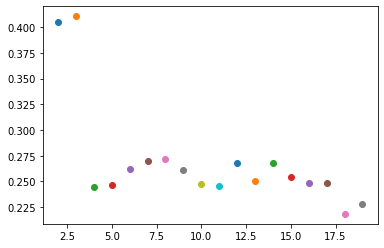

optimal number of clusters is : 3  with a silhouette avg of:  0.4104978503864905


In [ ]:
maxim=0
max_nclus=0

for n_clusters in range(2,20):
    clusterer = KMeans(n_clusters=n_clusters, random_state=30)
    cluster_labels = clusterer.fit_predict(kickstarter_clustering)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(kickstarter_clustering, cluster_labels)
    plt.scatter(n_clusters,silhouette_avg)
    if(maxim<silhouette_avg): 
        maxim=silhouette_avg
        max_nclus=n_clusters
plt.show()
print("optimal number of clusters is :",max_nclus," with a silhouette avg of: ",maxim)

Il numero di cluster associato all'indice di Silhouette migliore è 3, ma è comunque abbastanza basso: i cluster non sono molto separati. Oltre il 3-clustering l'indice diminuisce ulteriormente.

In [ ]:
kmeans = KMeans(n_clusters=3)

In [ ]:
k_clust = kickstarter2.drop(columns=['ID', 'name', 'category', 'main_category', 'currency', 'state', 'deadline', 'launched', 'country'], axis=1).dropna()

In [ ]:
cluster_labels = kmeans.fit_predict(k_clust)

In [ ]:
k_clust['cluster_labels'] = cluster_labels

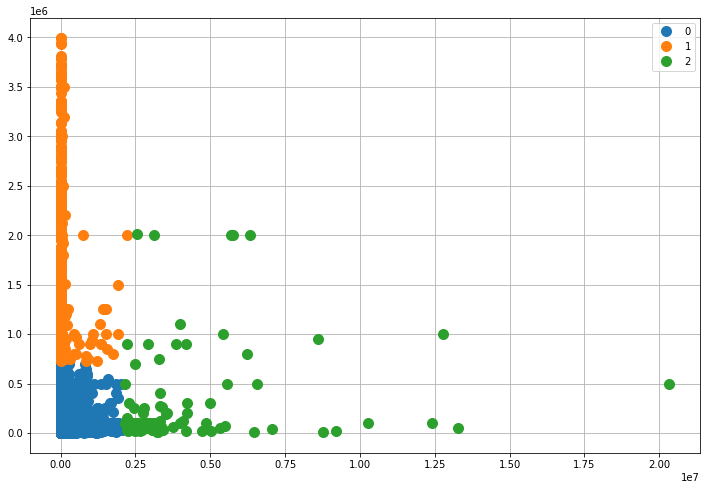

In [ ]:
def plot2d(data):
    classes = sorted(data.cluster_labels.unique())
    for c in classes:
        plt.plot(data.where(data.cluster_labels==c).dropna().usd_pledged_real.values,
                 data.where(data.cluster_labels==c).dropna().usd_goal_real.values,'o', markersize=10, label=str(c))

plt.figure(figsize=(12,8))
plot2d(k_clust)
plt.legend()
plt.grid()
plt.show()

In [ ]:
k_clust['cluster_labels'].value_counts()

0    324978
1      1052
2        90
Name: cluster_labels, dtype: int64

Nonostante si siano rimosse campagne con obiettivi troppo alti, il dataset è comunque pieno di campagne con distanza molto grande tra obiettivo e fondi ricevuti. Di conseguenza, le campagne del cluster 1 sono risultate quelle che hanno obiettivi troppo alti rispetto ai fondi ricevuti.

Fanno parte del cluster 2 principalmente le campagne molto popolari che hanno ricevuto tanti fondi rispetto all'obiettivo richiesto, risultando in termini di distanza molto lontane dalle altre.

Le campagne del cluster 0 sono quelle un po' più equilibrate.

In [ ]:
kickstarter2['cluster_labels'] = cluster_labels

In [ ]:
kickstarter2[kickstarter2['cluster_labels']==2].sort_values(by='usd_pledged_real', ascending=False).head(5)

ID  ... cluster_labels
157270  1799979574  ...              2
250254   342886736  ...              2
216629  2103598555  ...              2
289915   545070200  ...              2
282416   506924864  ...              2

[5 rows x 18 columns]

In [ ]:
kickstarter2[kickstarter2['cluster_labels']==1].sort_values(by='usd_goal_real', ascending=False).head(5)

ID  ... cluster_labels
283160    51086302  ...              1
20443   1103920570  ...              1
129487   165752093  ...              1
241901   300273209  ...              1
33658   1170831194  ...              1

[5 rows x 18 columns]

# 9. Conclusioni

Le campagne su Kickstarter sono molto variegate e i fattori che permettono ad una campagna di avere successo molto numerosi, poco prevedibili e sfumati.

Il successo di una campagna non è sempre influenzato dal numero di backer: è l'esempio della categoria "Dance", che si è visto avere la percentuale più alta di campagne terminate con successo nonostante si richiedano in media meno fondi e si abbiano pochi backer.

Sicuramente aiuta presentare un prodotto innovativo, versatile (ma economico) e di moda: gli smartwatch Pebble hanno ben 3 campagne in cima alla classifica, sono prodotti semplici a livello di design ma con molte funzioni e con un prezzo ragionevole.

Per aumentare le probabilità di un elevato supporto, si può seguire l'esempio delle campagne sui videogiochi, in cui supportare una campagna implica avere un pre-ordine ad un prezzo ragionevole del prodotto e favoreggiare lo sviluppo di altre funzioni. Quindi è importante la chiarezza della campagna, definire bene i vari obiettivi monetari e che prodotto finale ne uscirà fuori effettivamente in base ai fondi ricevuti.

Chiaramente, richiedere troppi fondi può essere un fattore determinante: la categoria "Technology", dove generalmente vengono presentati prodotti molto costosi, ha un'alta percentuale di fallimento. La gente tende a voler investire di meno, non solo per motivi di soldi ma di sicurezza: molto spesso il prodotto finale non è all'altezza delle aspettative o arriva a casa un prodotto non finito, perché il produttore non ha impiegato abbastanza tempo a testarlo.

I modelli di regressione lineare per prevedere il numero di fondi finali delle campagne sono risultati mediocri sfruttando il numero di backer ed inaccettabili senza: sono necessari sondaggi ed indagini di mercato antecedenti per effettuare stime realistiche.

Inoltre, con l'analisi del database dei videogiochi partiti da Kickstarter e usciti su Steam, si è trovata poca correlazione tra lo stato di una campagna e le vendite del prodotto al termine della campagna. Molti prodotti partiti da campagne di Kickstarter sono infatti diventati popolari solo molto dopo del termine della campagna.

I classificatori che sfruttano il numero di backer sono tutto sommato buoni e possono risultare un buon mezzo per prevedere l'esito di una campagna. I classificatori specifici per categorie non sono risultati molto più efficienti.

I classificatori generali e per categoria che non sfruttano il numero di backer non superano l'accuratezza del 70% e tendono ad essere più pessimisti.